# <font color="#114b98">Catégorisez automatiquement des questions</font>

## <font color="#114b98">Notebook de test de différents modèles</font>

**Stack Overflow** est un site célèbre de questions-réponses liées au développement informatique.

L'objectif de ce projet est de développer un système de **suggestion de tags** pour ce site. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.

**Livrable** : Un notebook de test de différents modèles

**Objectifs** : Comparer les modèles et générer des tags pour chacun d'entre eux

## <font color="#114b98">Sommaire</font>
[1. Chargement et préparation du jeu de données](#section_1)

[2. Approche non supervisée : LDA & NMF](#section_2)

[3. Approche non supervisée : RAKE](#section_3)

[4. Approche supervisée : Classifiers](#section_4)

[5. Approche supervisée : Doc2Vec](#section_5)

[6. Approche supervisée : Word2Vec](#section_6)

[7. Approche supervisée : BERT](#section_7)

[8. Approche supervisée : USE](#section_8)

[9. Choix du modèle pour le code final à déployer](#section_9)

[10. Préparation de la pipeline de prédiction](#section_10)

## <font color="#114b98" id="section_1">1. Chargement et préparation du jeu de données</font>

In [2]:
import os
import ast
import sys
import copy
import time
import torch
import psutil
import sklearn
import numpy as np
import pandas as pd
import pkg_resources
import seaborn as sns
import multiprocessing
import tensorflow as tf
from statistics import mean
from tensorflow import keras
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
print("System Version: ",sys.version)
print("Scikit-learn Version: ",sklearn.__version__)
print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ", tf.keras.__version__)
print("PyTorch Version: ", torch.__version__)
print("Num CPUs Available: ", multiprocessing.cpu_count())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Tensorflow build with CUDA:", tf.test.is_built_with_cuda())
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs: " + ", ".join([gpu.name for gpu in tf.config.list_physical_devices('GPU')]))
print("Available CPU memory:", psutil.virtual_memory())
if tf.config.list_physical_devices('GPU'):
    for gpu in gpus:
        print(f"Available memory in {gpu.name}: ", tf.compat.v1.cuda.get_device_properties(gpu).total_memory)
print("Current working directory:", os.getcwd())
disk = psutil.disk_usage('/')
print("Available disk space: {} GB".format(round(disk.free / 1024**3, 2)))

System Version:  3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Scikit-learn Version:  1.0.2
Tensorflow Version:  2.11.0
Keras Version:  2.11.0
PyTorch Version:  1.7.1+cu110
Num CPUs Available:  16
Num GPUs Available:  0
Tensorflow build with CUDA: False
Available GPUs: 
Available CPU memory: svmem(total=51462094848, available=40942743552, percent=20.4, used=10519351296, free=40942743552)
Current working directory: N:\5 - WORK\2 - Jupyter
Available disk space: 456.06 GB


In [4]:
# %load_ext pycodestyle_magic
# %pycodestyle_on

In [5]:
plt.rc('axes', titlesize=22)
plt.rc('axes', labelsize=18)
titleprops = {'fontsize':20}
textprops = {'fontsize':15}
plt.style.use('ggplot')

In [6]:
main_path = 'N:/5 - WORK/1 - Projets/Projet 5/'
data = pd.read_csv(main_path+'saved_ressources/data_cleaned_500tags.csv', encoding='utf8')

In [7]:
data["Texts"] = data["Texts"].apply(lambda x: ast.literal_eval(x))
data["Tags"] = data["Tags"].apply(lambda x: ast.literal_eval(x))
data.head()

Tags  \
0           [python, django, string, json]   
1          [java, html, input, validation]   
2             [java, python, ruby, docker]   
3  [python, list, performance, dictionary]   
4       [ruby, class, inheritance, module]   

                                               Texts  \
0  [python, json, string, json, django, json, str...   
1  [java, html, input, validation, input, java, v...   
2  [docker, python, java, ruby, docker, python, j...   
3  [python, list, list, dictionary, list, diction...   
4  [ruby, inheritance, class, class, module, clas...   

                                           Sentences  
0  python json boolean to lowercase string is the...  
1  is there a java implementation of the html5 in...  
2  encoding problems when running an app in docke...  
3  python dictionary vs list, which is faster? i ...  
4  ruby inheritance vs mixins in ruby, since you ...

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39183 entries, 0 to 39182
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tags       39183 non-null  object
 1   Texts      39183 non-null  object
 2   Sentences  39183 non-null  object
dtypes: object(3)
memory usage: 918.5+ KB


Afin de mettre en place une méthode d’évaluation propre, je décide de séparer le jeu de données en deux parties : 
 - la première me servira à l'entrainement des modèles
 - la seconde partie me permettra d'évaluer certains modèles sur des données qui leurs sont inconnues

In [9]:
data_sample = data[:10000]

In [10]:
data_sample.reset_index(inplace=True, drop=True)

In [11]:
texts_train, texts_eval, tags_train, tags_eval, sentences_train, sentences_eval = train_test_split(
    data_sample["Texts"],
    data_sample["Tags"],
    data_sample["Sentences"],    
    test_size=0.2,
    random_state=42
)

In [12]:
texts_list = texts_train.to_list()
tags_list = tags_train.to_list()
flat_texts = [" ".join(text) for text in texts_list]
vocabulary_texts = list(set([word for item in texts_list for word in item]))
vocabulary_tags = list(set([word for item in tags_list for word in item]))

In [13]:
mlb = MultiLabelBinarizer(classes=vocabulary_tags)
tags_mlb = mlb.fit_transform(tags_list)

In [14]:
texts_list_eval = texts_eval.to_list()
tags_list_eval = tags_eval.to_list()
flat_texts_eval = [" ".join(text) for text in texts_list_eval]
vocabulary_texts_eval = list(set([word for item in texts_list_eval for word in item]))

## <font color="#114b98" id="section_2">2. Approche non supervisée : LDA & NMF</font>

### Détermination du nombre de topics

In [15]:
from tqdm import tqdm
from gensim.models import Nmf
from sklearn.manifold import TSNE
from joblib import Parallel, delayed
from gensim.matutils import corpus2dense
from gensim.models.ldamodel import LdaModel
from sklearn.metrics import silhouette_score
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, jaccard_score, accuracy_score

LDA (Latent Dirichlet Allocation) est une technique de topic modeling qui permet de découvrir les thèmes cachés (ou "latents") dans un ensemble de textes. Elle permet de regrouper des textes qui traitent des mêmes sujets.

La classe LdaModel de gensim est basée sur l'algorithme d'allocation latente de Dirichlet (LDA), qui est un modèle probabiliste génératif utilisé pour découvrir les sujets cachés dans un corpus de textes. La classe LatentDirichletAllocation de scikit-learn est également basée sur l'algorithme LDA, mais elle peut avoir des différences en termes d'implémentation, comme l'algorithme d'optimisation utilisé ou les paramètres disponibles.

NMF (Non-negative Matrix Factorization) est une autre technique de topic modeling qui permet de décomposer une matrice document-terme en deux matrices de facteurs non-négatifs. Elle est souvent utilisée pour découvrir les thèmes cachés dans des textes.

La classe gensim Nmf est basée sur l'algorithme de factorisation de matrice non-négative, qui est différente de la classe NMF de scikit-learn, qui est basée sur la méthode de gradient projeté.

In [16]:
def optimal_num_topics(data, vectorizer, n_topics_range, texts_list):
    """
    Given data, a vectorizer, a range of number of topics to test,
    and the list of texts, applies the models to the data and plots 
    the silhouette and coherence scores to help determine the optimal
    number of topics.

    """

    data = vectorizer.fit_transform(data)
    dictionary = Dictionary(texts_list)
    corpus = [dictionary.doc2bow(txt) for txt in texts_list]

    lda_scores = []
    nmf_scores = []
    coherence_nmf = []
    coherence_lda = []

    for n_topics in tqdm(n_topics_range, ascii=' >='):
        
        # Calculate the silhouette score for the LDA model
        lda = LatentDirichletAllocation(n_components=n_topics, 
                                        max_iter=5)
        lda.fit(data)
        topic_assignments = lda.transform(data)
        labels = np.argmax(topic_assignments, axis=1)
        lda_scores.append(silhouette_score(topic_assignments, labels, 
                                           metric='euclidean'))      

        # Calculate the silhouette score for the NMF model
        nmf = NMF(n_components=n_topics, max_iter=1000)
        nmf.fit(data)
        topic_assignments = nmf.transform(data)
        labels = np.argmax(topic_assignments, axis=1)
        nmf_scores.append(silhouette_score(topic_assignments, labels, 
                                           metric='euclidean'))

        # Calculate the coherence score for the LDA model
        lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary)
        cm_lda = CoherenceModel(model=lda, texts=texts_list, 
                                dictionary=dictionary, coherence='c_v')
        coherence_lda.append(cm_lda.get_coherence())

        # Calculate the coherence score for the NMF model
        nmf = Nmf(corpus, num_topics=n_topics, id2word=dictionary)
        cm_nmf = CoherenceModel(model=nmf, texts=texts_list, 
                                dictionary=dictionary, coherence='c_v')
        coherence_nmf.append(cm_nmf.get_coherence())

    scores = pd.DataFrame(columns=['topics_silhouette',
                                   'score_silhouette',
                                   'topics_coherence',
                                   'score_coherence'],
                          index=['LDA', 'NMF'])

    scores['topics_silhouette'] = [n_topics_range[np.argmax(lda_scores)], 
                                   n_topics_range[np.argmax(nmf_scores)]]
    scores['score_silhouette'] = [max(lda_scores), max(nmf_scores)]
    scores['topics_coherence'] = [n_topics_range[np.argmax(coherence_lda)], 
                                  n_topics_range[np.argmax(coherence_nmf)]]
    scores['score_coherence'] = [max(coherence_lda), max(coherence_nmf)]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    plt.suptitle('Scores de Silhouette et de Coherence pour LDA et NMF avec {}'.format(str(vectorizer).split('(')[0]))
    ax1.plot(n_topics_range, lda_scores, label='LDA')
    ax1.plot(n_topics_range, nmf_scores, label='NMF')
    ax1.set_xlabel('Number of Topics')
    ax1.set_ylabel('Silhouette score')
    ax1.legend()
    ax2.plot(n_topics_range, coherence_lda, label='LDA')
    ax2.plot(n_topics_range, coherence_nmf, label='NMF')
    ax2.set_xlabel('Number of Topics')
    ax2.set_ylabel('Coherence score')
    ax2.legend()
    plt.show()

    return scores

In [17]:
# Define the range of number of topics to test
n_topics_range = range(4, 70, 4)

CountVectorizer() est une implémentation de l'approche bag-of-words pour la vectorisation de textes. Il convertit un ensemble de documents en un tableau de compte de mots (ou un sac de mots), où chaque ligne représente un document et chaque colonne représente un mot. Le nombre dans chaque cellule est le nombre de fois où le mot correspondant est présent dans le document correspondant.

100%|==================================================================================| 17/17 [04:04<00:00, 14.36s/it]


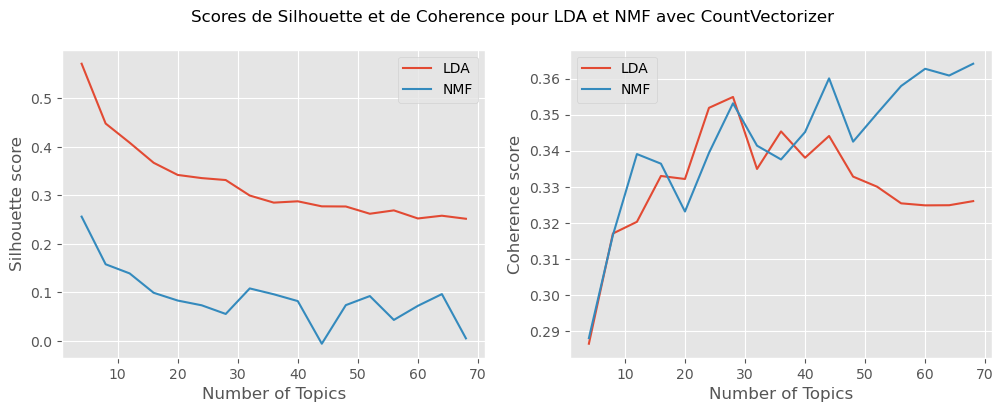

topics_silhouette  score_silhouette  topics_coherence  score_coherence
LDA                  4          0.570991                28         0.354925
NMF                  4          0.256075                68         0.364154

In [18]:
models_CountVectorizer = optimal_num_topics(flat_texts,
                                            CountVectorizer(),
                                            n_topics_range,
                                            texts_list)
models_CountVectorizer

TF-IDF (term frequency-inverse document frequency) est une technique utilisée pour pondérer les termes dans les textes en fonction de leur fréquence d'apparition. Elle permet de donner plus de poids aux termes qui apparaissent fréquemment dans un document mais rarement dans l'ensemble des documents.

100%|==================================================================================| 17/17 [03:35<00:00, 12.66s/it]


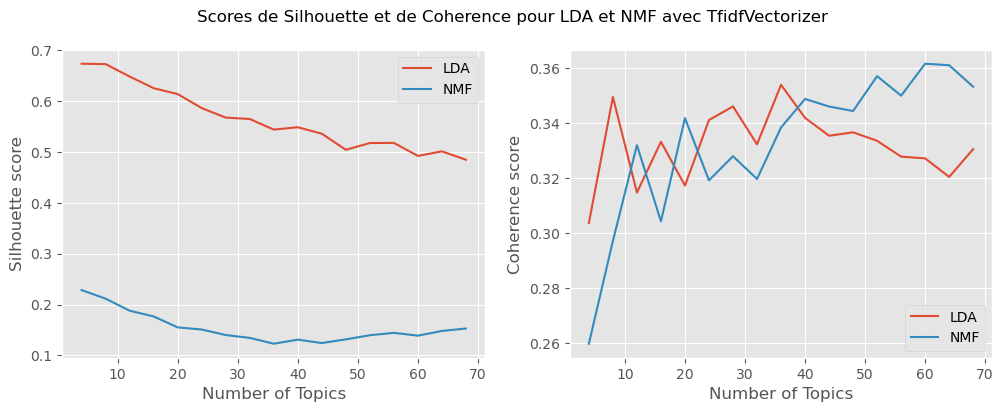

topics_silhouette  score_silhouette  topics_coherence  score_coherence
LDA                  4          0.673041                36         0.353815
NMF                  4          0.228481                60         0.361500

In [19]:
models_TfidfVectorizer = optimal_num_topics(flat_texts,
                                            TfidfVectorizer(vocabulary=vocabulary_texts),
                                            n_topics_range,
                                            texts_list)
models_TfidfVectorizer

Le score de silhouette mesure la similarité d'un objet à son propre groupe par rapport aux autres groupes et généralement, plus il est proche de 1, meilleure est la classification. Le score de cohérence mesure à quel point les sujets sont "interprétables par les humains", généralement plus proche de 1, meilleur c'est.

Dans notre situation, lorsque le nombre de sujets augmente, ils sont davantage "interprétables par les humains".

Je choisis le nombre de topics au regard des résultats précédents.

In [20]:
n_topics_LDA = 40
n_topics_NMF = 40

Le paramètre min_df définit le nombre minimum de documents dans lesquels un mot doit être présent pour être inclus dans le vocabulaire.

In [21]:
min_df = 2

Le paramètre max_df définit la fréquence maximale d'un mot en pourcentage de tous les documents. 

In [22]:
max_df = 0.99

### Visualisation des topics avec CountVectorizer

In [23]:
vectorizer_CV = CountVectorizer(vocabulary=vocabulary_texts, min_df=min_df, max_df=max_df)
vcv = vectorizer_CV.fit_transform(flat_texts)
CV_feature_names = vectorizer_CV.get_feature_names()

In [24]:
n_top_words = 5
n_top_topics = 12

def plot_top_words(model, feature_names, n_top_words, n_top_topics, title, color):
    fig, axes = plt.subplots(3, 4, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color=color)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
        
        if topic_idx == n_top_topics-1:
            break

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

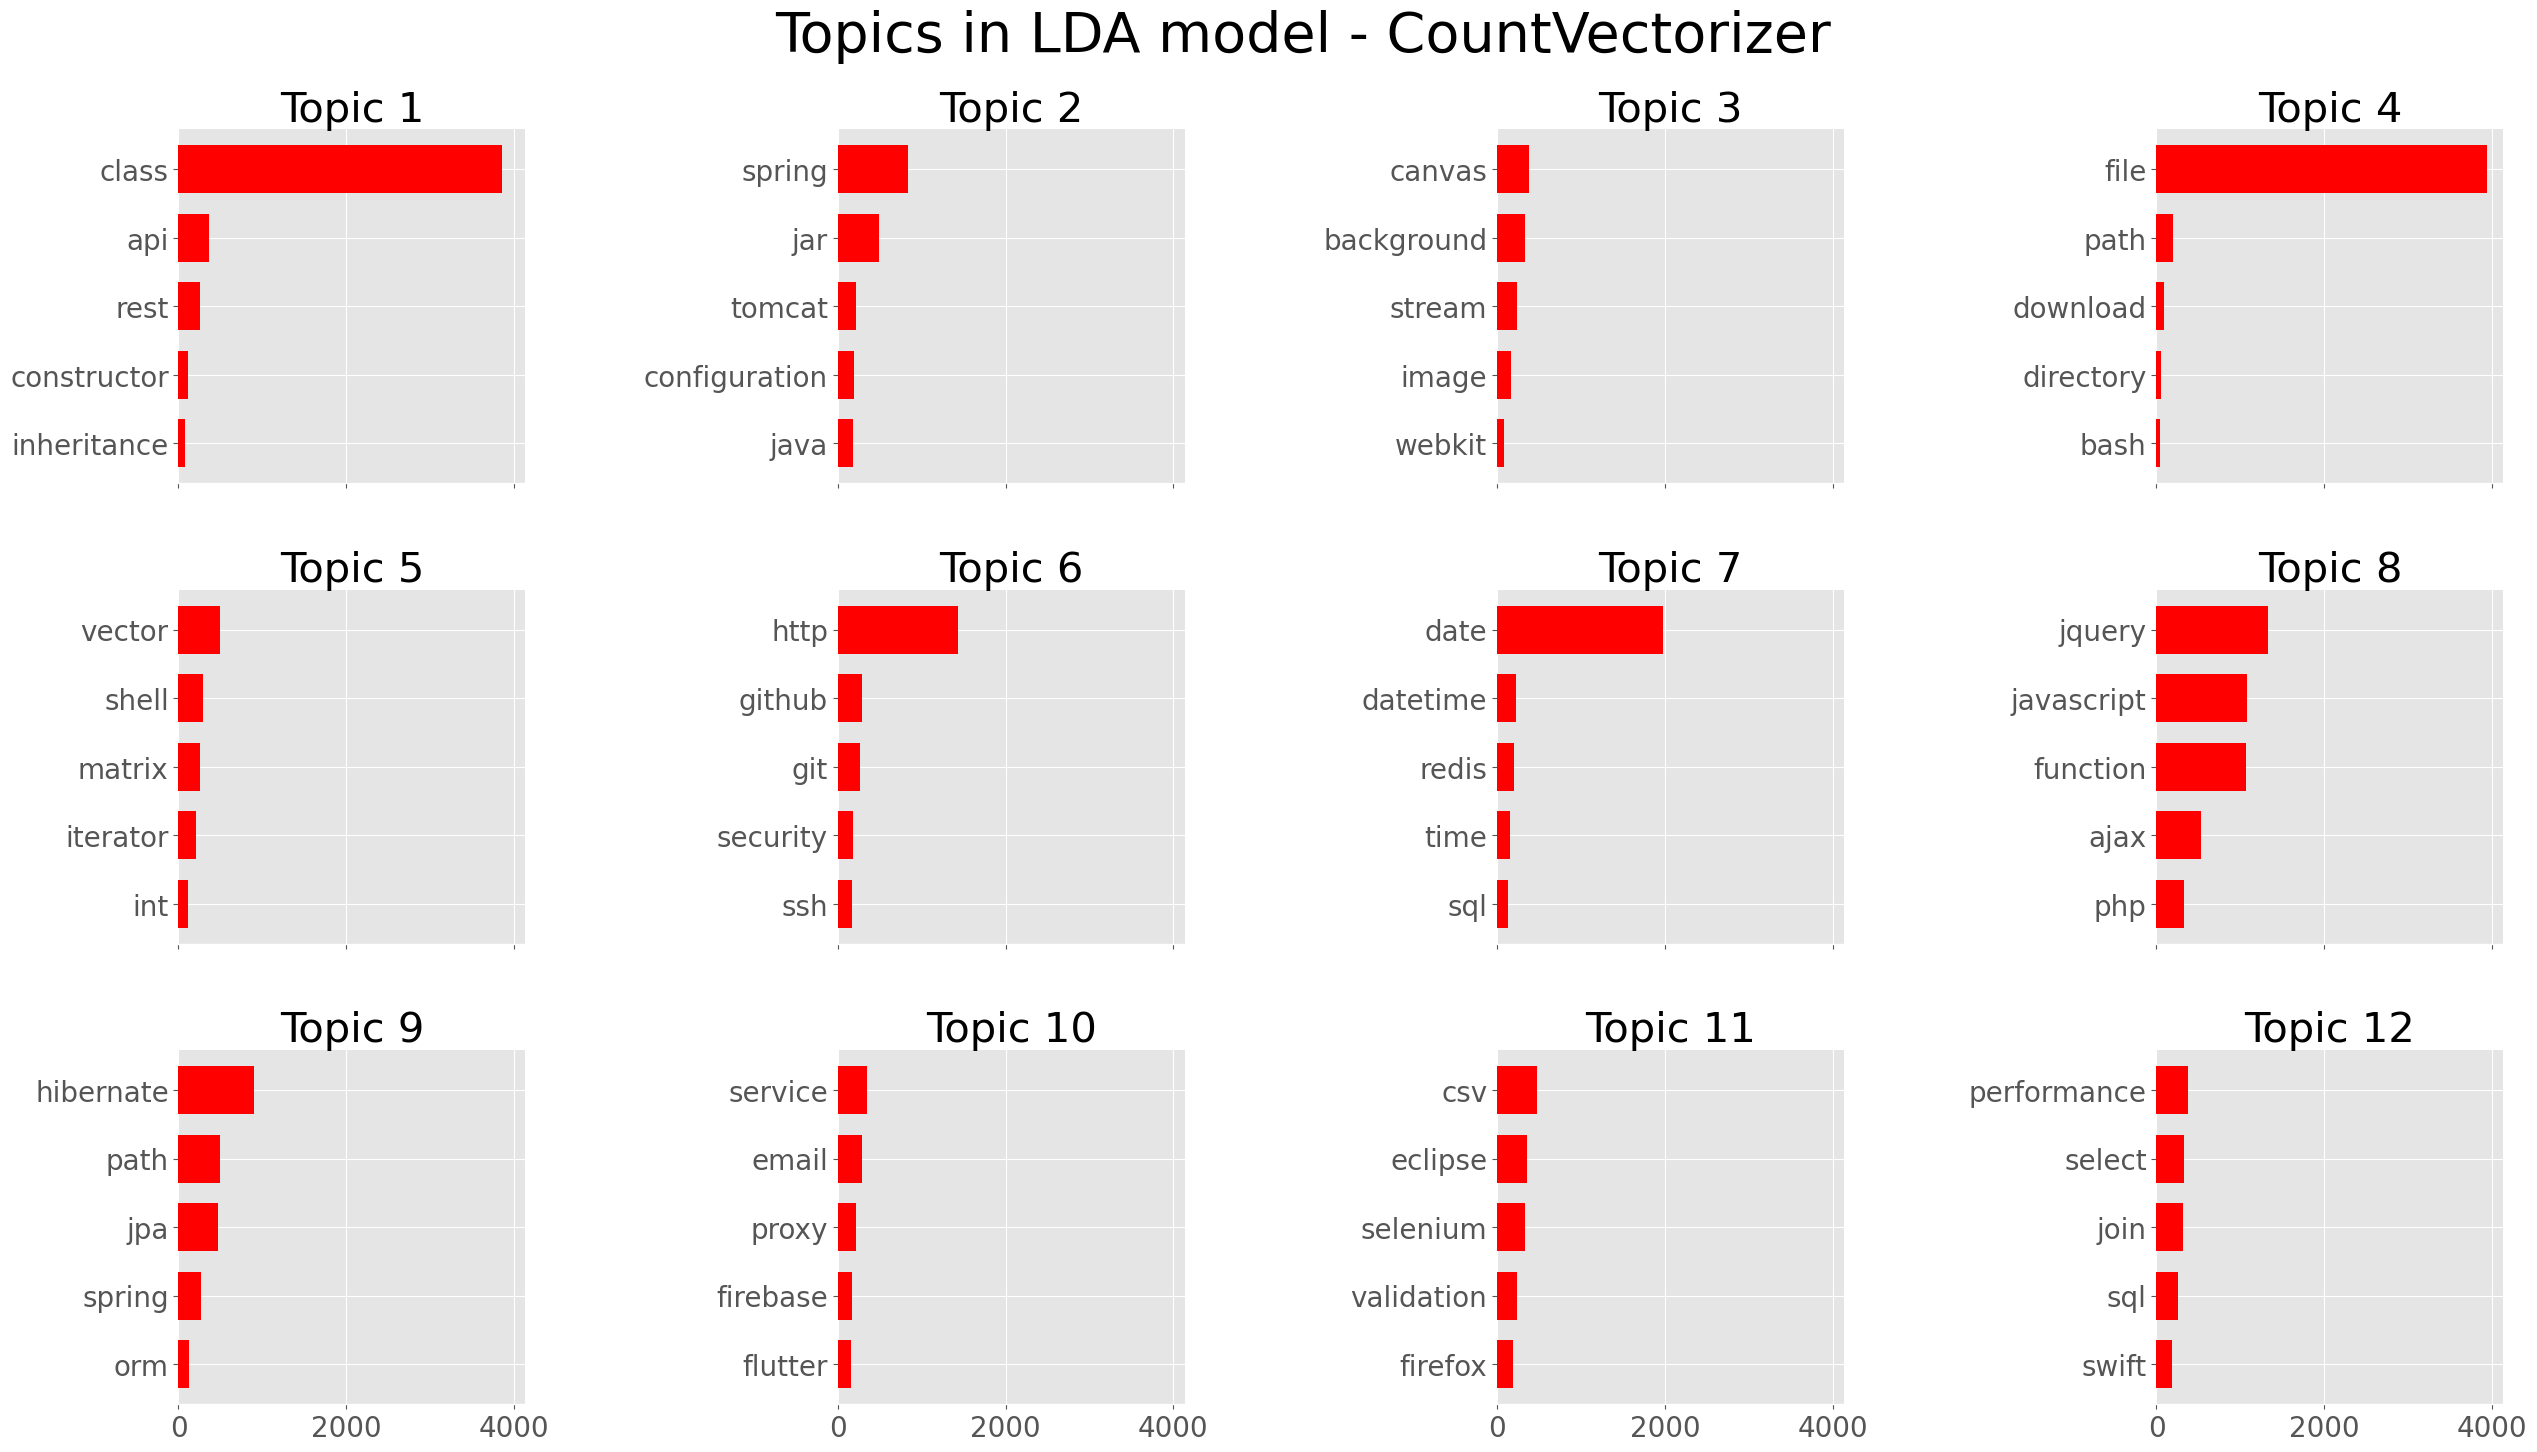

In [25]:
lda = LatentDirichletAllocation(n_components=n_topics_LDA, max_iter=5,
                                random_state=42).fit(vcv)

plot_top_words(lda, CV_feature_names, n_top_words, n_top_topics,
               'Topics in LDA model - CountVectorizer', 'red')

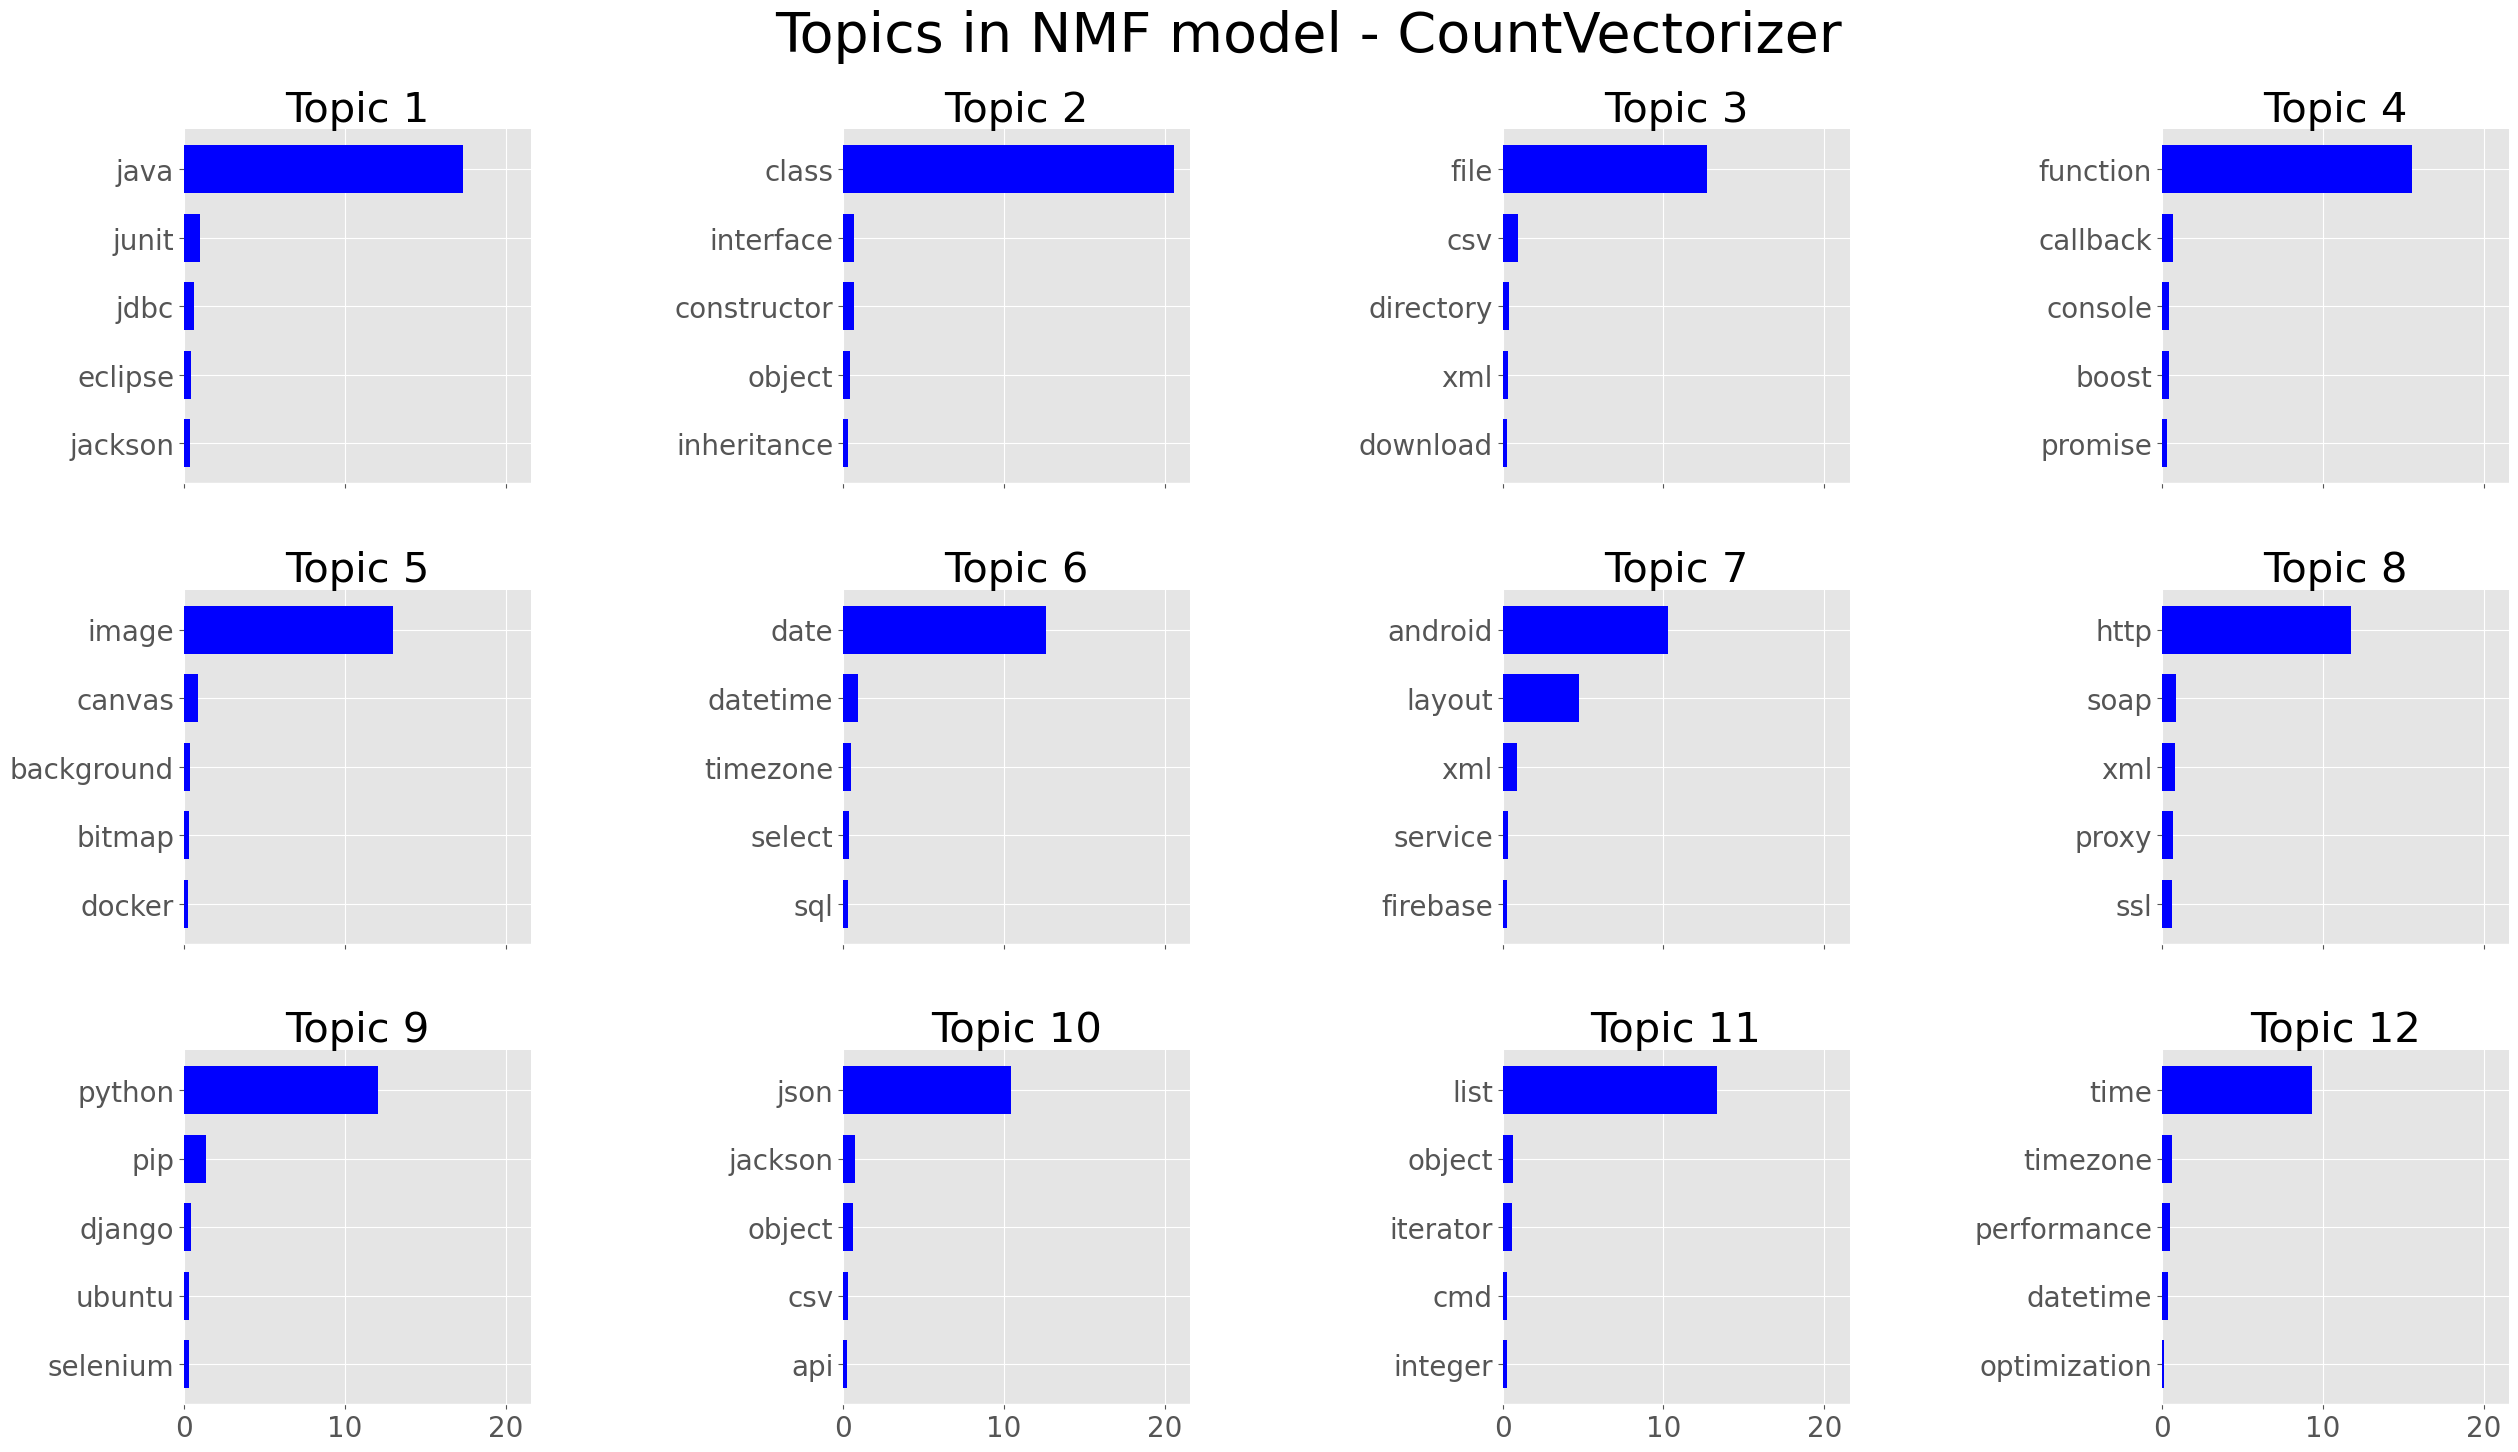

In [26]:
nmf = NMF(n_components=n_topics_NMF, random_state=42).fit(vcv)

plot_top_words(nmf, CV_feature_names, n_top_words, n_top_topics,
               'Topics in NMF model - CountVectorizer', 'blue')

### Visualisation des topics avec TFIDF

In [27]:
vectorizer_TFIDF = TfidfVectorizer(vocabulary=vocabulary_texts, min_df=min_df, max_df=max_df)
tfidf = vectorizer_TFIDF.fit_transform(flat_texts)
TFIDF_feature_names = vectorizer_TFIDF.get_feature_names()

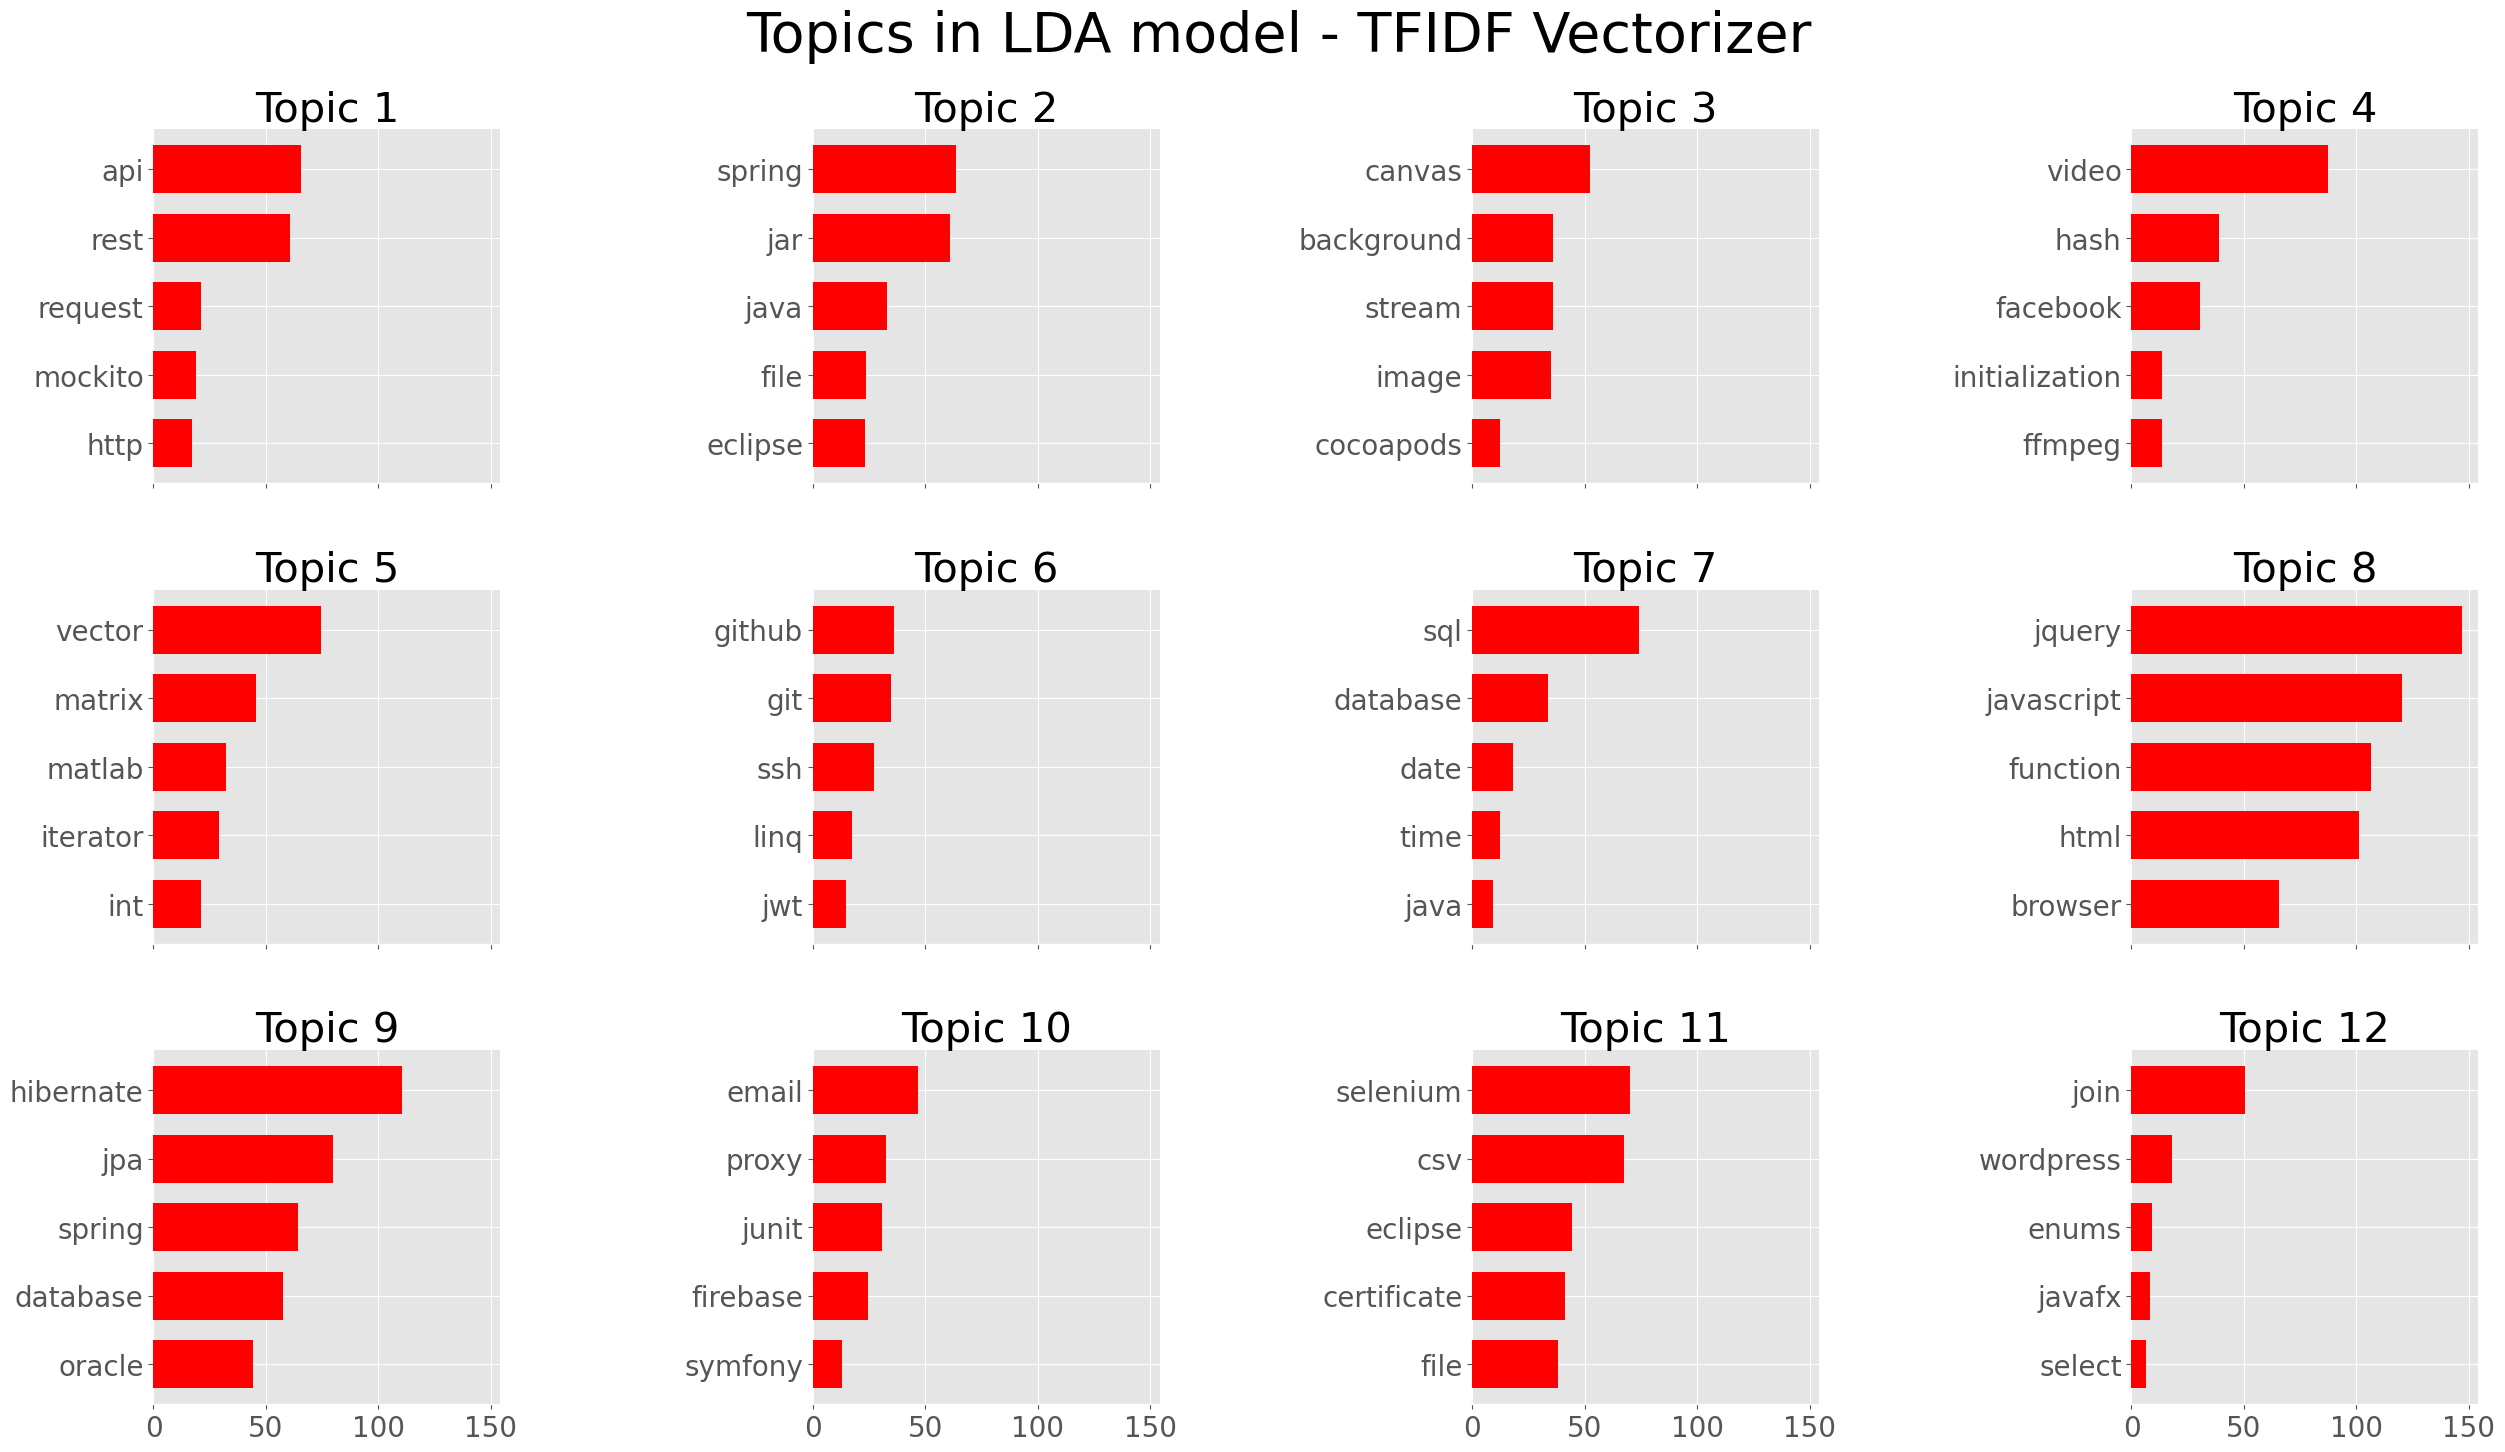

In [28]:
lda = LatentDirichletAllocation(n_components=n_topics_LDA, max_iter=5,
                                random_state=42).fit(tfidf)

plot_top_words(lda, TFIDF_feature_names, n_top_words, n_top_topics,
               'Topics in LDA model - TFIDF Vectorizer', 'red')

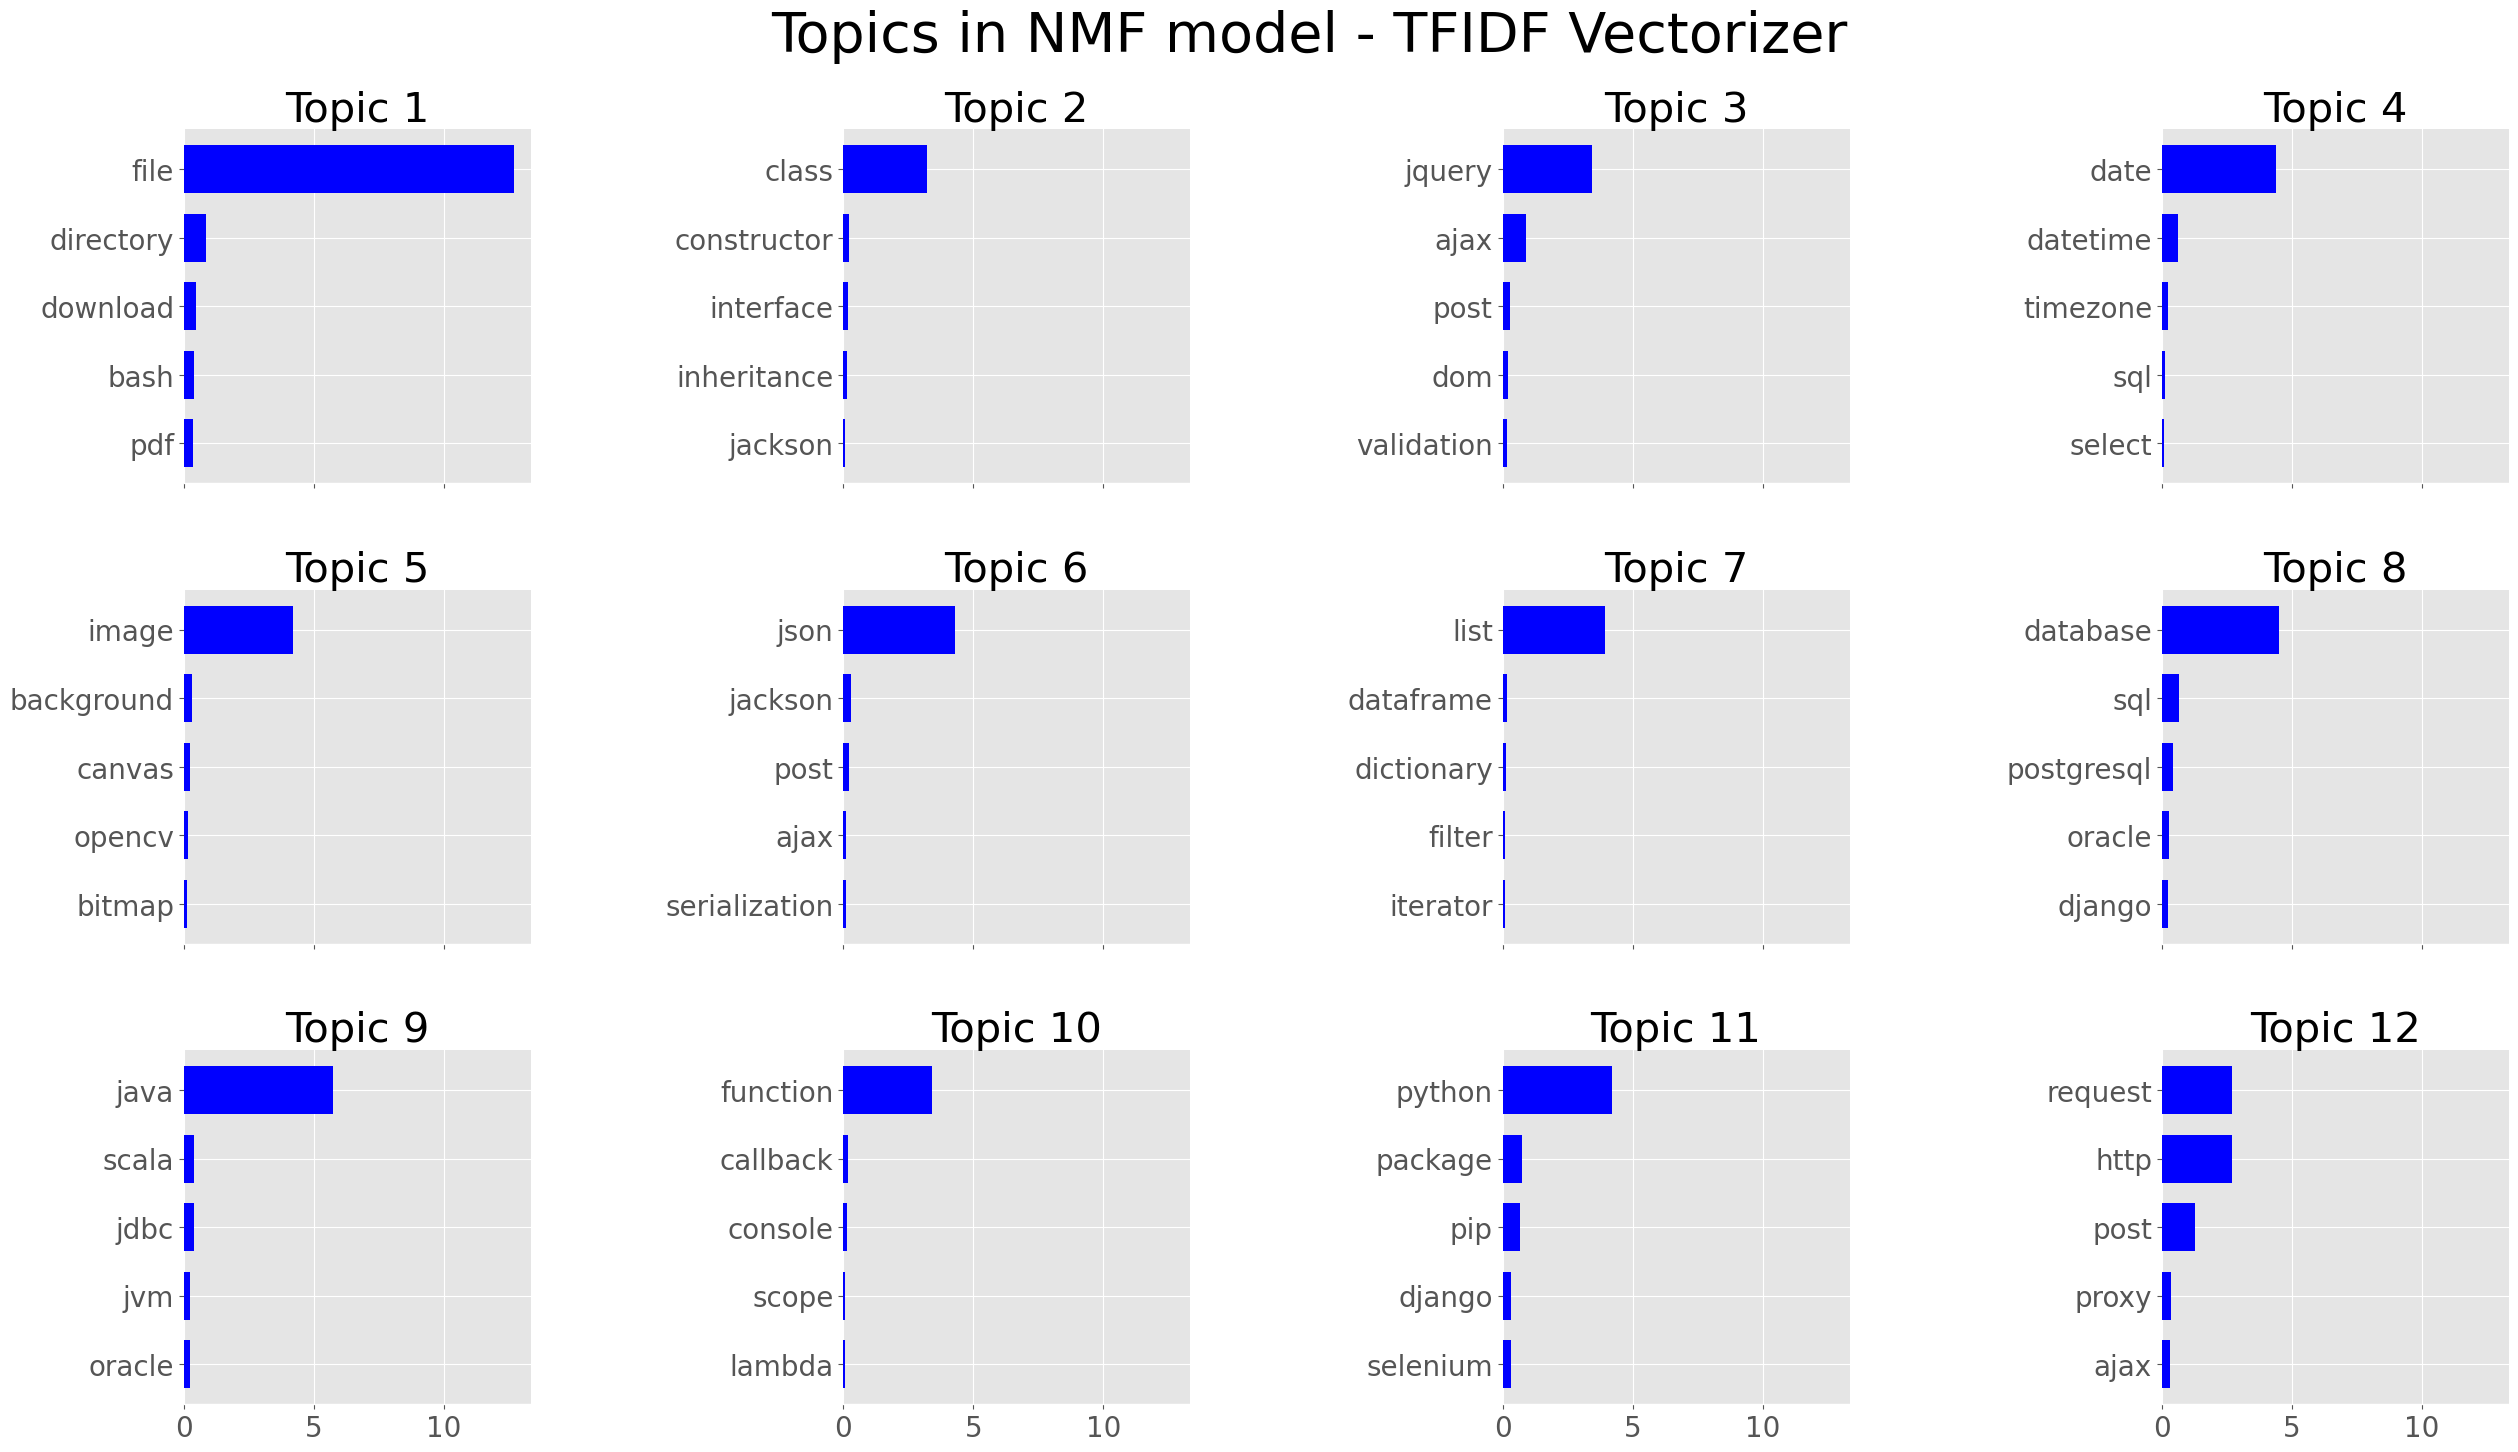

In [28]:
nmf = NMF(n_components=n_topics_NMF, random_state=42).fit(tfidf)

plot_top_words(nmf, TFIDF_feature_names, n_top_words, n_top_topics,
               'Topics in NMF model - TFIDF Vectorizer', 'blue')

### Visualisation TSNE des topics (2D)

In [29]:
def plot_top_words_tsne(lda_vcv, lda_tfidf, nmf_vcv, nmf_tfidf):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    axs = axs.ravel()

    # LDA with vcv
    X_embedded = TSNE(n_components=2).fit_transform(lda_vcv)
    axs[0].scatter(X_embedded[:, 0], X_embedded[:, 1], c=lda_vcv.argmax(axis=1))
    axs[0].set_title("LDA with vcv")
    
    # LDA with tfidf
    X_embedded = TSNE(n_components=2).fit_transform(lda_tfidf)
    axs[1].scatter(X_embedded[:, 0], X_embedded[:, 1], c=lda_tfidf.argmax(axis=1))
    axs[1].set_title("LDA with tfidf")
    
    # NMF with vcv
    X_embedded = TSNE(n_components=2).fit_transform(nmf_vcv)
    axs[2].scatter(X_embedded[:, 0], X_embedded[:, 1], c=nmf_vcv.argmax(axis=1))
    axs[2].set_title("NMF with vcv")
    
    # NMF with tfidf
    X_embedded = TSNE(n_components=2).fit_transform(nmf_tfidf)
    axs[3].scatter(X_embedded[:, 0], X_embedded[:, 1], c=nmf_tfidf.argmax(axis=1))
    axs[3].set_title("NMF with tfidf")
    
    plt.show()

In [30]:
lda_vcv = LatentDirichletAllocation(n_components=n_topics_LDA, max_iter=5, random_state=42).fit_transform(vcv)
lda_tfidf = LatentDirichletAllocation(n_components=n_topics_LDA, max_iter=5, random_state=42).fit_transform(tfidf)
nmf_vcv = NMF(n_components=n_topics_NMF, random_state=42).fit_transform(vcv)
nmf_tfidf = NMF(n_components=n_topics_NMF, random_state=42).fit_transform(tfidf)

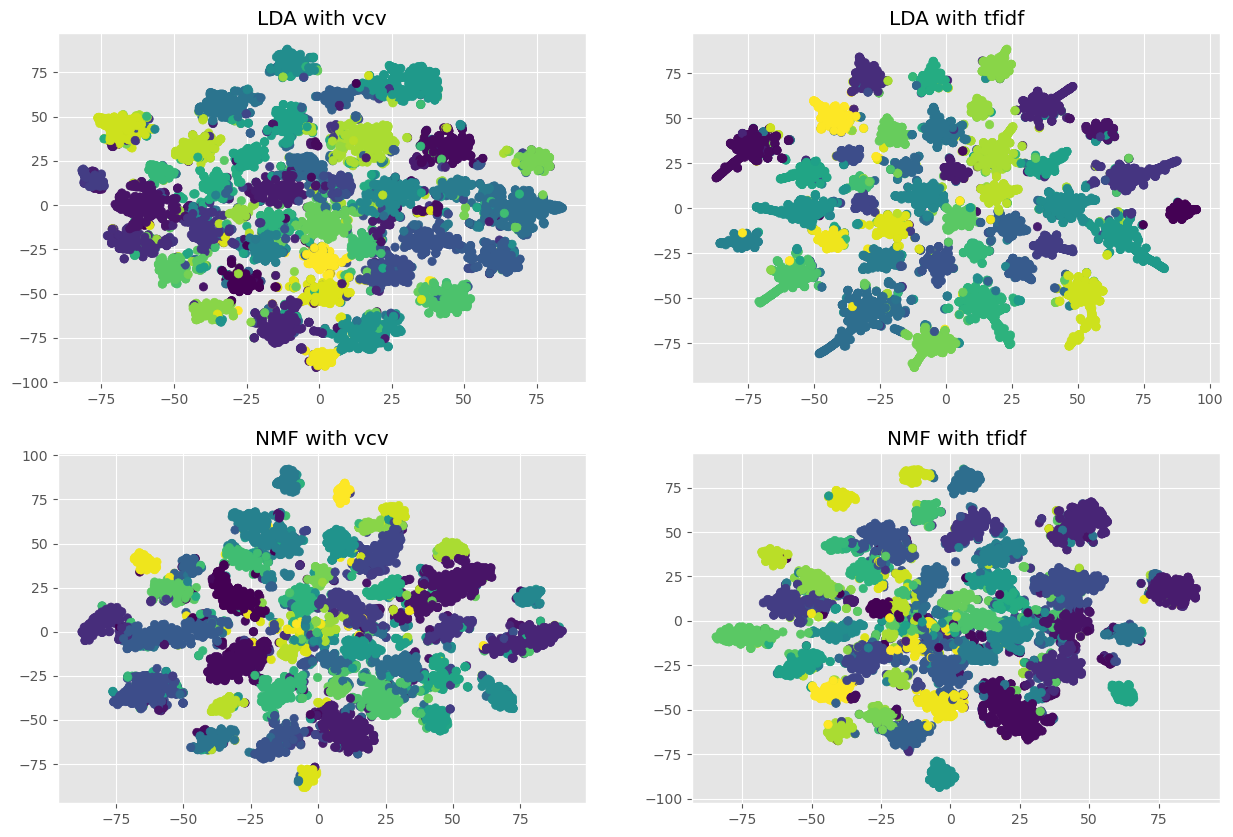

In [31]:
plot_top_words_tsne(lda_vcv, lda_tfidf, nmf_vcv, nmf_tfidf)

### Génération des tags avec CountVectorizer et TF-IDF

In [32]:
data_sample["Sentences"][0]

'python json boolean to lowercase string is there a best-practice for outputting booleans in python? i\'m generating some json (via django templates), and by default all the boolean values are output with leading character in uppercase, contrary to the json standard (ie, "true" as opposed to "true"). currently, i format each boolean string using str.lower(), but is there a better way?'

In [33]:
tags_list[0:5]

[['android', 'android-layout', 'android-activity', 'view'],
 ['cocoa-touch', 'uiview', 'uiviewcontroller', 'uinavigationcontroller'],
 ['java', 'eclipse', 'memory', 'junit'],
 ['sql', 'sql-server', 'tsql', 'join'],
 ['c++', 'c', 'memory', 'struct', 'types']]

In [34]:
def get_tags_from_text(flat_texts):
    pred_tfidf = list()
    pred_cv = list()

    # Predict tags using TF-IDF
    vectorizer = vectorizer_TFIDF
    bow = vectorizer.fit_transform(flat_texts)
    for i in range(len(flat_texts)):
        dense_bow_matrix = bow.toarray()
        top_words_indices = dense_bow_matrix[i].argsort()[-5:][::-1]
        topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
        pred_tfidf.append(topic_words)

    # Predict tags using CountVectorizer
    vectorizer = vectorizer_CV
    bow = vectorizer.fit_transform(flat_texts)
    for i in range(len(flat_texts)):
        dense_bow_matrix = bow.toarray()
        top_words_indices = dense_bow_matrix[i].argsort()[-5:][::-1]
        topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
        pred_cv.append(topic_words)

    return pred_tfidf, pred_cv

In [35]:
pred_tfidf, pred_cv = get_tags_from_text(flat_texts)

In [36]:
pred_tfidf[0:5]

[['class', 'view', 'layout', 'null', 'android'],
 ['uinavigationcontroller', 'uiviewcontroller', 'view', 'uiview', 'button'],
 ['junit', 'build', 'memory', 'java', 'file'],
 ['date', 'join', 'sql', 'view', 'casting'],
 ['int', 'struct', 'memory', 'tomcat', 'casting']]

In [37]:
pred_cv[0:5]

[['class', 'view', 'android', 'layout', 'null'],
 ['view', 'uinavigationcontroller', 'uiviewcontroller', 'uiview', 'button'],
 ['junit', 'build', 'memory', 'java', 'file'],
 ['date', 'join', 'sql', 'view', 'casting'],
 ['int', 'memory', 'struct', 'tomcat', 'casting']]

### Génération des tags avec LDA et NMF

In [38]:
lda_v = LatentDirichletAllocation(n_components=n_topics_LDA, max_iter=5, random_state=42).fit(vcv)
lda_t = LatentDirichletAllocation(n_components=n_topics_LDA, max_iter=5, random_state=42).fit(tfidf)
nmf_v = NMF(n_components=n_topics_NMF, random_state=42).fit(vcv)
nmf_t = NMF(n_components=n_topics_NMF, random_state=42).fit(tfidf)

In [39]:
def get_top_tags(sentences, feature_names, model, vectorizer):
    tags = []
    for i, sentence in tqdm(enumerate(sentences), ascii=' >='):
        sentence_vector = vectorizer.transform([sentence])
        topic_weights = model.transform(sentence_vector)
        top_topics = topic_weights.argmax()
        top_tags = [feature_names[i] for i in model.components_[top_topics].argsort()[:-6:-1]]
        tags.append(top_tags)
    return tags

In [40]:
lda_vcv_tags = get_top_tags(flat_texts, CV_feature_names, lda_v, vectorizer_CV)
lda_vcv_tags[0:5]

8000it [00:02, 3335.83it/s]


[['class', 'matrix', 'object', 'inheritance', 'reference'],
 ['view', 'xcode', 'io', 'swift', 'iphone'],
 ['eclipse', 'jar', 'java', 'junit', 'class'],
 ['date', 'video', 'datetime', 'timezone', 'time'],
 ['int', 'gcc', 'heroku', 'security', 'clang']]

In [41]:
lda_tfidf_tags = get_top_tags(flat_texts, TFIDF_feature_names, lda_t, vectorizer_TFIDF)
lda_tfidf_tags[0:5]

8000it [00:03, 2010.75it/s]


[['android', 'iframe', 'layout', 'xml', 'groovy'],
 ['view', 'vector', 'gcc', 'swift', 'clang'],
 ['jar', 'datetime', 'junit', 'eclipse', 'java'],
 ['date', 'time', 'video', 'datetime', 'integer'],
 ['int', 'heroku', 'security', 'reference', 'java']]

In [42]:
nmf_vcv_tags = get_top_tags(flat_texts, CV_feature_names, nmf_v, vectorizer_CV)
nmf_vcv_tags[0:5]

8000it [00:04, 1642.57it/s]


[['view', 'model', 'animation', 'listview', 'django'],
 ['view', 'model', 'animation', 'listview', 'django'],
 ['memory', 'process', 'jvm', 'docker', 'dll'],
 ['date', 'datetime', 'timezone', 'select', 'sql'],
 ['int', 'struct', 'gcc', 'boost', 'integer']]

In [43]:
nmf_tfidf_tags = get_top_tags(flat_texts, TFIDF_feature_names, nmf_t, vectorizer_TFIDF)
nmf_tfidf_tags[0:5]

8000it [00:07, 1136.88it/s]


[['class', 'constructor', 'interface', 'inheritance', 'jackson'],
 ['view', 'animation', 'model', 'scroll', 'django'],
 ['memory', 'performance', 'process', 'jvm', 'linux'],
 ['date', 'datetime', 'timezone', 'sql', 'select'],
 ['int', 'gcc', 'struct', 'integer', 'clang']]

### Évaluation des prédictions de tags

 - F1 Score: mesure de l'exactitude d'un modèle, il est un moyen harmonique de précision et de rappel. Il varie de 0 à 1, où un score proche de 1 indique une meilleure performance et un score proche de 0 indique une performance moins bonne. 
 - Jaccard Score: mesure de la similarité entre les deux ensembles de prédictions et de vraies étiquettes. Il varie de 0 à 1, où un score proche de 1 indique une très grande similitude et un score proche de 0 indique une grande dissimilarité.

In [44]:
pred_tags_list = [pred_tfidf, pred_cv, lda_vcv_tags, lda_tfidf_tags, nmf_vcv_tags, nmf_tfidf_tags]
pred_names = ["Tfidf", "CV", "LDA CV", "LDA Tfidf", "NMF CV", "NMF Tfidf"]
pred_tags_bin_list = [mlb.transform(pred_tags) for pred_tags in pred_tags_list]

In [45]:
def evaluate_predictions(true_tags, pred_tags_bin_list, pred_names):
    f1_scores = []
    jaccard_scores = []
    scoring_methods = ["F1 Score", "Jaccard Score"]
    for pred_tags in pred_tags_bin_list:
        f1_scores.append(f1_score(true_tags, pred_tags, average='samples'))
        jaccard_scores.append(jaccard_score(true_tags, pred_tags, average='samples'))

    metrics = {"Jaccard": jaccard_scores, "F1": f1_scores}
    metrics_df = pd.DataFrame(metrics, index=pred_names)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes = axes.ravel()
    for i, metric in enumerate(metrics.keys()):
        sns.barplot(data=metrics_df, x=metrics_df.index, y=metric, ax=axes[i])
        axes[i].set_ylabel('Score')
        axes[i].set_title(scoring_methods[i])
    plt.show()
    return metrics_df.T

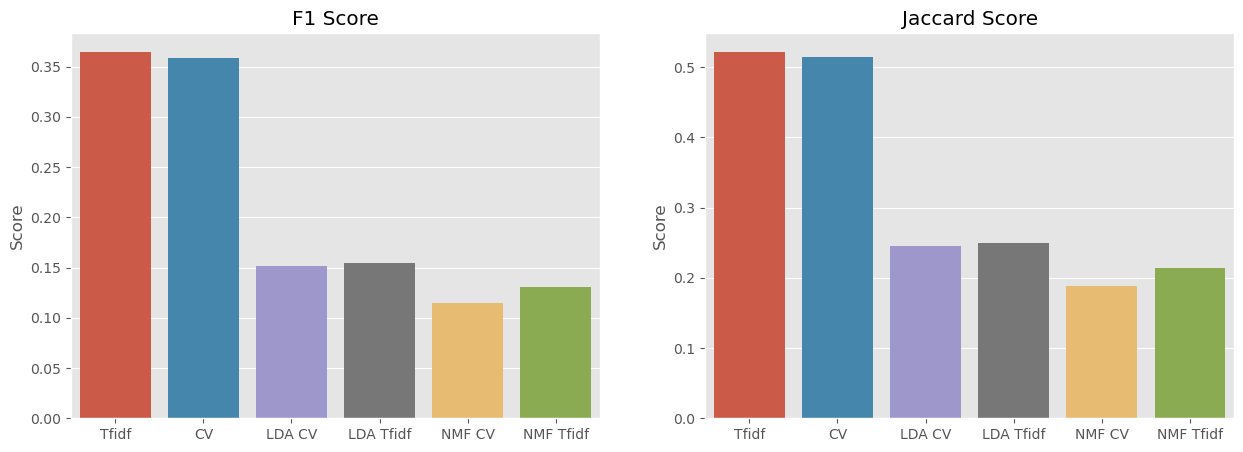

Tfidf        CV    LDA CV  LDA Tfidf    NMF CV  NMF Tfidf
Jaccard  0.364997  0.358176  0.151832   0.155031  0.114410   0.130868
F1       0.521986  0.514614  0.245508   0.250233  0.188992   0.214389

In [46]:
evaluate_predictions(tags_mlb, pred_tags_bin_list, pred_names)

Nous observons de meilleurs scores avec simplement un vectorizer.

Je vais essayer de faire varier le nombre de topics afin d'améliorer les modèles avec LDA et NMF.

In [47]:
def evaluate_topic_model(model, vectorizer, num_topics_range, texts, true_tags):
    X = vectorizer.fit_transform(texts)
    best_topics = 0
    best_score = 0
    pred_tags_ = []
    for num_topics in num_topics_range:
        model_obj = model.set_params(n_components=num_topics)
        model_obj.fit(X)
        pred_tags = get_top_tags(texts, vectorizer.get_feature_names(), model_obj, vectorizer)
        pred_tags_bin = mlb.transform(pred_tags)
        score = f1_score(true_tags, pred_tags_bin, average='samples')
        if score < best_score:
            break
        if score > best_score:
            best_score = score
            best_topics = num_topics
            pred_tags_ = pred_tags
    return best_topics, best_score, pred_tags_


def get_top_tags_parallel(sentence, feature_names, model, vectorizer):
    sentence_vector = vectorizer.transform([sentence])
    topic_weights = model.transform(sentence_vector)
    top_topics = topic_weights.argmax()
    top_tags = [feature_names[i] for i in model.components_[top_topics].argsort()[:-6:-1]]
    return top_tags


def get_top_tags(sentences, feature_names, model, vectorizer):
    tags = Parallel(n_jobs=-1)(delayed(get_top_tags_parallel)(sentence, feature_names, model, vectorizer) for sentence in sentences)
    return tags

In [48]:
n_components_range = range(200, 500, 70)
best_num_topics = {}

# LDA with CountVectorizer
lda_model = LatentDirichletAllocation(max_iter=10, random_state=42)
best_topics, best_score, lda_vcv_tags = evaluate_topic_model(lda_model, vectorizer_CV, n_components_range, flat_texts, tags_mlb)
best_num_topics['LatentDirichletAllocation + count'] = best_topics, round(best_score, 2)

# LDA with TfidfVectorizer
lda_model = LatentDirichletAllocation(max_iter=10, random_state=42)
best_topics, best_score, lda_tfidf_tags = evaluate_topic_model(lda_model, vectorizer_TFIDF, n_components_range, flat_texts, tags_mlb)
best_num_topics['LatentDirichletAllocation + tfidf'] = best_topics, round(best_score, 2)

# # NMF with CountVectorizer
# nmf_model = NMF(max_iter=5, random_state=42)
# best_topics, best_score, nmf_vcv_tags = evaluate_topic_model(nmf_model, vectorizer_CV, n_components_range, flat_texts, tags_mlb)
# best_num_topics['NMF + count'] = best_topics, round(best_score, 2)

# # NMF with TfidfVectorizer
# nmf_model = NMF(max_iter=5, random_state=42)
# best_topics, best_score, nmf_tfidf_tags = evaluate_topic_model(nmf_model, vectorizer_TFIDF, n_components_range, flat_texts, tags_mlb)
# best_num_topics['NMF + tfidf'] = best_topics, round(best_score, 2)

In [49]:
best_num_topics

{'LatentDirichletAllocation + count': (270, 0.28),
 'LatentDirichletAllocation + tfidf': (200, 0.19)}

In [50]:
pred_tags_list = [pred_tfidf, pred_cv, lda_vcv_tags, lda_tfidf_tags, nmf_vcv_tags, nmf_tfidf_tags]
pred_names = ["Tfidf", "CV", "LDA CV", "LDA Tfidf", "NMF CV", "NMF Tfidf"]
pred_tags_bin_list = [mlb.transform(pred_tags) for pred_tags in pred_tags_list]

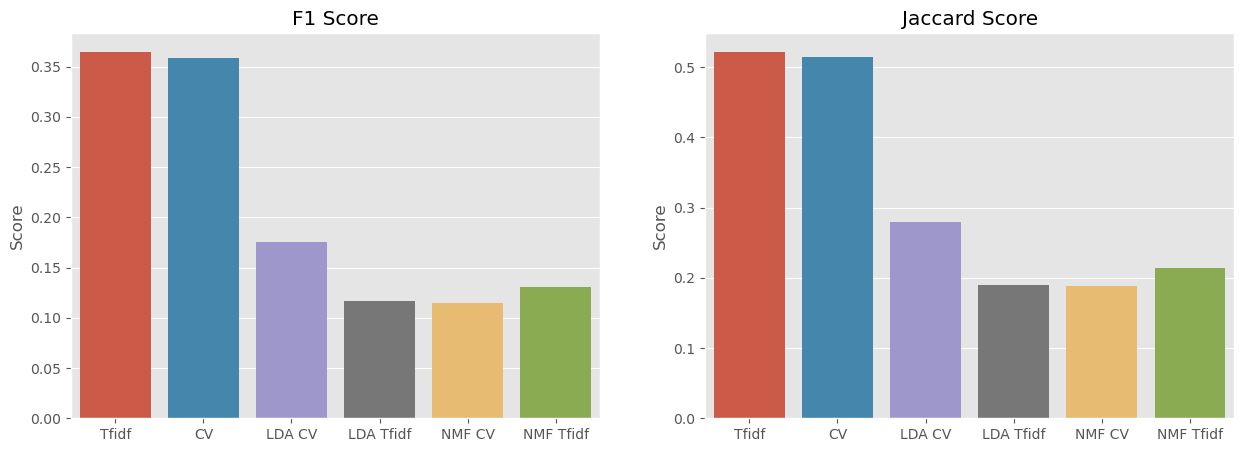

Tfidf        CV    LDA CV  LDA Tfidf    NMF CV  NMF Tfidf
Jaccard  0.364997  0.358176  0.175966   0.116312  0.114410   0.130868
F1       0.521986  0.514614  0.279053   0.189758  0.188992   0.214389

In [51]:
evaluate_predictions(tags_mlb, pred_tags_bin_list, pred_names)

La LDA avec CV est bien améliorée par rapport aux 3 autres modèles.

In [52]:
def jaccard_index(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    if not s1 and not s2:
        return 0
    return len(s1 & s2) / len(s1 | s2)


def calculate_scores(true_tags, pred_tags):
    scores = [jaccard_index(t, p) for t, p in zip(true_tags, pred_tags)]
    mean_score = sum(scores) / len(scores)
    return mean_score


def jaccard_index_mod(list1, list2):
    """ 
    Fonction jaccard_index modifiée
    La division ne se fait pas sur l'union des deux sets
    mais par le nombre de tags prédits (list2)
    afin de ne pas pénaliser les scores des observations
    avec moins de 5 tags
    """
    s1 = set(list1)
    s2 = set(list2)
    if not s1 or not s2:
        return 0
    return len(s1 & s2) / min(len(s1),len(s2))


def calculate_scores_mod(tags_list, pred_tags):
    scores = [jaccard_index_mod(t, p) for t, p in zip(tags_list, pred_tags)]
    mean_score = sum(scores) / len(scores)
    return mean_score


def plot_similar_tags(tags_list, pred_tags, method):
    
    mean_score = calculate_scores(tags_list, pred_tags)
    mean_score_mod = calculate_scores_mod(tags_list, pred_tags)
    similar_counts = []
    for pred_tags, tags_list in zip(pred_tags, tags_list):
        similar_words = set(pred_tags) & set(tags_list)
        similar_counts.append(len(similar_words))

    counter = Counter(similar_counts)
    counter = dict(sorted(counter.items()))

    keys = set(range(0, 6))
    missing_keys = keys - set(counter.keys())
    for key in missing_keys:
        counter[key] = 0
    sorted_counter = dict(sorted(counter.items()))

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"Similarité des tags avec la méthode {method}", fontsize=14,
                 fontweight='bold', y=1.05)
    axs[0].bar(sorted_counter.keys(), sorted_counter.values())
    axs[0].set_xticks(range(0, 6, 1))
    axs[0].set_xticklabels(sorted_counter.keys(), rotation=0)
    axs[0].set_xlabel('Nombre de tags similaires', fontsize=11)
    axs[0].set_ylabel("Nombre d'observations", fontsize=11)
    axs[0].set_title("Nombre d'observations avec un\n"
                     "nombre de tags similaires", fontsize=12)
    axs[1].pie(sorted_counter.values(), labels=sorted_counter.keys(),
               autopct='%1.1f%%', pctdistance=0.8)
    axs[1].legend(title='Tags\nSimilaires', bbox_to_anchor=(1, 0.9), prop={'size': 8},
                 title_fontsize=10)
    axs[1].set_title("Pourcentage d'observations avec \n"
                     "un nombre de tags similaires", fontsize=12)

    textstr = f'Jaccard_index = {mean_score:.2f}\nJaccard_index_mod = {mean_score_mod:.2f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axs[1].text(0.8, 0, textstr, transform=axs[1].transAxes, fontsize=12,
                verticalalignment='top', bbox=props)

    plt.show()

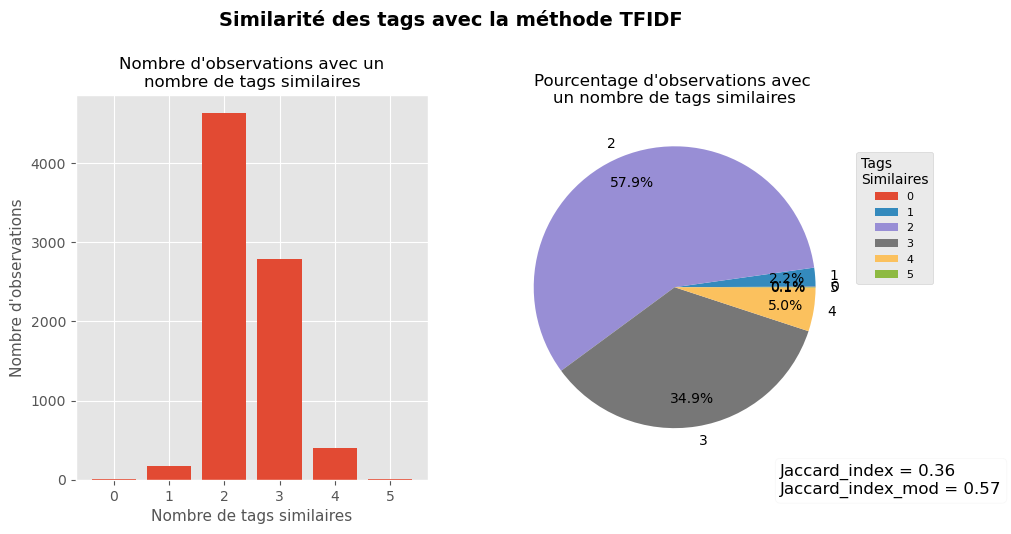

In [53]:
plot_similar_tags(tags_list, pred_tfidf, 'TFIDF')

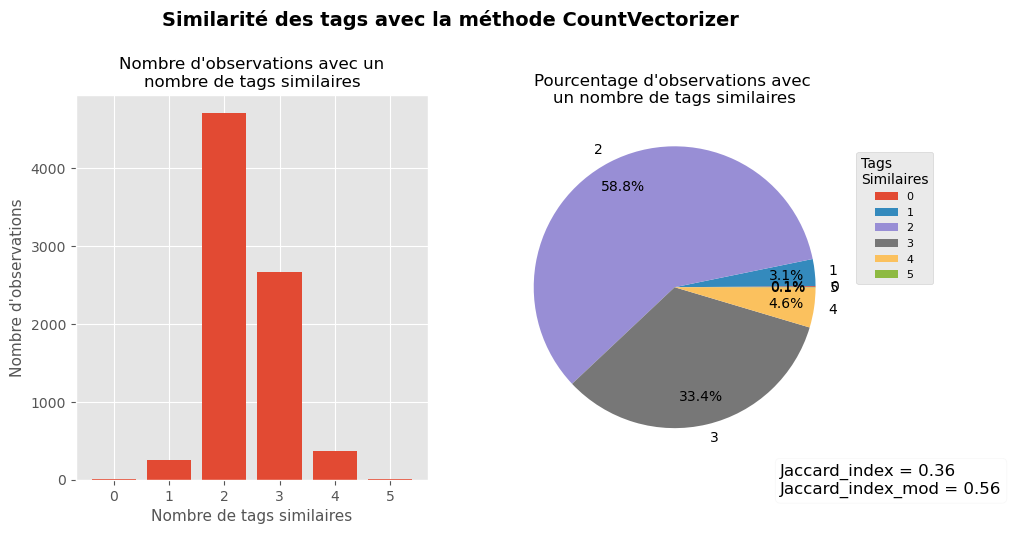

In [54]:
plot_similar_tags(tags_list, pred_cv, 'CountVectorizer')

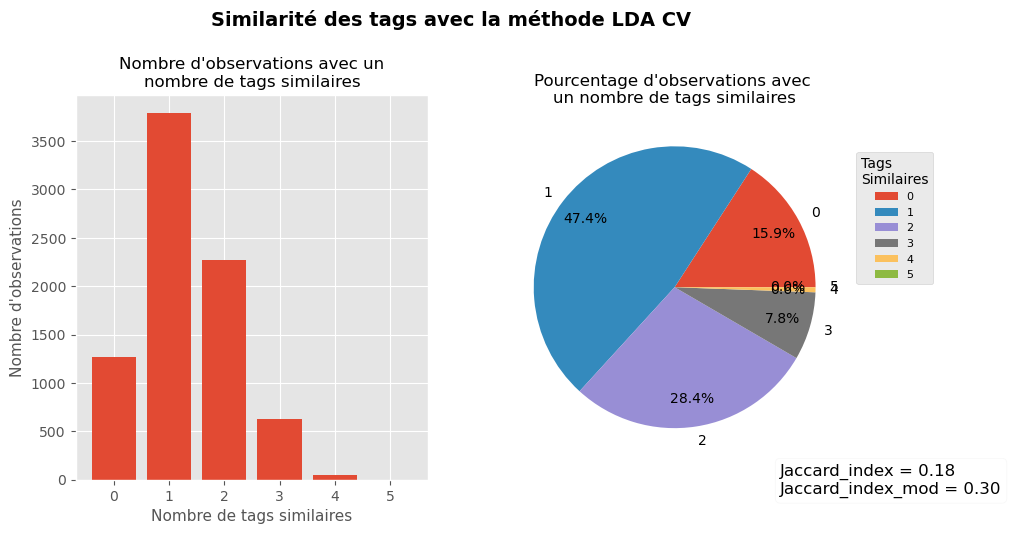

In [55]:
plot_similar_tags(tags_list, lda_vcv_tags, 'LDA CV')

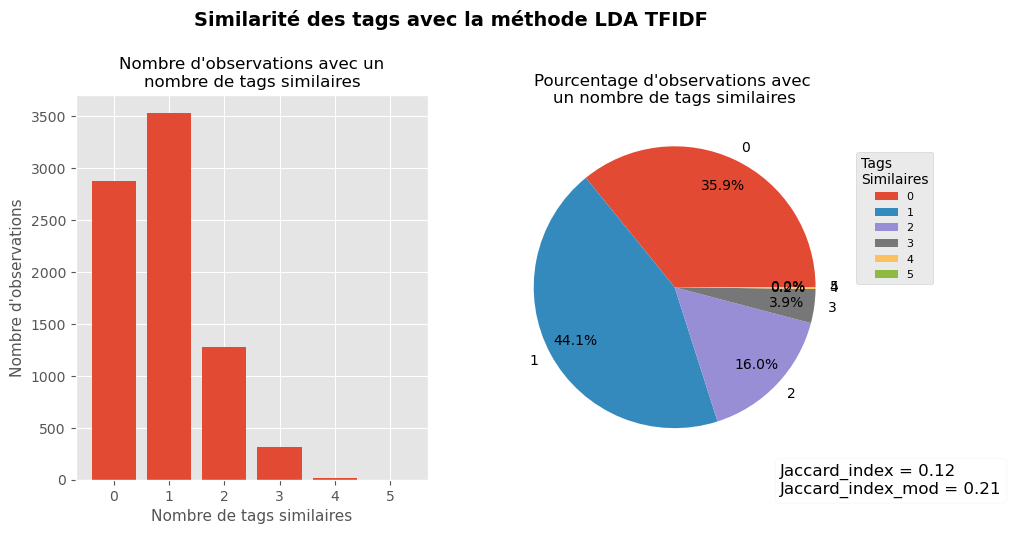

In [56]:
plot_similar_tags(tags_list, lda_tfidf_tags, 'LDA TFIDF')

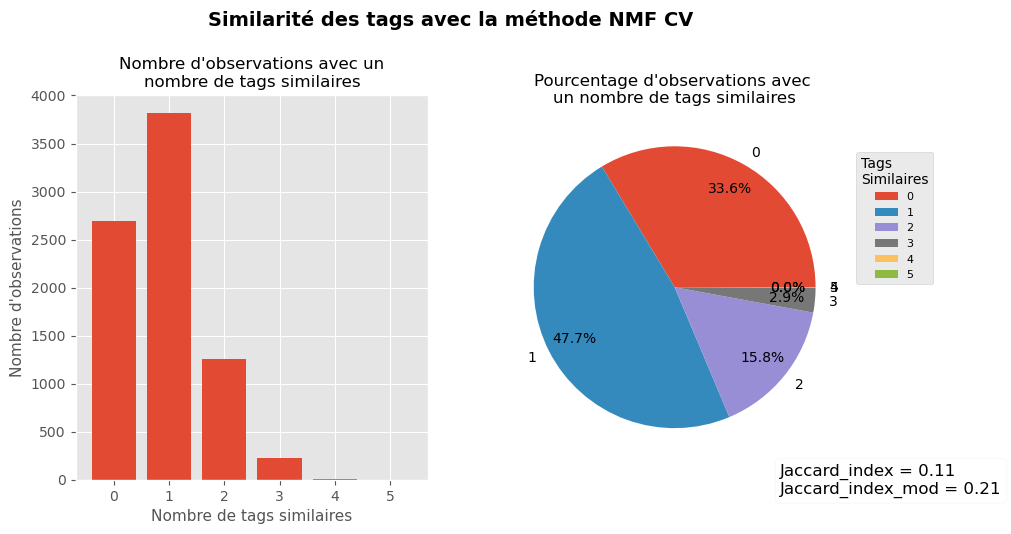

In [57]:
plot_similar_tags(tags_list, nmf_vcv_tags, 'NMF CV')

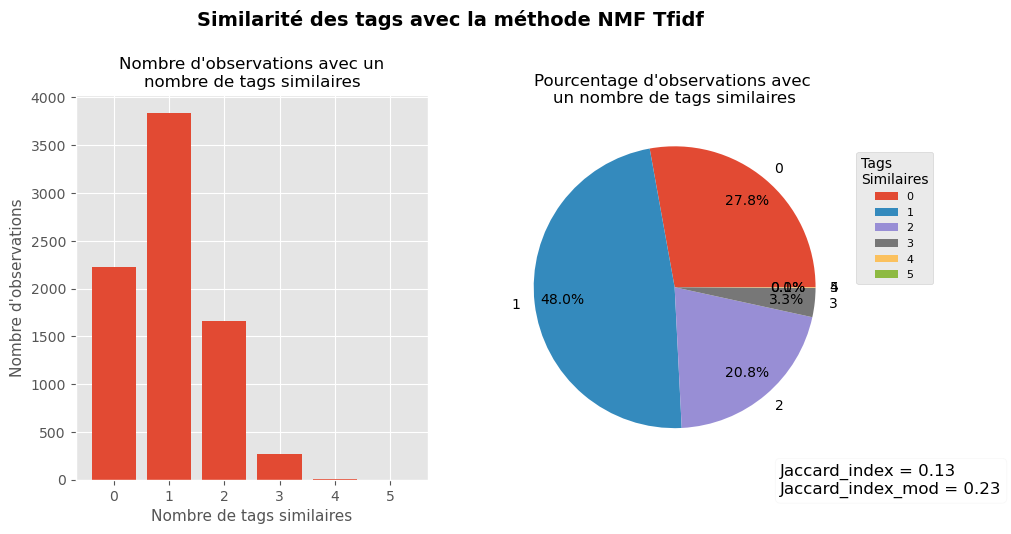

In [58]:
plot_similar_tags(tags_list, nmf_tfidf_tags, 'NMF Tfidf')

## <font color="#114b98" id="section_3">3. Approche non supervisée : RAKE</font>

In [59]:
from rake_nltk import Rake

In [60]:
def extract_keywords(input_text, new_sentences):
    all_keywords = []
    text = input_text + new_sentences
    # Encode all the sentences in the input text
    for i in tqdm(range(len(text)), ascii=' >='):
        # Extract the keywords from the new sentence using RAKE
        keyword_extractor = Rake()
        keyword_extractor.extract_keywords_from_text(text[i])
        word_degrees = keyword_extractor.get_word_degrees()
        sorted_word_degrees = sorted(word_degrees.items(), key=lambda x: x[1], reverse=True)
        keywords = [word for word, degree in sorted_word_degrees[:5]]
        all_keywords.append(keywords)
    return all_keywords[-len(new_sentences):]

In [61]:
rake_keywords = extract_keywords(flat_texts, flat_texts_eval)

100%|==========================================================================| 10000/10000 [00:02<00:00, 3362.97it/s]


In [62]:
rake_keywords[0:5]

[['java', 'stream', 'list'],
 ['object', 'memory', 'performance', 'reference', 'java'],
 ['html', 'iframe', 'javascript', 'browser'],
 ['selenium', 'ruby', 'webdriver', 'class', 'web'],
 ['date', 'datetime', 'string', 'text', 'null']]

In [63]:
tags_list_eval[0:5]

[['java', 'list', 'lambda', 'java-8', 'java-stream'],
 ['java', 'performance', 'caching', 'memory', 'garbage-collection'],
 ['javascript', 'html', 'css', 'ajax', 'iframe'],
 ['ruby', 'selenium', 'selenium-webdriver', 'webdriver'],
 ['c#', 'datetime', 'time', 'date']]

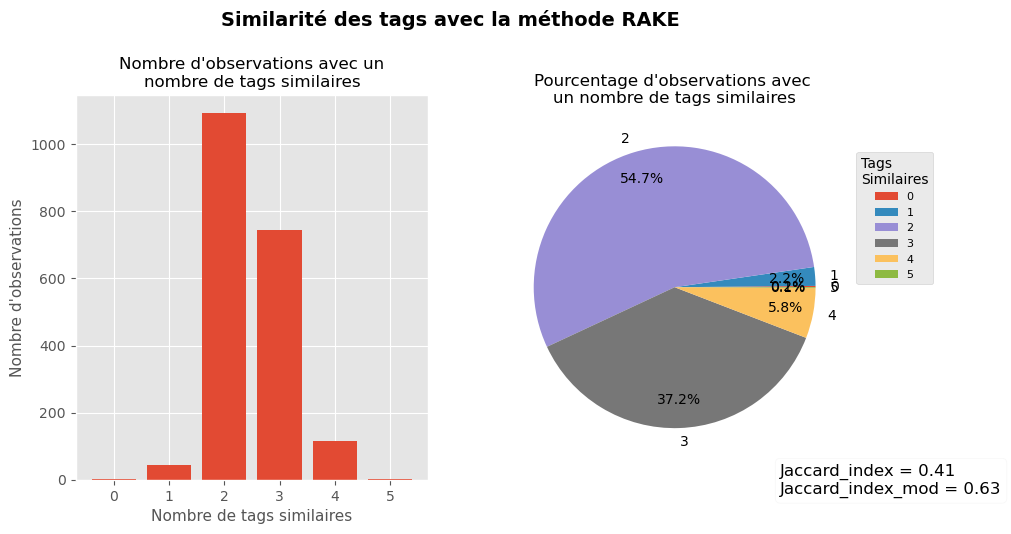

In [64]:
plot_similar_tags(tags_list_eval, rake_keywords, 'RAKE')

## <font color="#114b98" id="section_4">4. Approche supervisée : Classifiers</font>

### Étude avec 5 classificateurs sklearn

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

In [66]:
classifiers = [LogisticRegression(random_state=42, max_iter=300, tol=1e-5),
               SGDClassifier(random_state=42, max_iter=300, tol=1e-5),
               KNeighborsClassifier(),
               MultinomialNB()]

In [67]:
def supervised_scores(flat_texts, tags_mlb, vectorizer, classifiers):

    # Create an empty dataframe to store the results
    results_df = pd.DataFrame(columns=['Classifier',
                                       'F1 Score',
                                       'Jaccard Score'])

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(flat_texts, tags_mlb, test_size=0.2, random_state=42)

    # Vectorize X_train and X_test
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Fit an independent model for each class using the OneVsRestClassifier wrapper.
    for classifier in tqdm(classifiers, ascii=' >='):
        ovrc = OneVsRestClassifier(classifier)
        ovrc.fit(X_train, y_train)
        y_pred_ovrc = ovrc.predict(X_test)

        f1 = round(f1_score(y_test, y_pred_ovrc, average='samples'), 4)
        jaccard = round(jaccard_score(y_test, y_pred_ovrc, average='samples'), 4)

        results_df = results_df.append({'Classifier': str(classifier).split('(')[0], 
                                        'F1 Score': f1,
                                        'Jaccard Score': jaccard},
                                        ignore_index=True)

    return results_df

In [68]:
results_CountVectorizer = supervised_scores(flat_texts,
                                            tags_mlb,
                                            vectorizer_CV,
                                            classifiers)
results_CountVectorizer

100%|====================================================================================| 4/4 [01:40<00:00, 25.21s/it]


Classifier  F1 Score  Jaccard Score
0    LogisticRegression    0.5728         0.4375
1         SGDClassifier    0.5820         0.4391
2  KNeighborsClassifier    0.4090         0.2939
3         MultinomialNB    0.3483         0.2256

In [69]:
def plot_results(results_df):
    
    # Create a figure with 5 subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # Set a color palette
    my_palette = sns.color_palette("husl", 5)

    # Set the x-axis to be a range of numerical values
    x = range(len(results_df))
    scoring_methods = ['F1 Score', 'Jaccard Score']

    # Create a subplot for each scoring method
    for i, scoring_method in enumerate(scoring_methods):
        sns.barplot(x='Classifier', 
                    y=scoring_method, 
                    data=results_df, 
                    ax=axs[i], 
                    palette=my_palette, 
                    label=scoring_method)

    # Add classifier names to x-axis
    for i in range(2):
        axs[i].set_title(scoring_methods[i])
        axs[i].set_xticks(x)
        axs[i].set_xlabel('')
        axs[i].set_ylabel('Score')
        axs[i].set_xticklabels(results_df['Classifier'], rotation=90)

    plt.show()

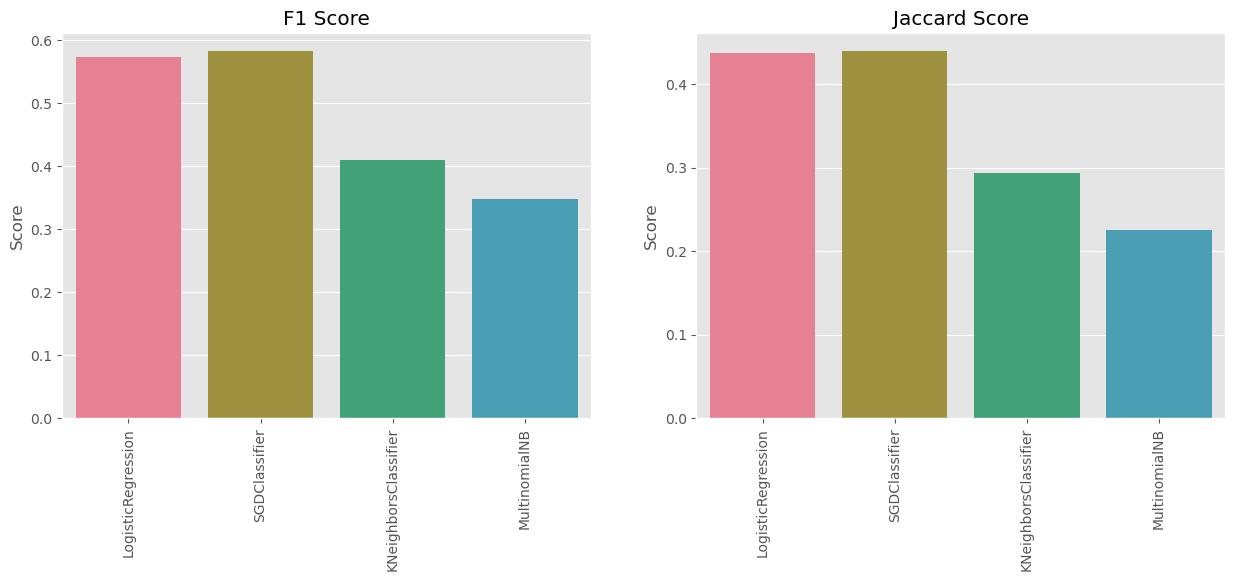

In [70]:
plot_results(results_CountVectorizer)

In [71]:
results_TfidfVectorizer = supervised_scores(flat_texts,
                                            tags_mlb,
                                            vectorizer_TFIDF,
                                            classifiers)
results_TfidfVectorizer

100%|====================================================================================| 4/4 [01:33<00:00, 23.33s/it]


Classifier  F1 Score  Jaccard Score
0    LogisticRegression    0.4865         0.3590
1         SGDClassifier    0.6251         0.4843
2  KNeighborsClassifier    0.4697         0.3437
3         MultinomialNB    0.2995         0.2092

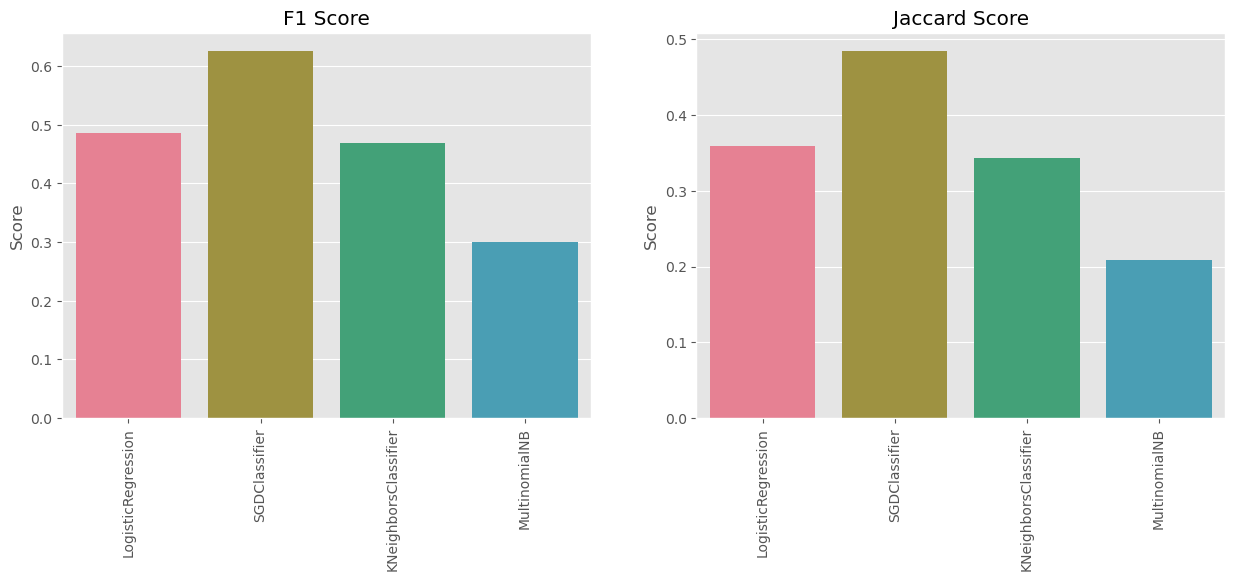

In [72]:
plot_results(results_TfidfVectorizer)

Le SGDClassifier obtient des très bons scores, peu importe le vectorizer utilisé.

### SGDClassifier + GridSearchCV

In [73]:
results_SGD = pd.DataFrame(columns=['F1 Score', 'Jaccard Score'])
results_SGD = results_SGD.append(results_CountVectorizer.iloc[1, 1:]).reset_index(drop=True)
results_SGD = results_SGD.append(results_TfidfVectorizer.iloc[1, 1:]).reset_index(drop=True)
results_SGD['Classifier'] = ['CountVectorizer', 'TfidfVectorizer']
results_SGD

F1 Score  Jaccard Score       Classifier
0    0.5820         0.4391  CountVectorizer
1    0.6251         0.4843  TfidfVectorizer

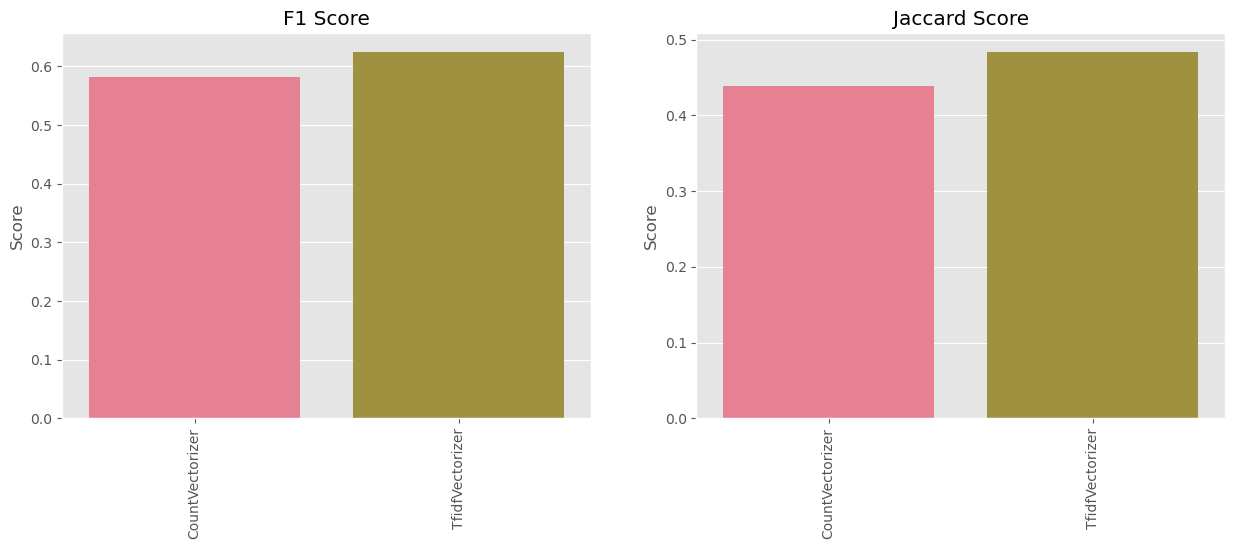

In [74]:
plot_results(results_SGD)

TF-IDF permet d'avoir des performances légèrement supérieures à CountVectorizer.

In [75]:
classifier_SGD = SGDClassifier(random_state=42)

parameters_SGD = {'estimator__alpha': [0.001, 0.01],
                  'estimator__loss': ['log_loss', 'hinge'],
                  'estimator__penalty': ['l2']} 

Cet estimateur implémente des modèles linéaires régularisés avec l'apprentissage par descente de gradient stochastique (SGD)

'hinge' fournit un SVM linéaire.

'log_loss' fournit une régression logistique

In [76]:
def calc_scores(flat_texts, tags_mlb, vectorizer, classifier, parameters):
    results_df = pd.DataFrame(columns=['Classifier', 'F1 Score', 'Jaccard Score'])
    X_train, X_test, y_train, y_test = train_test_split(flat_texts, tags_mlb, test_size=0.2, random_state=42)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    ovrc = OneVsRestClassifier(classifier)
    clf = GridSearchCV(ovrc, parameters, cv=5, verbose=1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    best_params = clf.best_params_ if hasattr(clf, 'best_params_') else None
    
    f1 = round(f1_score(y_test, y_pred, average='samples'), 4)
    jaccard = round(jaccard_score(y_test, y_pred, average='samples'), 4)
    
    results_df = results_df.append({'Classifier': str(classifier).split('(')[0], 
                                    'F1 Score': f1,
                                    'Jaccard Score': jaccard},
                                    ignore_index=True)
    return results_df, best_params

In [77]:
results_SGD, best_params_SGD = calc_scores(flat_texts,
                                           tags_mlb,
                                           vectorizer_TFIDF,
                                           classifier_SGD,
                                           parameters_SGD)
results_SGD

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Classifier  F1 Score  Jaccard Score
0  SGDClassifier     0.481         0.3528

In [78]:
best_params_SGD

{'estimator__alpha': 0.001,
 'estimator__loss': 'hinge',
 'estimator__penalty': 'l2'}

In [79]:
params_SGDC = {key.replace('estimator__', ''): value for key, value in best_params_SGD.items()}

classifier = SGDClassifier(random_state=42, **params_SGDC)

ovrc_SGDC = OneVsRestClassifier(classifier)

X_train, X_test, y_train, y_test = train_test_split(flat_texts,
                                                    tags_mlb,
                                                    test_size=0.2,
                                                    random_state=42)
X_train = vectorizer_TFIDF.fit_transform(X_train)
ovrc_SGDC.fit(X_train, y_train)

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, random_state=42))

In [80]:
X_test_ = vectorizer_CV.transform(X_test)
y_pred_SGDC = ovrc_SGDC.predict(X_test_)

tags_SGDC = mlb.inverse_transform(y_pred_SGDC)
tags_SGDC[0:5]

[('html', 'ipad', 'video', 'firefox', 'css', 'ios', 'javascript', 'iphone'),
 ('background',
  'html',
  'ipad',
  'browser',
  'image-processing',
  'button',
  'xaml',
  'css',
  'xcode',
  'ios',
  'image',
  'ajax',
  'jquery'),
 ('python', 'matplotlib', 'plot'),
 ('function', 'javascript', 'jquery'),
 ('api', 'selenium-webdriver', 'rest', 'javascript', 'selenium')]

In [81]:
true_tags_clf = mlb.inverse_transform(y_test)
true_tags_clf[0:5]

[('safari', 'ipad', 'mobile-safari', 'iphone'),
 ('ipad', 'xcode', 'ios', 'image'),
 ('colors', 'python', 'matplotlib', 'plot'),
 ('function', 'oop', 'if-statement', 'javascript'),
 ('jestjs', 'testing', 'javascript', 'selenium')]

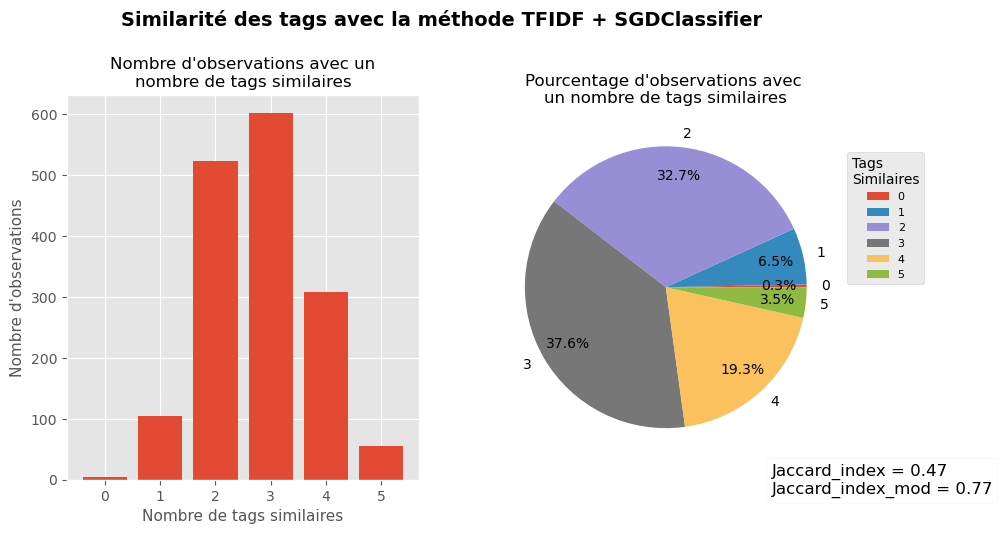

In [82]:
plot_similar_tags(true_tags_clf, tags_SGDC, 'TFIDF + SGDClassifier')

### LogisticRegression + GridSearchCV

In [193]:
classifier_LR = LogisticRegression(random_state=42)

parameters_LR = {'estimator__penalty': ['l1', 'l2'],
                 'estimator__C': [0.1, 1, 10],
                 'estimator__solver': ['lbfgs', 'liblinear'],
                 'estimator__max_iter': [100, 300],
                 'estimator__tol': [1e-3, 1e-4, 1e-5]}

results_LR, best_params_LR = calc_scores(flat_texts,
                                         tags_mlb,
                                         vectorizer_CV,
                                         classifier_LR,
                                         parameters_LR)
results_LR

Fitting 5 folds for each of 72 candidates, totalling 360 fits


Classifier  F1 Score  Jaccard Score
0  LogisticRegression    0.6018         0.4635

In [194]:
best_params_LR

{'estimator__C': 1,
 'estimator__max_iter': 100,
 'estimator__penalty': 'l1',
 'estimator__solver': 'liblinear',
 'estimator__tol': 0.0001}

In [195]:
params_LR = {key.replace('estimator__', ''): value for key, value in best_params_LR.items()}

classifier = LogisticRegression(random_state=42, **params_LR)

ovrc_LR = OneVsRestClassifier(classifier)

X_train, X_test, y_train, y_test = train_test_split(flat_texts,
                                                    tags_mlb,
                                                    test_size=0.2,
                                                    random_state=42)
X_train = vectorizer_CV.fit_transform(X_train)
ovrc_LR.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1, penalty='l1',
                                                 random_state=42,
                                                 solver='liblinear'))

In [196]:
X_test_ = vectorizer_CV.transform(X_test)
y_pred_LR = ovrc_LR.predict(X_test_)

tags_LR = mlb.inverse_transform(y_pred_LR)
tags_LR[0:5]

[('html', 'ipad', 'video', 'firefox', 'css', 'iphone'),
 ('xcode', 'ios', 'image'),
 ('python', 'matplotlib', 'plot'),
 ('javascript',),
 ('api', 'javascript', 'selenium')]

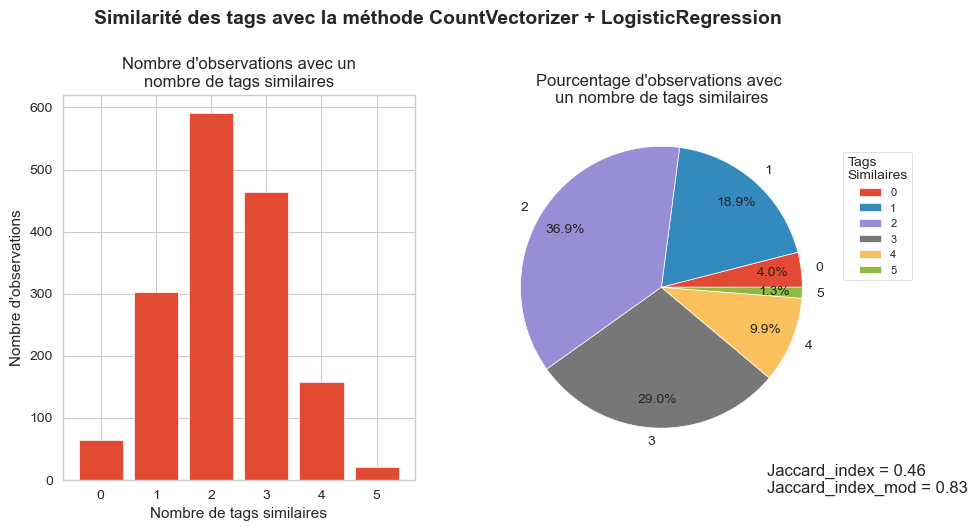

In [197]:
plot_similar_tags(true_tags_clf, tags_LR, 'CountVectorizer + LogisticRegression')

## <font color="#114b98" id="section_5">5. Approche supervisée : Doc2Vec</font>

### Étude D2V

In [87]:
import multiprocessing
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from tensorflow.keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalMaxPooling1D
from keras.utils.vis_utils import plot_model

In [88]:
tagged_data = [TaggedDocument(words=sent, tags=[str(i)]) for i, sent in enumerate(texts_list)]
d2v_model = Doc2Vec(tagged_data, vector_size=100, window=2, min_count=1, workers=4)
sentence_vectors = [d2v_model.infer_vector(sent) for sent in texts_list]
similar_sentences = [d2v_model.docvecs.most_similar([vec], topn=5) for vec in sentence_vectors]
pred_tags_d2v = [[texts_list[int(index)][0] for index, similarity in sim_sents] for sim_sents in similar_sentences]
pred_tags_d2v[0:5]

[['android', 'view', 'layout', 'view', 'uiscrollview'],
 ['uiview', 'wpf', 'uiview', 'view', 'io'],
 ['junit', 'build', 'jenkins', 'performance', 'memory'],
 ['date', 'date', 'join', 'sql', 'sql'],
 ['memory', 'memory', 'memory', 'struct', 'memory']]

In [89]:
tags_list[0:5]

[['android', 'android-layout', 'android-activity', 'view'],
 ['cocoa-touch', 'uiview', 'uiviewcontroller', 'uinavigationcontroller'],
 ['java', 'eclipse', 'memory', 'junit'],
 ['sql', 'sql-server', 'tsql', 'join'],
 ['c++', 'c', 'memory', 'struct', 'types']]

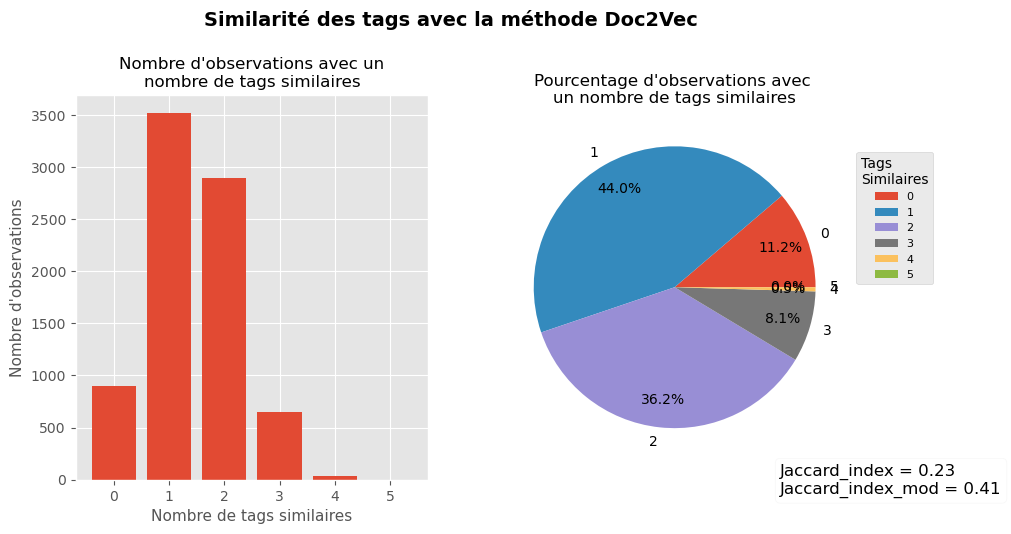

In [90]:
plot_similar_tags(tags_list, pred_tags_d2v, 'Doc2Vec')

### D2V + MLP

In [91]:
encoded_sentences = np.array([d2v_model.docvecs[sent.tags[0]] for sent in tagged_data])

train_sentences, test_sentences, train_tags, test_tags = train_test_split(
    encoded_sentences,
    tags_mlb,
    test_size=0.3,
    random_state=42
)

test_sentences, val_sentences , test_tags, val_tags = train_test_split(
    test_sentences,
    test_tags,
    test_size=0.5,
    random_state=42
)

d2v_nn_model = Sequential([
    Dense(512, activation='relu', input_shape=(100,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')
])

d2v_nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

d2v_nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [92]:
# plot_model(d2v_nn_model, to_file='d2v_nn_model.png', show_shapes=True)

In [93]:
history = d2v_nn_model.fit(train_sentences, train_tags, verbose=1, 
                           epochs=150, batch_size=32, 
                           validation_data=(val_sentences, val_tags),
                           workers=multiprocessing.cpu_count())

Epoch 1/150
175/175 [==============================] - 2s 3ms/step - loss: 0.5766 - accuracy: 0.0084 - val_loss: 0.2180 - val_accuracy: 0.0167
Epoch 2/150
175/175 [==============================] - 0s 2ms/step - loss: 0.1114 - accuracy: 0.1004 - val_loss: 0.0499 - val_accuracy: 0.1683
Epoch 3/150
175/175 [==============================] - 0s 2ms/step - loss: 0.0533 - accuracy: 0.1179 - val_loss: 0.0430 - val_accuracy: 0.1608
Epoch 4/150
175/175 [==============================] - 0s 2ms/step - loss: 0.0470 - accuracy: 0.1170 - val_loss: 0.0417 - val_accuracy: 0.1658
Epoch 5/150
175/175 [==============================] - 0s 2ms/step - loss: 0.0449 - accuracy: 0.1287 - val_loss: 0.0409 - val_accuracy: 0.1592
Epoch 6/150
175/175 [==============================] - 0s 2ms/step - loss: 0.0438 - accuracy: 0.1261 - val_loss: 0.0402 - val_accuracy: 0.1475
Epoch 7/150
175/175 [==============================] - 0s 2ms/step - loss: 0.0429 - accuracy: 0.1312 - val_loss: 0.0395 - val_accuracy: 0.1508

Epoch 58/150
175/175 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.1523 - val_loss: 0.0275 - val_accuracy: 0.1867
Epoch 59/150
175/175 [==============================] - 0s 2ms/step - loss: 0.0295 - accuracy: 0.1427 - val_loss: 0.0274 - val_accuracy: 0.1725
Epoch 60/150
175/175 [==============================] - 0s 2ms/step - loss: 0.0296 - accuracy: 0.1514 - val_loss: 0.0273 - val_accuracy: 0.1708
Epoch 61/150
175/175 [==============================] - 0s 2ms/step - loss: 0.0295 - accuracy: 0.1464 - val_loss: 0.0272 - val_accuracy: 0.1625
Epoch 62/150
175/175 [==============================] - 0s 2ms/step - loss: 0.0295 - accuracy: 0.1536 - val_loss: 0.0273 - val_accuracy: 0.1617
Epoch 63/150
175/175 [==============================] - 0s 2ms/step - loss: 0.0296 - accuracy: 0.1498 - val_loss: 0.0272 - val_accuracy: 0.1675
Epoch 64/150
175/175 [==============================] - 0s 2ms/step - loss: 0.0294 - accuracy: 0.1577 - val_loss: 0.0274 - val_accuracy:

Epoch 115/150
175/175 [==============================] - 0s 2ms/step - loss: 0.0277 - accuracy: 0.1520 - val_loss: 0.0264 - val_accuracy: 0.1750
Epoch 116/150
175/175 [==============================] - 0s 2ms/step - loss: 0.0276 - accuracy: 0.1586 - val_loss: 0.0264 - val_accuracy: 0.1742
Epoch 117/150
175/175 [==============================] - 0s 2ms/step - loss: 0.0276 - accuracy: 0.1598 - val_loss: 0.0263 - val_accuracy: 0.1758
Epoch 118/150
175/175 [==============================] - 0s 2ms/step - loss: 0.0275 - accuracy: 0.1591 - val_loss: 0.0263 - val_accuracy: 0.1608
Epoch 119/150
175/175 [==============================] - 0s 2ms/step - loss: 0.0274 - accuracy: 0.1641 - val_loss: 0.0264 - val_accuracy: 0.1617
Epoch 120/150
175/175 [==============================] - 0s 2ms/step - loss: 0.0275 - accuracy: 0.1566 - val_loss: 0.0262 - val_accuracy: 0.1692
Epoch 121/150
175/175 [==============================] - 0s 2ms/step - loss: 0.0274 - accuracy: 0.1518 - val_loss: 0.0264 - val_ac

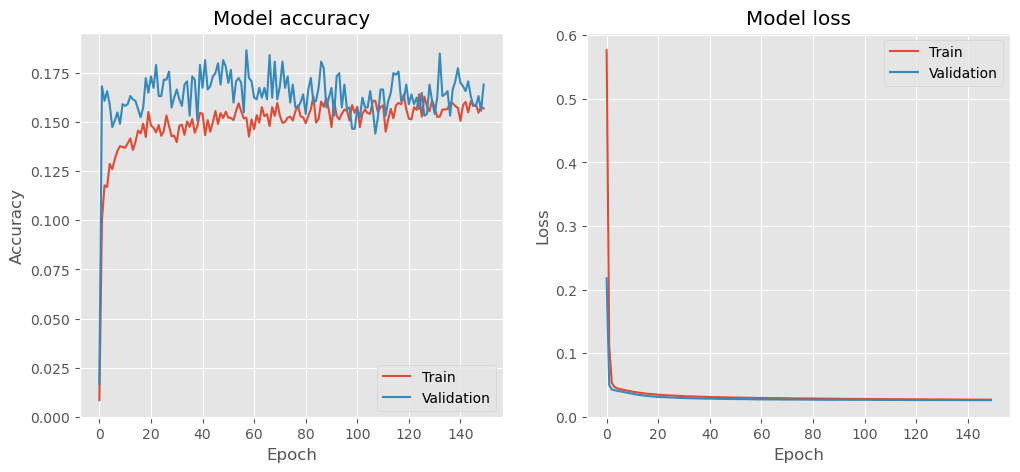

In [94]:
def plot_epochs(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='lower right')
    
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper right')
    
    plt.show()

plot_epochs(history)

In [95]:
pred_probs_d2v_500_nn = d2v_nn_model.predict(test_sentences)

38/38 [==============================] - 0s 920us/step


In [96]:
pred_tags_d2v_500_nn = []
for word_probs in pred_probs_d2v_500_nn:
    top_indexes = word_probs.argsort()[-5:][::-1]
    pred_tags_d2v_500_nn.append([mlb.classes_[i] for i in top_indexes])
pred_tags_d2v_500_nn[0:5]

[['boost', 'c++', 'gcc', 'clang', 'c++11'],
 ['java', 'sql', 'jdbc', 'mysql', 'oracle'],
 ['java', 'android', 'eclipse', 'android-studio', 'layout'],
 ['c++', 'dll', 'class', 'linux', 'c'],
 ['linux', 'bash', 'shell', 'path', 'git']]

In [97]:
tags_list_dv = mlb.inverse_transform(test_tags)
tags_list_dv[0:5]

[('linker', 'c++', 'eclipse', 'regex', 'boost'),
 ('java', 'jdbc', 'sql-server-2005', 'sql-server'),
 ('java', 'eclipse', 'unit-testing', 'testing', 'debugging'),
 ('function', 'linker', 'dll', 'c++', 'windows'),
 ('git', 'node.js', 'path', 'macos')]

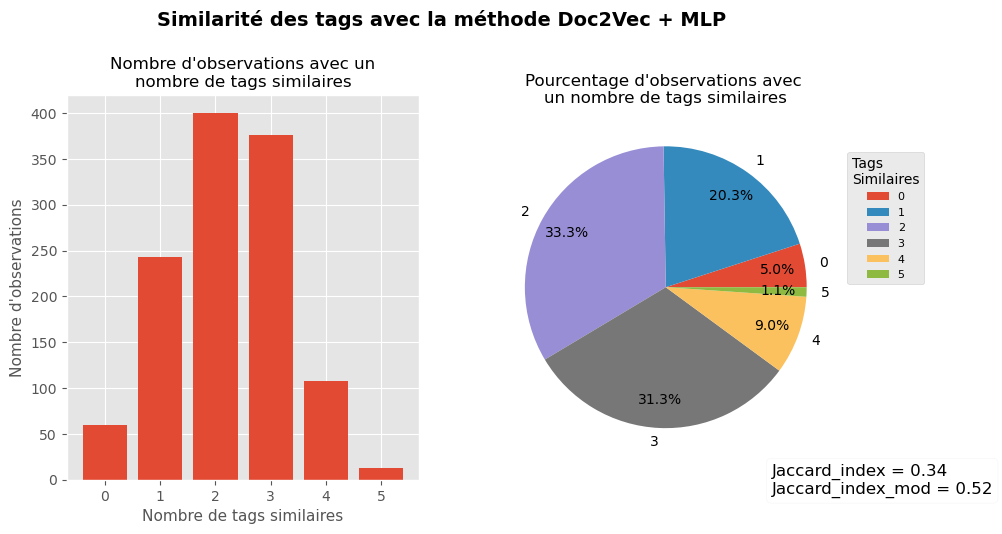

In [98]:
plot_similar_tags(tags_list_dv, pred_tags_d2v_500_nn, 'Doc2Vec + MLP')

### D2V + CNN

In [99]:
d2v_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(100, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')
])

d2v_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

d2v_cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 98, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 23, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 1472)              0         
                                                                 
 dense_5 (Dense)             (None, 128)              

In [100]:
history = d2v_cnn_model.fit(train_sentences, train_tags, verbose=1, 
                            epochs=150, batch_size=32, 
                            validation_data=(val_sentences, val_tags),
                            workers=multiprocessing.cpu_count())

Epoch 1/150
175/175 [==============================] - 1s 4ms/step - loss: 0.1220 - accuracy: 0.0475 - val_loss: 0.0436 - val_accuracy: 0.1717
Epoch 2/150
175/175 [==============================] - 1s 3ms/step - loss: 0.0469 - accuracy: 0.0780 - val_loss: 0.0431 - val_accuracy: 0.1717
Epoch 3/150
175/175 [==============================] - 1s 3ms/step - loss: 0.0455 - accuracy: 0.0905 - val_loss: 0.0427 - val_accuracy: 0.1717
Epoch 4/150
175/175 [==============================] - 1s 4ms/step - loss: 0.0448 - accuracy: 0.1095 - val_loss: 0.0431 - val_accuracy: 0.1717
Epoch 5/150
175/175 [==============================] - 1s 3ms/step - loss: 0.0446 - accuracy: 0.1239 - val_loss: 0.0428 - val_accuracy: 0.1717
Epoch 6/150
175/175 [==============================] - 1s 4ms/step - loss: 0.0444 - accuracy: 0.1296 - val_loss: 0.0431 - val_accuracy: 0.1717
Epoch 7/150
175/175 [==============================] - 1s 3ms/step - loss: 0.0443 - accuracy: 0.1289 - val_loss: 0.0430 - val_accuracy: 0.1717

Epoch 58/150
175/175 [==============================] - 1s 3ms/step - loss: 0.0282 - accuracy: 0.1625 - val_loss: 0.0290 - val_accuracy: 0.1892
Epoch 59/150
175/175 [==============================] - 1s 3ms/step - loss: 0.0281 - accuracy: 0.1575 - val_loss: 0.0292 - val_accuracy: 0.1825
Epoch 60/150
175/175 [==============================] - 1s 4ms/step - loss: 0.0280 - accuracy: 0.1571 - val_loss: 0.0289 - val_accuracy: 0.1908
Epoch 61/150
175/175 [==============================] - 1s 3ms/step - loss: 0.0279 - accuracy: 0.1513 - val_loss: 0.0285 - val_accuracy: 0.1883
Epoch 62/150
175/175 [==============================] - 1s 3ms/step - loss: 0.0278 - accuracy: 0.1618 - val_loss: 0.0286 - val_accuracy: 0.1792
Epoch 63/150
175/175 [==============================] - 1s 3ms/step - loss: 0.0277 - accuracy: 0.1566 - val_loss: 0.0293 - val_accuracy: 0.1867
Epoch 64/150
175/175 [==============================] - 1s 4ms/step - loss: 0.0277 - accuracy: 0.1637 - val_loss: 0.0288 - val_accuracy:

Epoch 115/150
175/175 [==============================] - 1s 3ms/step - loss: 0.0239 - accuracy: 0.1625 - val_loss: 0.0300 - val_accuracy: 0.1825
Epoch 116/150
175/175 [==============================] - 1s 3ms/step - loss: 0.0236 - accuracy: 0.1650 - val_loss: 0.0295 - val_accuracy: 0.1850
Epoch 117/150
175/175 [==============================] - 1s 4ms/step - loss: 0.0237 - accuracy: 0.1693 - val_loss: 0.0308 - val_accuracy: 0.1850
Epoch 118/150
175/175 [==============================] - 1s 3ms/step - loss: 0.0236 - accuracy: 0.1680 - val_loss: 0.0311 - val_accuracy: 0.1825
Epoch 119/150
175/175 [==============================] - 1s 3ms/step - loss: 0.0237 - accuracy: 0.1657 - val_loss: 0.0304 - val_accuracy: 0.1900
Epoch 120/150
175/175 [==============================] - 1s 3ms/step - loss: 0.0236 - accuracy: 0.1696 - val_loss: 0.0300 - val_accuracy: 0.1850
Epoch 121/150
175/175 [==============================] - 1s 4ms/step - loss: 0.0235 - accuracy: 0.1682 - val_loss: 0.0301 - val_ac

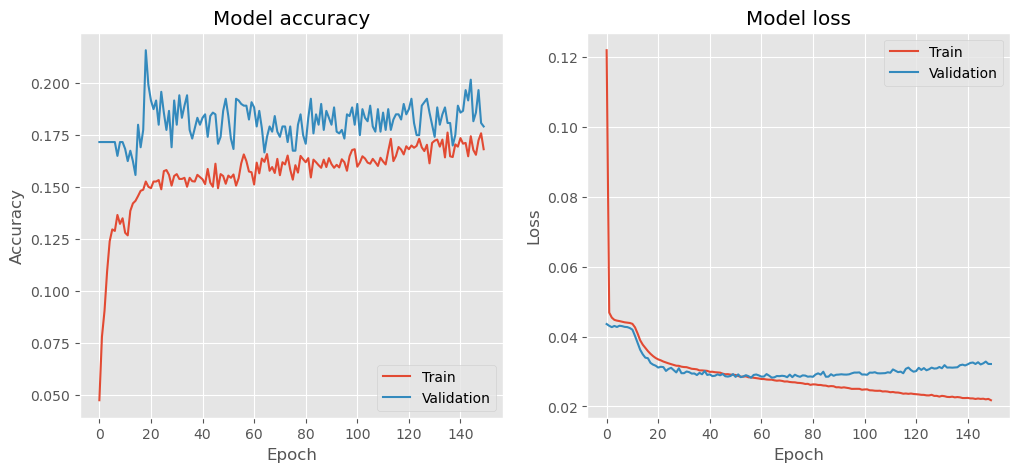

In [101]:
plot_epochs(history)

In [102]:
pred_probs_d2v_500_cnn = d2v_cnn_model.predict(test_sentences)

38/38 [==============================] - 0s 1ms/step


In [103]:
pred_tags_d2v_500_cnn = []
for word_probs in pred_probs_d2v_500_cnn:
    top_indexes = word_probs.argsort()[-5:][::-1]
    pred_tags_d2v_500_cnn.append([mlb.classes_[i] for i in top_indexes])
pred_tags_d2v_500_cnn[0:5]

[['boost', 'c++', 'gcc', 'c++11', 'c'],
 ['java', 'jdbc', 'sql', 'postgresql', 'mysql'],
 ['java', 'spring', 'c#', 'android', 'view'],
 ['dll', 'c++', 'java', 'c', 'function'],
 ['path', 'bash', 'python', 'linux', 'shell']]

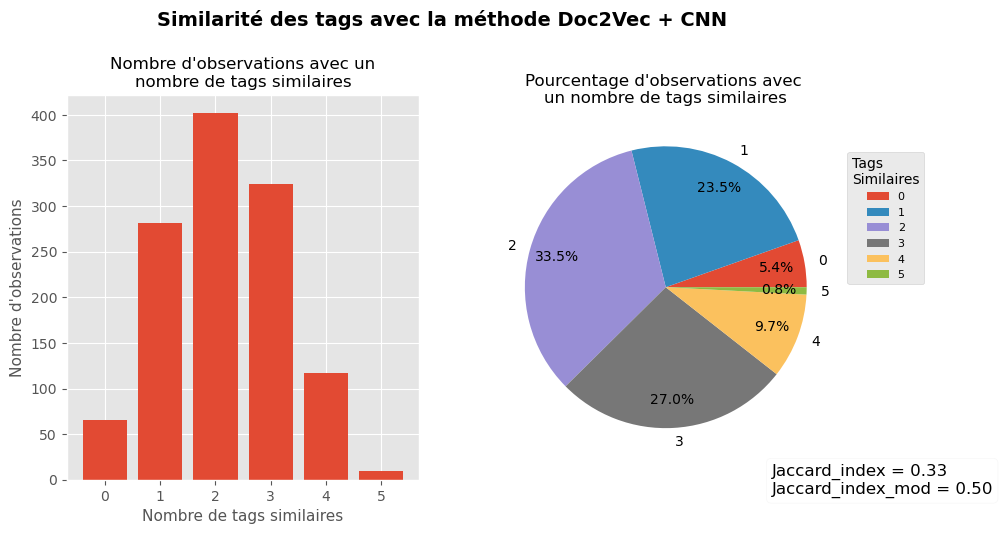

In [104]:
plot_similar_tags(tags_list_dv, pred_tags_d2v_500_cnn, 'Doc2Vec + CNN')

## <font color="#114b98" id="section_6">6. Approche supervisée : Word2Vec</font>

### W2V + MLP

In [105]:
from gensim.models import Word2Vec

In [106]:
w2v_model = Word2Vec(texts_list, vector_size=100, window=2, min_count=1, workers=4)

encoded_sentences = []
for sentence in texts_list:
    sentence_vector = np.zeros(100)
    for word in sentence:
        if word in w2v_model.wv:
            sentence_vector += w2v_model.wv[word]
    encoded_sentences.append(sentence_vector)
encoded_sentences = np.array(encoded_sentences)

train_sentences, test_sentences, train_tags, test_tags = train_test_split(
    encoded_sentences,
    tags_mlb,
    test_size=0.3,
    random_state=0
)

test_sentences, val_sentences , test_tags, val_tags = train_test_split(
    test_sentences,
    test_tags,
    test_size=0.5,
    random_state=42
)

w2v_nn_model = Sequential([
    Dense(1024, activation='relu', input_shape=(100,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),       
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')
])

w2v_nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [107]:
# plot_model(w2v_nn_model, to_file='w2v_nn_model.png', show_shapes=True)

In [108]:
history = w2v_nn_model.fit(train_sentences, train_tags, verbose=1, 
                           epochs=150, batch_size=32, 
                           validation_data=(val_sentences, val_tags))

Epoch 1/150
175/175 [==============================] - 2s 6ms/step - loss: 0.5679 - accuracy: 0.0152 - val_loss: 0.2057 - val_accuracy: 0.1333
Epoch 2/150
175/175 [==============================] - 1s 6ms/step - loss: 0.1070 - accuracy: 0.1323 - val_loss: 0.0507 - val_accuracy: 0.1475
Epoch 3/150
175/175 [==============================] - 1s 6ms/step - loss: 0.0518 - accuracy: 0.1538 - val_loss: 0.0420 - val_accuracy: 0.1558
Epoch 4/150
175/175 [==============================] - 1s 6ms/step - loss: 0.0462 - accuracy: 0.1541 - val_loss: 0.0396 - val_accuracy: 0.1583
Epoch 5/150
175/175 [==============================] - 1s 6ms/step - loss: 0.0422 - accuracy: 0.1618 - val_loss: 0.0377 - val_accuracy: 0.1500
Epoch 6/150
175/175 [==============================] - 1s 6ms/step - loss: 0.0402 - accuracy: 0.1604 - val_loss: 0.0364 - val_accuracy: 0.1717
Epoch 7/150
175/175 [==============================] - 1s 6ms/step - loss: 0.0392 - accuracy: 0.1598 - val_loss: 0.0353 - val_accuracy: 0.1625

Epoch 58/150
175/175 [==============================] - 1s 6ms/step - loss: 0.0269 - accuracy: 0.2002 - val_loss: 0.0242 - val_accuracy: 0.2150
Epoch 59/150
175/175 [==============================] - 1s 6ms/step - loss: 0.0267 - accuracy: 0.1975 - val_loss: 0.0243 - val_accuracy: 0.2350
Epoch 60/150
175/175 [==============================] - 1s 6ms/step - loss: 0.0266 - accuracy: 0.1918 - val_loss: 0.0242 - val_accuracy: 0.2317
Epoch 61/150
175/175 [==============================] - 1s 6ms/step - loss: 0.0267 - accuracy: 0.1954 - val_loss: 0.0241 - val_accuracy: 0.2033
Epoch 62/150
175/175 [==============================] - 1s 6ms/step - loss: 0.0265 - accuracy: 0.1909 - val_loss: 0.0241 - val_accuracy: 0.2283
Epoch 63/150
175/175 [==============================] - 1s 7ms/step - loss: 0.0266 - accuracy: 0.1998 - val_loss: 0.0242 - val_accuracy: 0.2325
Epoch 64/150
175/175 [==============================] - 1s 6ms/step - loss: 0.0265 - accuracy: 0.2009 - val_loss: 0.0241 - val_accuracy:

Epoch 115/150
175/175 [==============================] - 1s 6ms/step - loss: 0.0250 - accuracy: 0.2018 - val_loss: 0.0231 - val_accuracy: 0.2125
Epoch 116/150
175/175 [==============================] - 1s 5ms/step - loss: 0.0251 - accuracy: 0.1961 - val_loss: 0.0232 - val_accuracy: 0.2217
Epoch 117/150
175/175 [==============================] - 1s 6ms/step - loss: 0.0249 - accuracy: 0.1966 - val_loss: 0.0231 - val_accuracy: 0.2292
Epoch 118/150
175/175 [==============================] - 1s 6ms/step - loss: 0.0249 - accuracy: 0.1980 - val_loss: 0.0231 - val_accuracy: 0.2208
Epoch 119/150
175/175 [==============================] - 1s 6ms/step - loss: 0.0249 - accuracy: 0.2030 - val_loss: 0.0231 - val_accuracy: 0.2267
Epoch 120/150
175/175 [==============================] - 1s 6ms/step - loss: 0.0248 - accuracy: 0.1986 - val_loss: 0.0232 - val_accuracy: 0.2200
Epoch 121/150
175/175 [==============================] - 1s 6ms/step - loss: 0.0247 - accuracy: 0.2052 - val_loss: 0.0231 - val_ac

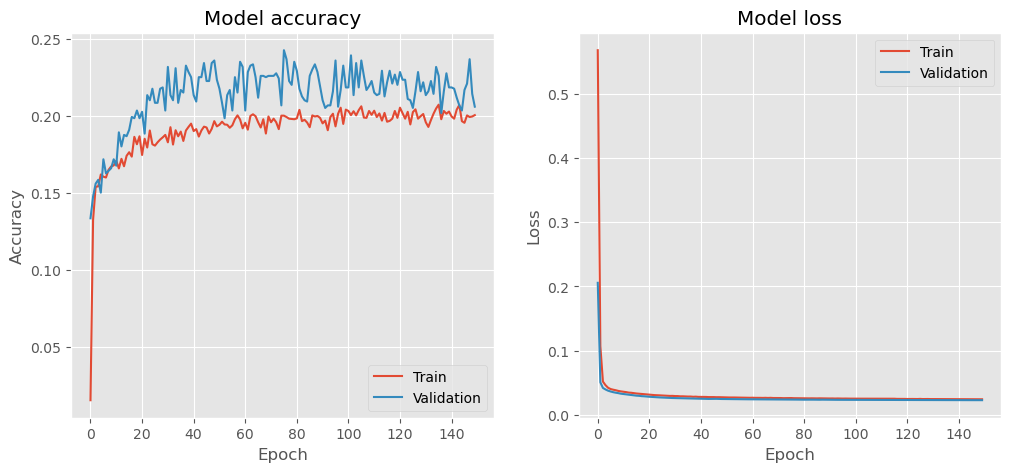

In [109]:
plot_epochs(history)

In [110]:
pred_probs_w2v_nn = w2v_nn_model.predict(test_sentences)

38/38 [==============================] - 0s 1ms/step


In [111]:
pred_tags_w2v_nn = []
for word_probs in pred_probs_w2v_nn:
    top_indexes = word_probs.argsort()[-5:][::-1]
    pred_tags_w2v_nn.append([mlb.classes_[i] for i in top_indexes])
pred_tags_w2v_nn[0:5]

[['iphone', 'ios', 'ipad', 'objective-c', 'xcode'],
 ['gcc', 'c++', 'c', 'linux', 'clang'],
 ['python', 'numpy', 'matlab', 'scipy', 'matrix'],
 ['javascript', 'jquery', 'animation', 'html', 'safari'],
 ['javascript', 'jquery', 'html', 'css', 'dom']]

In [112]:
true_tags_wv = mlb.inverse_transform(test_tags)
true_tags_wv[0:5]

[('objective-c', 'cocoa-touch', 'file', 'iphone'),
 ('c++', 'performance', 'boost', 'gcc', 'compilation'),
 ('matlab', 'oop', 'class', 'methods'),
 ('javascript', 'ruby-on-rails', 'url', 'jquery'),
 ('html', 'scroll', 'css', 'javascript', 'jquery')]

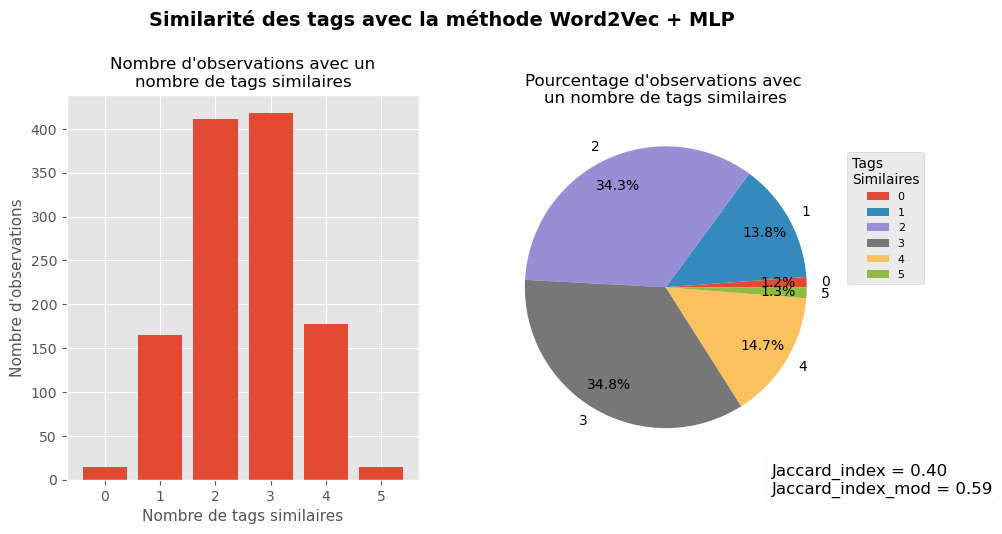

In [113]:
plot_similar_tags(true_tags_wv, pred_tags_w2v_nn, 'Word2Vec + MLP')

### W2V + CNN

In [114]:
w2v_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(encoded_sentences.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')
])

w2v_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [115]:
history = w2v_cnn_model.fit(train_sentences, train_tags, verbose=1, 
                            epochs=100, batch_size=32, 
                            validation_data=(val_sentences, val_tags))

Epoch 1/100
175/175 [==============================] - 1s 3ms/step - loss: 0.1288 - accuracy: 0.0489 - val_loss: 0.0598 - val_accuracy: 0.1508
Epoch 2/100
175/175 [==============================] - 0s 3ms/step - loss: 0.0588 - accuracy: 0.0829 - val_loss: 0.0481 - val_accuracy: 0.1517
Epoch 3/100
175/175 [==============================] - 0s 3ms/step - loss: 0.0465 - accuracy: 0.1007 - val_loss: 0.0426 - val_accuracy: 0.1500
Epoch 4/100
175/175 [==============================] - 0s 3ms/step - loss: 0.0443 - accuracy: 0.1232 - val_loss: 0.0415 - val_accuracy: 0.1483
Epoch 5/100
175/175 [==============================] - 0s 3ms/step - loss: 0.0428 - accuracy: 0.1473 - val_loss: 0.0398 - val_accuracy: 0.1358
Epoch 6/100
175/175 [==============================] - 0s 3ms/step - loss: 0.0417 - accuracy: 0.1523 - val_loss: 0.0391 - val_accuracy: 0.1467
Epoch 7/100
175/175 [==============================] - 0s 3ms/step - loss: 0.0405 - accuracy: 0.1527 - val_loss: 0.0378 - val_accuracy: 0.1458

Epoch 58/100
175/175 [==============================] - 0s 3ms/step - loss: 0.0260 - accuracy: 0.1973 - val_loss: 0.0279 - val_accuracy: 0.2233
Epoch 59/100
175/175 [==============================] - 0s 2ms/step - loss: 0.0260 - accuracy: 0.2073 - val_loss: 0.0274 - val_accuracy: 0.2242
Epoch 60/100
175/175 [==============================] - 0s 2ms/step - loss: 0.0258 - accuracy: 0.2034 - val_loss: 0.0278 - val_accuracy: 0.2117
Epoch 61/100
175/175 [==============================] - 0s 3ms/step - loss: 0.0260 - accuracy: 0.2021 - val_loss: 0.0277 - val_accuracy: 0.2267
Epoch 62/100
175/175 [==============================] - 0s 3ms/step - loss: 0.0260 - accuracy: 0.2055 - val_loss: 0.0280 - val_accuracy: 0.2258
Epoch 63/100
175/175 [==============================] - 0s 3ms/step - loss: 0.0257 - accuracy: 0.2095 - val_loss: 0.0277 - val_accuracy: 0.2108
Epoch 64/100
175/175 [==============================] - 0s 2ms/step - loss: 0.0259 - accuracy: 0.2050 - val_loss: 0.0277 - val_accuracy:

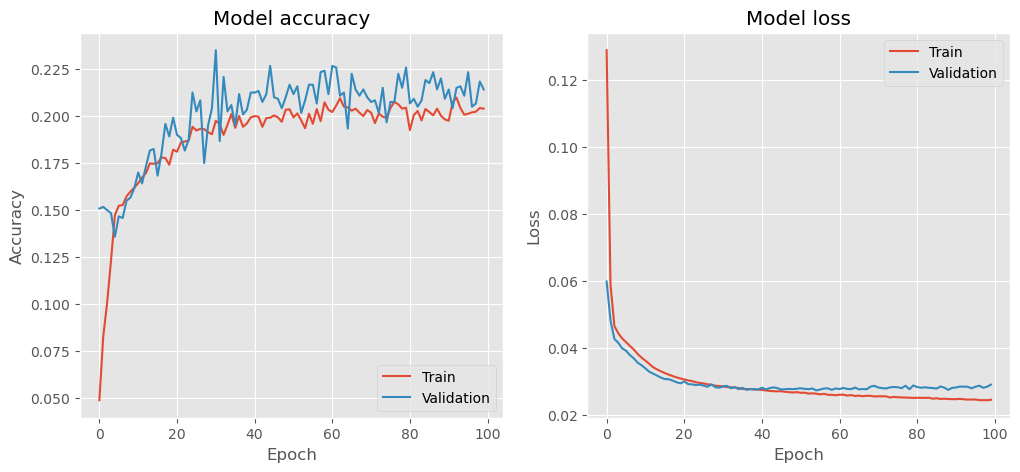

In [116]:
plot_epochs(history)

In [117]:
pred_probs_w2v_cnn = w2v_cnn_model.predict(test_sentences)

38/38 [==============================] - 0s 974us/step


In [118]:
pred_tags_w2v_cnn = []
for word_probs in pred_probs_w2v_cnn:
    top_indexes = word_probs.argsort()[-5:][::-1]
    pred_tags_w2v_cnn.append([mlb.classes_[i] for i in top_indexes])
pred_tags_w2v_cnn[0:5]

[['ios', 'iphone', 'xcode', 'objective-c', 'ipad'],
 ['gcc', 'c', 'c++', 'optimization', 'python'],
 ['python', 'function', 'matlab', 'numpy', 'arrays'],
 ['javascript', 'ios', 'iphone', 'animation', 'html'],
 ['javascript', 'jquery', 'html', 'css', 'dom']]

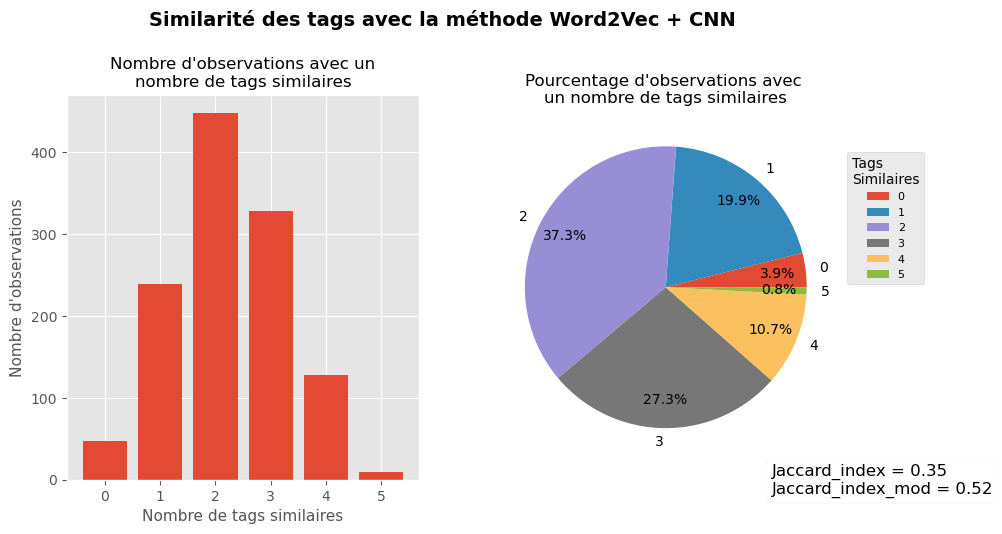

In [119]:
plot_similar_tags(true_tags_wv, pred_tags_w2v_cnn, 'Word2Vec + CNN')

## <font color="#114b98" id="section_7">7. Approche supervisée : BERT</font>

### BERT + MLP

In [120]:
from keras.layers import Flatten
from transformers import BertModel, BertTokenizer

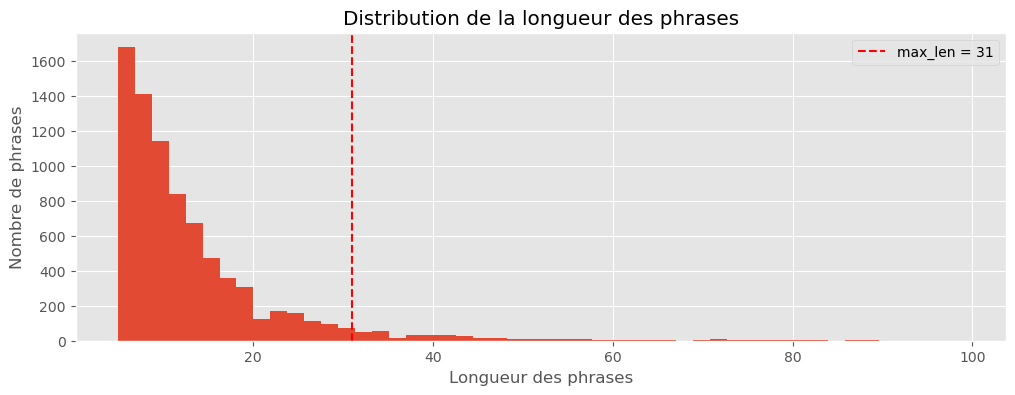

In [121]:
lengths = [len(tokens) for tokens in texts_list]
plt.figure(figsize=(12, 4))
plt.hist(lengths, bins=50)
plt.xlabel('Longueur des phrases')
plt.ylabel('Nombre de phrases')
plt.title('Distribution de la longueur des phrases')

mean_len = sum(lengths) / len(lengths)
std_len = (sum((length - mean_len)**2 for length in lengths) / len(lengths))**0.5
max_len = int(mean_len + 2 * std_len)-1
plt.axvline(x=max_len, color='r', linestyle='--', label=f'max_len = {max_len}')

plt.legend()
plt.show()

In [122]:
model = BertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

bert_sentences = [s[:max_len] for s in texts_list]

encoded_sentences = []
for sent in tqdm(bert_sentences, ascii=' >='):
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    with torch.no_grad():
        encoded_sent = model(input_ids)[0].mean(dim=1).numpy()
    encoded_sentences.append(encoded_sent)
encoded_sentences = np.array(encoded_sentences)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|==============================================================================| 8000/8000 [06:31<00:00, 20.45it/s]


In [123]:
train_sentences, test_sentences, train_tags, test_tags = train_test_split(
    encoded_sentences,
    tags_mlb,
    test_size=0.3,
    random_state=42
)

test_sentences, val_sentences , test_tags, val_tags = train_test_split(
    test_sentences,
    test_tags,
    test_size=0.5,
    random_state=42
)

bert_nn_model = Sequential([
    Flatten(input_shape=(1, 768)),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')
])

bert_nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

bert_nn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 dense_14 (Dense)            (None, 512)               393728    
                                                                 
 batch_normalization_8 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_9 (Batc  (None, 256)              1024      
 hNormalization)                                      

In [124]:
# plot_model(bert_nn_model, to_file='bert_nn_model.png', show_shapes=True)

In [125]:
history = bert_nn_model.fit(train_sentences, train_tags, verbose=1, 
                            epochs=100, batch_size=32, 
                            validation_data=(val_sentences, val_tags), 
                            workers=multiprocessing.cpu_count())

Epoch 1/100
175/175 [==============================] - 2s 6ms/step - loss: 0.5676 - accuracy: 0.0157 - val_loss: 0.1603 - val_accuracy: 0.1033
Epoch 2/100
175/175 [==============================] - 1s 4ms/step - loss: 0.1069 - accuracy: 0.1068 - val_loss: 0.0478 - val_accuracy: 0.1292
Epoch 3/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0519 - accuracy: 0.1264 - val_loss: 0.0412 - val_accuracy: 0.1458
Epoch 4/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0455 - accuracy: 0.1384 - val_loss: 0.0400 - val_accuracy: 0.1550
Epoch 5/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0431 - accuracy: 0.1363 - val_loss: 0.0392 - val_accuracy: 0.1550
Epoch 6/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0418 - accuracy: 0.1452 - val_loss: 0.0381 - val_accuracy: 0.1758
Epoch 7/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0411 - accuracy: 0.1477 - val_loss: 0.0374 - val_accuracy: 0.1733

Epoch 58/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0288 - accuracy: 0.1875 - val_loss: 0.0275 - val_accuracy: 0.1817
Epoch 59/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0289 - accuracy: 0.1902 - val_loss: 0.0275 - val_accuracy: 0.2017
Epoch 60/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0288 - accuracy: 0.1866 - val_loss: 0.0278 - val_accuracy: 0.1842
Epoch 61/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0288 - accuracy: 0.1852 - val_loss: 0.0274 - val_accuracy: 0.1908
Epoch 62/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0288 - accuracy: 0.1866 - val_loss: 0.0273 - val_accuracy: 0.1833
Epoch 63/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0287 - accuracy: 0.1902 - val_loss: 0.0274 - val_accuracy: 0.1942
Epoch 64/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0286 - accuracy: 0.1930 - val_loss: 0.0274 - val_accuracy:

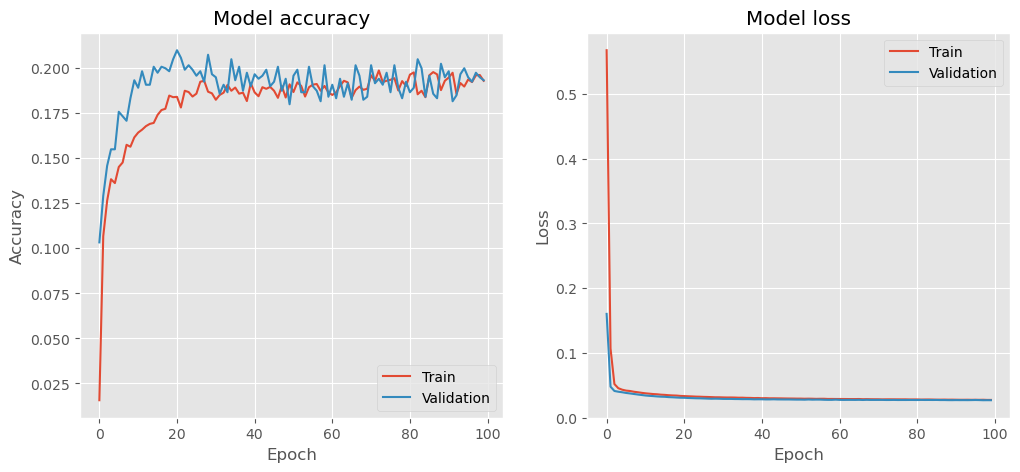

In [126]:
plot_epochs(history)

In [127]:
bert_pred_probs = bert_nn_model.predict(test_sentences)

38/38 [==============================] - 0s 974us/step


In [128]:
pred_tags_bert = []
for word_probs in bert_pred_probs:
    top_indexes = word_probs.argsort()[-5:][::-1]
    pred_tags_bert.append([mlb.classes_[i] for i in top_indexes])

In [129]:
pred_tags_bert[0:5]

[['boost', 'c++', 'gcc', 'clang', 'build'],
 ['sql', 'mysql', 'java', 'database', 'postgresql'],
 ['java', 'eclipse', 'android', 'class', 'java-8'],
 ['javascript', 'function', 'jquery', 'arrays', 'c++'],
 ['linux', 'path', 'c', 'python', 'file']]

In [130]:
true_tags_be = mlb.inverse_transform(test_tags)
true_tags_be[0:5]

[('linker', 'c++', 'eclipse', 'regex', 'boost'),
 ('java', 'jdbc', 'sql-server-2005', 'sql-server'),
 ('java', 'eclipse', 'unit-testing', 'testing', 'debugging'),
 ('function', 'linker', 'dll', 'c++', 'windows'),
 ('git', 'node.js', 'path', 'macos')]

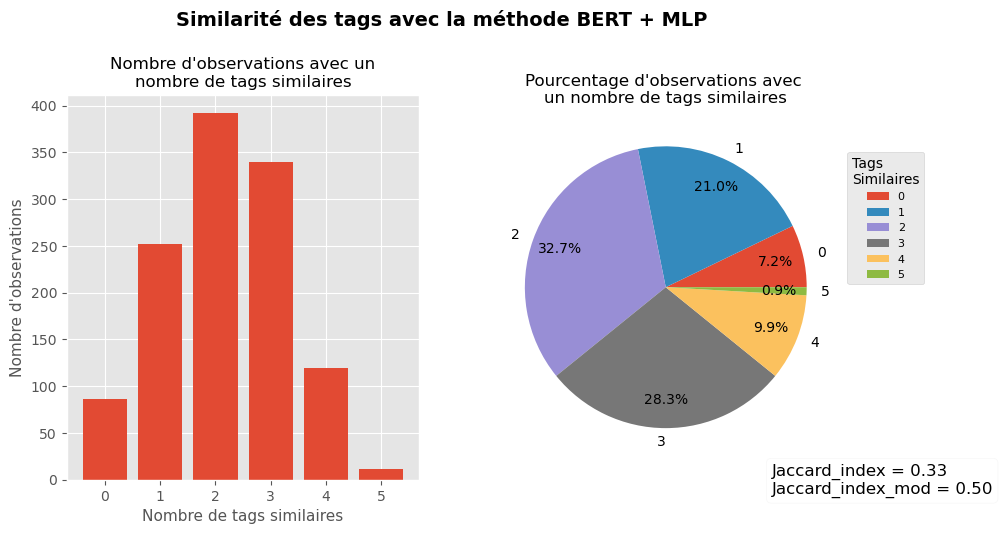

In [131]:
plot_similar_tags(true_tags_be, pred_tags_bert, 'BERT + MLP')

## <font color="#114b98" id="section_8">8. Approche supervisée : USE</font>

### USE + MLP

In [132]:
import tensorflow_hub as hub

In [133]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/4"

In [134]:
use_layer = hub.KerasLayer(module_url)

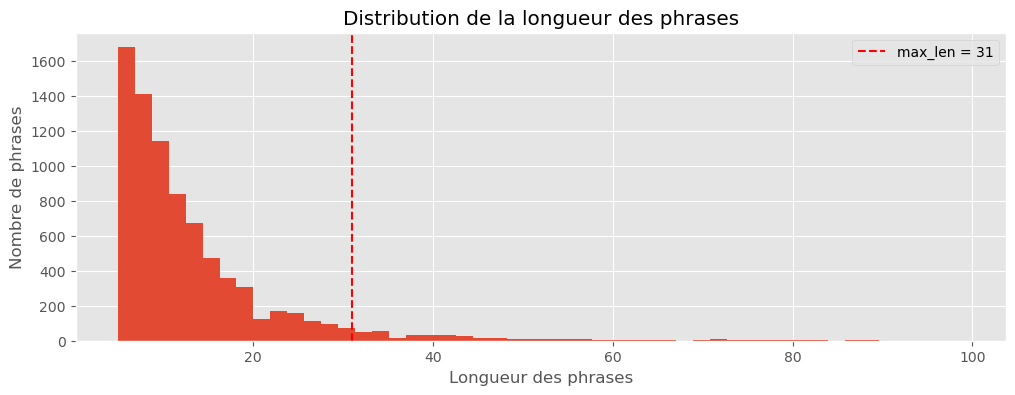

In [135]:
lengths = [len(sent.split()) for sent in flat_texts]
plt.figure(figsize=(12, 4))
plt.hist(lengths, bins=50)
plt.xlabel('Longueur des phrases')
plt.ylabel('Nombre de phrases')
plt.title('Distribution de la longueur des phrases')

mean_len = sum(lengths) / len(lengths)
std_len = (sum((length - mean_len)**2 for length in lengths) / len(lengths))**0.5
max_len = int(mean_len + 2 * std_len)-1
plt.axvline(x=max_len, color='r', linestyle='--', label=f'max_len = {max_len}')

plt.legend()
plt.show()

In [136]:
X_train, X_test, y_train, y_test = train_test_split(
    flat_texts,
    tags_mlb,
    test_size=0.7,
    random_state=42
)

X_test, X_val, y_test, y_val = train_test_split(
    X_test,
    y_test,
    test_size=0.5,
    random_state=42
)

In [137]:
def use_encode(texts, max_len):
    embeddings = use_layer(texts)['outputs']
    return embeddings.numpy()

In [138]:
use_train = use_encode(X_train, max_len=max_len)

In [139]:
use_test = use_encode(X_test, max_len=max_len)

In [140]:
use_val = use_encode(X_val, max_len=max_len)

In [141]:
use_nn_model = Sequential([
    Dense(512, activation='relu', input_shape=(512,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')
])

use_nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
use_nn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_11 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_12 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_14 (Dropout)        (None, 256)              

In [142]:
history = use_nn_model.fit(use_train, y_train, verbose=1, 
                           epochs=125, batch_size=32, 
                           validation_data=(use_val, y_val))

Epoch 1/125
75/75 [==============================] - 1s 6ms/step - loss: 0.7262 - accuracy: 0.0104 - val_loss: 0.5664 - val_accuracy: 0.0014
Epoch 2/125
75/75 [==============================] - 0s 4ms/step - loss: 0.5048 - accuracy: 0.0658 - val_loss: 0.2455 - val_accuracy: 0.1618
Epoch 3/125
75/75 [==============================] - 0s 4ms/step - loss: 0.2067 - accuracy: 0.1517 - val_loss: 0.0890 - val_accuracy: 0.1618
Epoch 4/125
75/75 [==============================] - 0s 4ms/step - loss: 0.0902 - accuracy: 0.1733 - val_loss: 0.0565 - val_accuracy: 0.1650
Epoch 5/125
75/75 [==============================] - 0s 4ms/step - loss: 0.0597 - accuracy: 0.1737 - val_loss: 0.0461 - val_accuracy: 0.1754
Epoch 6/125
75/75 [==============================] - 0s 4ms/step - loss: 0.0490 - accuracy: 0.1767 - val_loss: 0.0412 - val_accuracy: 0.1739
Epoch 7/125
75/75 [==============================] - 0s 4ms/step - loss: 0.0441 - accuracy: 0.1779 - val_loss: 0.0381 - val_accuracy: 0.1779
Epoch 8/125
7

Epoch 59/125
75/75 [==============================] - 0s 4ms/step - loss: 0.0234 - accuracy: 0.2079 - val_loss: 0.0219 - val_accuracy: 0.1918
Epoch 60/125
75/75 [==============================] - 0s 4ms/step - loss: 0.0231 - accuracy: 0.1967 - val_loss: 0.0218 - val_accuracy: 0.1929
Epoch 61/125
75/75 [==============================] - 0s 4ms/step - loss: 0.0231 - accuracy: 0.1988 - val_loss: 0.0218 - val_accuracy: 0.1921
Epoch 62/125
75/75 [==============================] - 0s 4ms/step - loss: 0.0230 - accuracy: 0.2054 - val_loss: 0.0218 - val_accuracy: 0.1954
Epoch 63/125
75/75 [==============================] - 0s 4ms/step - loss: 0.0230 - accuracy: 0.2017 - val_loss: 0.0218 - val_accuracy: 0.1829
Epoch 64/125
75/75 [==============================] - 0s 4ms/step - loss: 0.0230 - accuracy: 0.2021 - val_loss: 0.0218 - val_accuracy: 0.1896
Epoch 65/125
75/75 [==============================] - 0s 4ms/step - loss: 0.0229 - accuracy: 0.1958 - val_loss: 0.0218 - val_accuracy: 0.1979
Epoch 

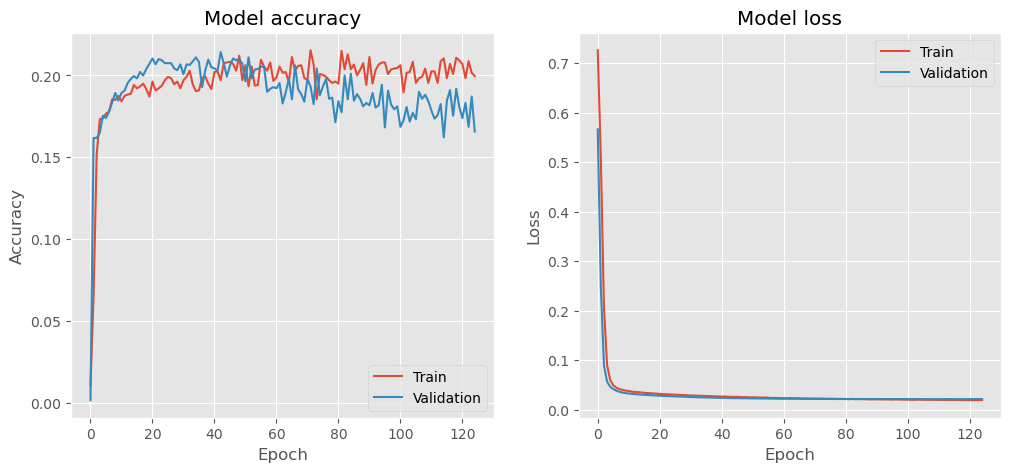

In [143]:
plot_epochs(history)

In [144]:
pred_probs_use = use_nn_model.predict(use_test)

88/88 [==============================] - 0s 943us/step


In [145]:
pred_tags_use = []
for word_probs in pred_probs_use:
    top_indexes = word_probs.argsort()[-5:][::-1]
    pred_tags_use.append([mlb.classes_[i] for i in top_indexes])

In [146]:
pred_tags_use[0:5]

[['activerecord', 'ruby-on-rails', 'ruby', 'ruby-on-rails-3', 'postgresql'],
 ['python', 'scipy', 'numpy', 'opencv', 'image'],
 ['mysql', 'database', 'php', 'sql', 'session'],
 ['date', 'datetime', 'time', 'c#', '.net'],
 ['python', 'django', 'rest', 'authentication', 'api']]

In [147]:
true_tags_use = mlb.inverse_transform(y_test)
true_tags_use[0:5]

[('activerecord', 'join', 'ruby-on-rails', 'ruby'),
 ('opencv', 'image-processing', 'numpy', 'python', 'image'),
 ('memory', 'session', 'mysql', 'php'),
 ('datetime', 'date', 'python', 'pandas'),
 ('jwt', 'python', 'rest', 'django')]

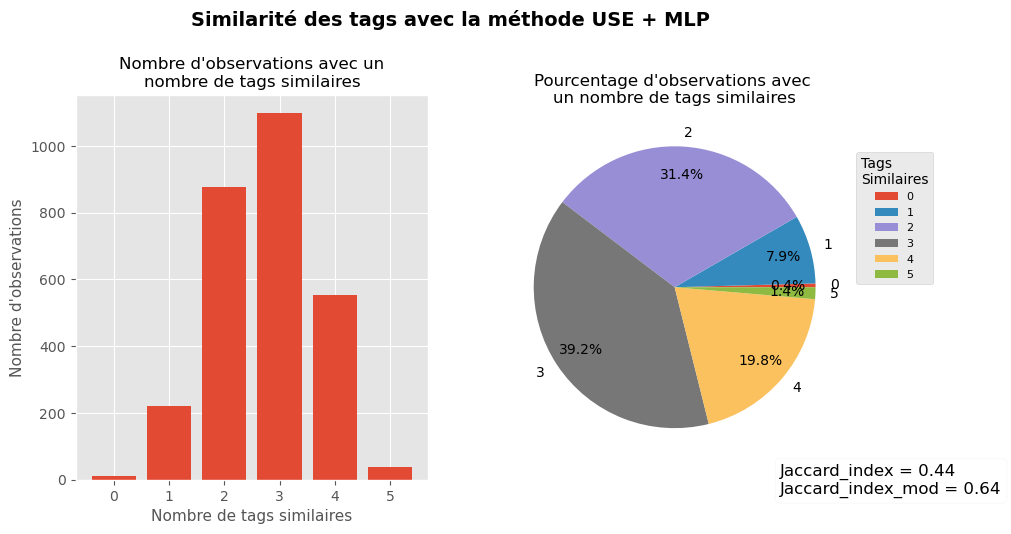

In [148]:
plot_similar_tags(true_tags_use, pred_tags_use, 'USE + MLP')

### USE + CNN

In [149]:
use_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(512,1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    GlobalMaxPooling1D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')
])

use_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = use_cnn_model.fit(use_train, y_train, verbose=1, 
                            epochs=125, batch_size=32, 
                            validation_data=(use_val, y_val))

Epoch 1/125
75/75 [==============================] - 2s 12ms/step - loss: 0.7248 - accuracy: 0.0054 - val_loss: 0.5909 - val_accuracy: 0.0000e+00
Epoch 2/125
75/75 [==============================] - 1s 11ms/step - loss: 0.5155 - accuracy: 0.0183 - val_loss: 0.2677 - val_accuracy: 0.0039
Epoch 3/125
75/75 [==============================] - 1s 11ms/step - loss: 0.2162 - accuracy: 0.0725 - val_loss: 0.0892 - val_accuracy: 0.1618
Epoch 4/125
75/75 [==============================] - 1s 11ms/step - loss: 0.0911 - accuracy: 0.1154 - val_loss: 0.0531 - val_accuracy: 0.1618
Epoch 5/125
75/75 [==============================] - 1s 11ms/step - loss: 0.0626 - accuracy: 0.1300 - val_loss: 0.0457 - val_accuracy: 0.1618
Epoch 6/125
75/75 [==============================] - 1s 11ms/step - loss: 0.0529 - accuracy: 0.1433 - val_loss: 0.0440 - val_accuracy: 0.1618
Epoch 7/125
75/75 [==============================] - 1s 10ms/step - loss: 0.0501 - accuracy: 0.1354 - val_loss: 0.0429 - val_accuracy: 0.1593
Ep

75/75 [==============================] - 1s 11ms/step - loss: 0.0289 - accuracy: 0.1650 - val_loss: 0.0372 - val_accuracy: 0.1654
Epoch 116/125
75/75 [==============================] - 1s 11ms/step - loss: 0.0289 - accuracy: 0.1579 - val_loss: 0.0401 - val_accuracy: 0.1457
Epoch 117/125
75/75 [==============================] - 1s 11ms/step - loss: 0.0289 - accuracy: 0.1729 - val_loss: 0.0439 - val_accuracy: 0.0964
Epoch 118/125
75/75 [==============================] - 1s 11ms/step - loss: 0.0289 - accuracy: 0.1642 - val_loss: 0.0421 - val_accuracy: 0.1389
Epoch 119/125
75/75 [==============================] - 1s 11ms/step - loss: 0.0290 - accuracy: 0.1654 - val_loss: 0.0400 - val_accuracy: 0.1632
Epoch 120/125
75/75 [==============================] - 1s 11ms/step - loss: 0.0288 - accuracy: 0.1729 - val_loss: 0.0383 - val_accuracy: 0.1054
Epoch 121/125
75/75 [==============================] - 1s 11ms/step - loss: 0.0286 - accuracy: 0.1637 - val_loss: 0.0342 - val_accuracy: 0.1368
Epoch 

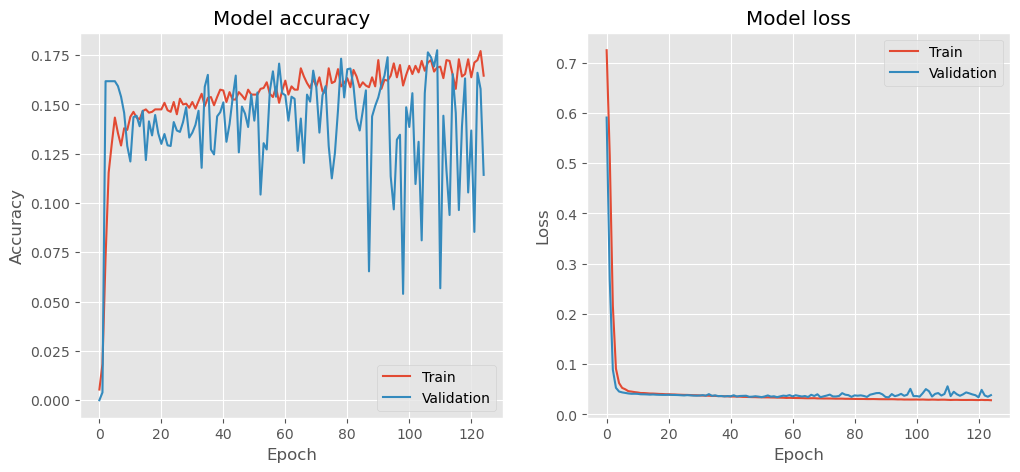

In [150]:
plot_epochs(history)

In [151]:
pred_probs_use_cnn = use_cnn_model.predict(use_test)

88/88 [==============================] - 0s 3ms/step


In [152]:
pred_tags_use_cnn = []
for word_probs in pred_probs_use_cnn:
    top_indexes = word_probs.argsort()[-5:][::-1]
    pred_tags_use_cnn.append([mlb.classes_[i] for i in top_indexes])

In [153]:
pred_tags_use_cnn[0:5]

[['python', 'javascript', 'django', 'jquery', 'html'],
 ['python', 'pandas', 'numpy', 'matplotlib', 'dataframe'],
 ['javascript', 'jquery', 'java', 'html', 'angularjs'],
 ['javascript', 'date', 'html', 'jquery', 'datetime'],
 ['javascript', 'jquery', 'json', 'html', 'post']]

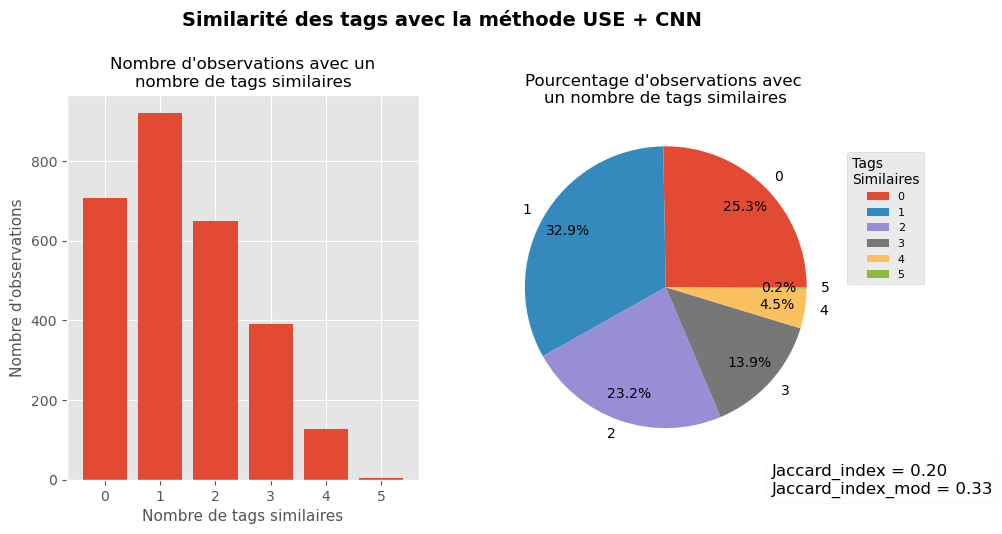

In [154]:
plot_similar_tags(true_tags_use, pred_tags_use_cnn, 'USE + CNN')

## <font color="#114b98" id="section_9">9. Choix du modèle pour le code final à déployer</font>

Nous allons maintenant comparer les différents modèles à l'aide de leurs résultats sur le dataset d'évaluation.

### TFIDF

In [155]:
vectorizer = TfidfVectorizer(vocabulary=vocabulary_texts_eval, min_df=min_df, max_df=max_df)
bow = vectorizer.fit_transform(flat_texts_eval)
pred_tfidf_eval = []
for i in tqdm(range(len(texts_list_eval)), ascii=' >='):
    dense_bow_matrix = bow.toarray()
    top_words_indices = dense_bow_matrix[i].argsort()[-5:][::-1]
    topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
    pred_tfidf_eval.append(topic_words)

100%|============================================================================| 2000/2000 [00:01<00:00, 1640.08it/s]


### CountVectorizer

In [156]:
vectorizer = CountVectorizer(vocabulary=vocabulary_texts_eval, min_df=min_df, max_df=max_df)
bow = vectorizer.fit_transform(flat_texts_eval)
pred_count_eval = []
for i in tqdm(range(len(texts_list_eval)), ascii=' >='):
    dense_bow_matrix = bow.toarray()
    top_words_indices = dense_bow_matrix[i].argsort()[-5:][::-1]
    topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
    pred_count_eval.append(topic_words)

100%|============================================================================| 2000/2000 [00:01<00:00, 1553.92it/s]


### LDA + CV

In [157]:
lda = LatentDirichletAllocation(n_components=best_num_topics['LatentDirichletAllocation + count'][0],
                                max_iter=5,
                                random_state=42).fit(vcv)
lda_vcv_tags = get_top_tags(flat_texts_eval, CV_feature_names, lda, vectorizer_CV)

### RAKE

Cette méthode est non supervisée et ses scores ont déjà été calculés précédemment. Ils étaient d'ailleurs très bons.

Cependant, pour l'utiliser il faut réentraîner le modèle entièrement pour avoir une nouvelle prédiction.

Je décide donc de ne pas l'utiliser par la suite.

### TFIDFVectorizer + SGDClassifier

In [158]:
X = vectorizer_TFIDF.transform(flat_texts_eval)
y_pred_SGDC = ovrc_SGDC.predict(X)
pred_tags_SGDC = mlb.inverse_transform(y_pred_SGDC)

### CountVectorizer + LogisticRegression

In [159]:
X = vectorizer_CV.transform(flat_texts_eval)
y_pred_LR = ovrc_LR.predict(X)
pred_tags_LR = mlb.inverse_transform(y_pred_LR)

### Doc2Vec + MLP

In [160]:
tagged_data_eval = [TaggedDocument(words=sent, tags=[str(i)]) for i, sent in enumerate(texts_list_eval)]
encoded_sentences_eval = np.array([d2v_model.infer_vector(sent.words) for sent in tagged_data_eval])
pred_probs_d2v_500_nn_eval = d2v_nn_model.predict(encoded_sentences_eval)
pred_tags_d2v = []
for word_probs in pred_probs_d2v_500_nn_eval:
    top_indexes = word_probs.argsort()[-5:][::-1]
    pred_tags_d2v.append([mlb.classes_[i] for i in top_indexes])

63/63 [==============================] - 0s 985us/step


### Doc2Vec + CNN

In [161]:
pred_probs_d2v_500_cnn_eval = d2v_cnn_model.predict(encoded_sentences_eval)
pred_tags_d2v_cnn = []
for word_probs in pred_probs_d2v_500_cnn_eval:
    top_indexes = word_probs.argsort()[-5:][::-1]
    pred_tags_d2v_cnn.append([mlb.classes_[i] for i in top_indexes])

63/63 [==============================] - 0s 1ms/step


### Word2Vec + MLP

In [162]:
encoded_sentences_eval = []
for sentence in texts_list_eval:
    sentence_vector = np.zeros(100)
    for word in sentence:
        if word in w2v_model.wv:
            sentence_vector += w2v_model.wv[word]
    encoded_sentences_eval.append(sentence_vector)
encoded_sentences_eval = np.array(encoded_sentences_eval)
pred_probs_w2v_nn = w2v_nn_model.predict(encoded_sentences_eval)
pred_tags_w2v = []
for word_probs in pred_probs_w2v_nn:
    top_indexes = word_probs.argsort()[-5:][::-1]
    pred_tags_w2v.append([mlb.classes_[i] for i in top_indexes])

63/63 [==============================] - 0s 2ms/step


### Word2Vec + CNN

In [163]:
pred_probs_w2v_cnn = w2v_cnn_model.predict(encoded_sentences_eval)
pred_tags_w2v_cnn = []
for word_probs in pred_probs_w2v_cnn:
    top_indexes = word_probs.argsort()[-5:][::-1]
    pred_tags_w2v_cnn.append([mlb.classes_[i] for i in top_indexes])

63/63 [==============================] - 0s 1ms/step


### BERT + MLP

In [164]:
bert_sentences_eval = [s[:max_len] for s in texts_list_eval]
encoded_sentences_eval = []
for sent in tqdm(bert_sentences_eval, ascii=' >='):
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    with torch.no_grad():
        encoded_sent = model(input_ids)[0].mean(dim=1).numpy()
    encoded_sentences_eval.append(encoded_sent)
encoded_sentences_eval = np.array(encoded_sentences_eval)
pred_probs_bert_eval = bert_nn_model.predict(encoded_sentences_eval)
pred_tags_bert_eval = []
for word_probs in pred_probs_bert_eval:
    top_indexes = word_probs.argsort()[-5:][::-1]
    pred_tags_bert_eval.append([mlb.classes_[i] for i in top_indexes])

100%|==============================================================================| 2000/2000 [01:41<00:00, 19.61it/s]

49/63 [======================>.......] - ETA: 0s

63/63 [==============================] - 0s 1ms/step


### USE + MLP

In [165]:
use_test_eval = use_encode(flat_texts_eval, max_len=max_len)
pred_probs_eval = use_nn_model.predict(use_test_eval)
pred_tags_use_nn = []
for word_probs in tqdm(pred_probs_eval, ascii=' >='):
    top_indexes = word_probs.argsort()[-5:][::-1]
    pred_tags_use_nn.append([mlb.classes_[i] for i in top_indexes])

63/63 [==============================] - 0s 1ms/step


100%|===========================================================================| 2000/2000 [00:00<00:00, 48737.82it/s]


### USE + CNN

In [166]:
pred_probs_eval = use_cnn_model.predict(use_test_eval)
pred_tags_use_cnn = []
for word_probs in tqdm(pred_probs_eval, ascii=' >='):
    top_indexes = word_probs.argsort()[-5:][::-1]
    pred_tags_use_cnn.append([mlb.classes_[i] for i in top_indexes])

63/63 [==============================] - 0s 3ms/step


100%|===========================================================================| 2000/2000 [00:00<00:00, 49955.98it/s]


### Évaluation des performances des différents modèles sur les données de tests

In [198]:
models_tags_lists = [pred_tfidf_eval, pred_count_eval, lda_vcv_tags,
                     rake_keywords, pred_tags_SGDC, pred_tags_LR,
                     pred_tags_d2v, pred_tags_d2v_cnn,
                     pred_tags_w2v, pred_tags_w2v_cnn, 
                     pred_tags_bert_eval, 
                     pred_tags_use_nn, pred_tags_use_cnn]

In [199]:
models_names = ['TFIDF', 'CV', 'CV + LDA',
                'RAKE', 'TFIDF + SGDC', 'CV + LR',
                'D2V + MLP', 'D2V + CNN',
                'W2V + MLP', 'W2V + CNN',
                'BERT + MLP',
                'USE + MLP', 'USE + CNN']

In [200]:
def evaluate_models(models_tags_lists, tags_list_eval, models_names):
    results = {}
    my_palette = sns.color_palette("husl", len(models_names))

    for i in range(len(models_names)):
        precision, recall, f1 = [], [], []
        for j in range(len(tags_list_eval)):
            true_tags = set(tags_list_eval[j])
            predicted_tags = set()
            for tag in models_tags_lists[i][j]:
                predicted_tags.update(tag.split())
            
            # Calcul des métriques pour chaque tag prédit
            tp = len(true_tags.intersection(predicted_tags))
            fp = len(predicted_tags - true_tags)
            fn = len(true_tags - predicted_tags)
            
            precision.append(tp / (tp + fp + 1e-10))
            recall.append(tp / (tp + fn + 1e-10))
            f1.append(2 * precision[-1] * recall[-1] / (precision[-1] + recall[-1] + 1e-10))
        
        # Calcul des moyennes des métriques pour le modèle
        results[models_names[i]] = {'Precision': np.mean(precision), 'Recall': np.mean(recall), 'F1-Score': np.mean(f1)}

    # Affichage des résultats
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    for i, metric_name in enumerate(['Precision', 'Recall', 'F1-Score']):
        metric_values = [results[model_name][metric_name] for model_name in models_names]

        sns.barplot(x=models_names, y=metric_values, palette=my_palette, ax=axs[i])
        axs[i].set_ylabel('')
        axs[i].set_title(f'{metric_name}')
        axs[i].set_xticklabels(models_names, rotation=90)
        
    plt.show()

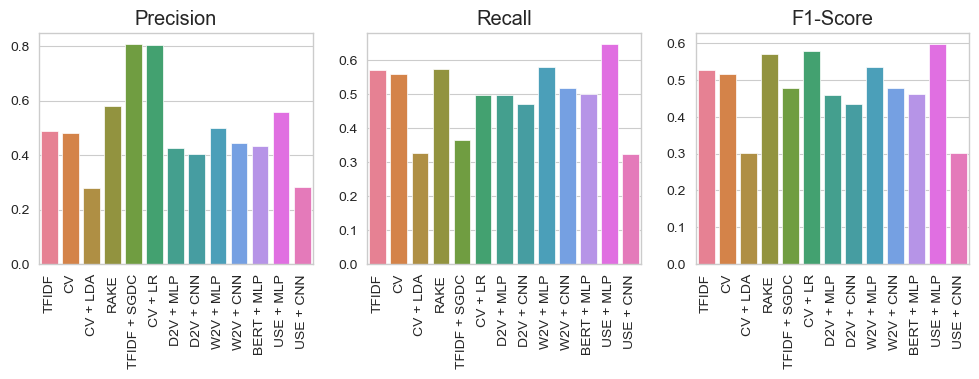

In [201]:
evaluate_models(models_tags_lists, tags_list_eval, models_names)

In [202]:
def plot_keyword_performance(models_tags_lists, tags_list_eval, models_names):
    avg_keywords_correct = []
    my_palette = sns.color_palette("husl", len(models_names))
    
    for i in range(len(models_tags_lists)):
        keywords_correct = 0
        for j in range(len(models_tags_lists[i])):
            keywords_x = len(set(models_tags_lists[i][j]).intersection(set(tags_list_eval[j])))/len(set(tags_list_eval[j]))
            keywords_correct += keywords_x
        avg_keywords_correct.append(keywords_correct*100/len(models_tags_lists[i]))
    
    # plot the bar plot
    x = np.arange(len(models_names))
    width = 0.5
    
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.barplot(x=x, y=avg_keywords_correct, palette=my_palette, ax=ax)
    ax.set_xticks(x)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('Pourcentage de tags corrects')
    ax.set_title('Comparaison des pourcentages de tags corrects des différents modèles')
    plt.xticks(rotation=45)
    
    plt.show()

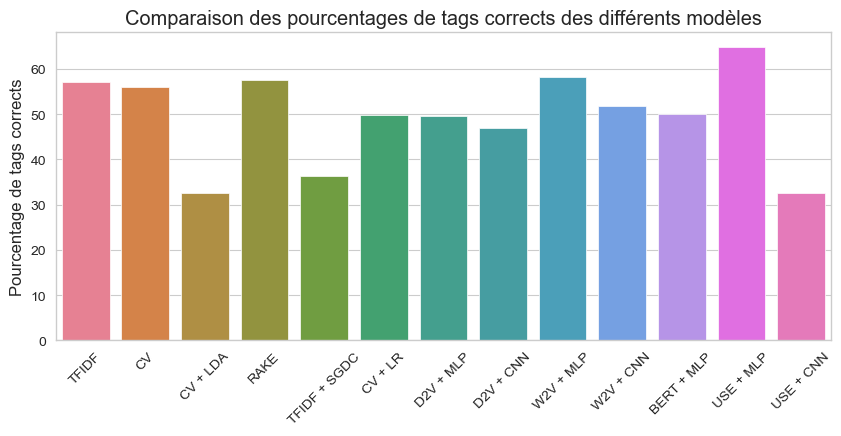

In [203]:
plot_keyword_performance(models_tags_lists, tags_list_eval, models_names)

In [204]:
best_models = models_tags_lists[:2] + models_tags_lists[3:4] + models_tags_lists[4:6] + models_tags_lists[-2:-1]
best_models_names = models_names[:2] + models_names[3:4] + models_names[4:6] + models_names[-2:-1]

In [205]:
def plot_tag_comparison(true_tags, models_tags_lists, models_names):
    n = len(models_tags_lists)
    rows = (n + 2) // 3
    fig, axs = plt.subplots(rows, 3, figsize=(16, 8), squeeze=False)
    fig.suptitle("Nombre d'observations avec tags similaires pour les 6 meilleurs modèles",
                 fontsize=16, fontweight='bold', y=0.95)    

    jaccard_scores = []
    jaccard_scores_mod = []
    mean_nb_tags_list = [] 

    for i, pred_tags in enumerate(models_tags_lists):
        mean_score = calculate_scores(true_tags, pred_tags)
        mean_score_mod = calculate_scores_mod(true_tags, pred_tags)
        mean_nb_tags = mean([len(tags) for tags in pred_tags])

        jaccard_scores.append(mean_score)
        jaccard_scores_mod.append(mean_score_mod)        
        mean_nb_tags_list.append(mean_nb_tags)
        
        counter = Counter([len(set(t) & set(p)) for t, p in zip(true_tags, pred_tags)])
        counter = dict(sorted(counter.items()))
        keys = set(range(0, 6))
        missing_keys = keys - set(counter.keys())
        for key in missing_keys:
            counter[key] = 0
        sorted_counter = dict(sorted(counter.items()))

        row = i // 3
        col = i % 3
        axs[row, col].pie(sorted_counter.values(),
                           labels=sorted_counter.keys(),
                           autopct='%1.1f%%', pctdistance=0.8, radius=0.8)
        if i == 0:
            axs[row, col].legend(title='Similar\nTags',
                          bbox_to_anchor=(0, 1),
                          prop={'size': 8}, 
                          title_fontsize=10)
        axs[row, col].set_title(models_names[i], fontweight='bold', y=0.9)
        
        textstr = (f'Jaccard index = {mean_score:.2f}\n'
                   f'Jaccard index mod = {mean_score_mod:.2f}\n'
                   f'Mean nb Tags = {mean_nb_tags:.1f}\n')
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        axs[row, col].text(0.6, 0.15, textstr, transform=axs[row, col].transAxes,
                           fontsize=12, verticalalignment='top', bbox=props)

    plt.show()
    return jaccard_scores, jaccard_scores_mod, mean_nb_tags_list

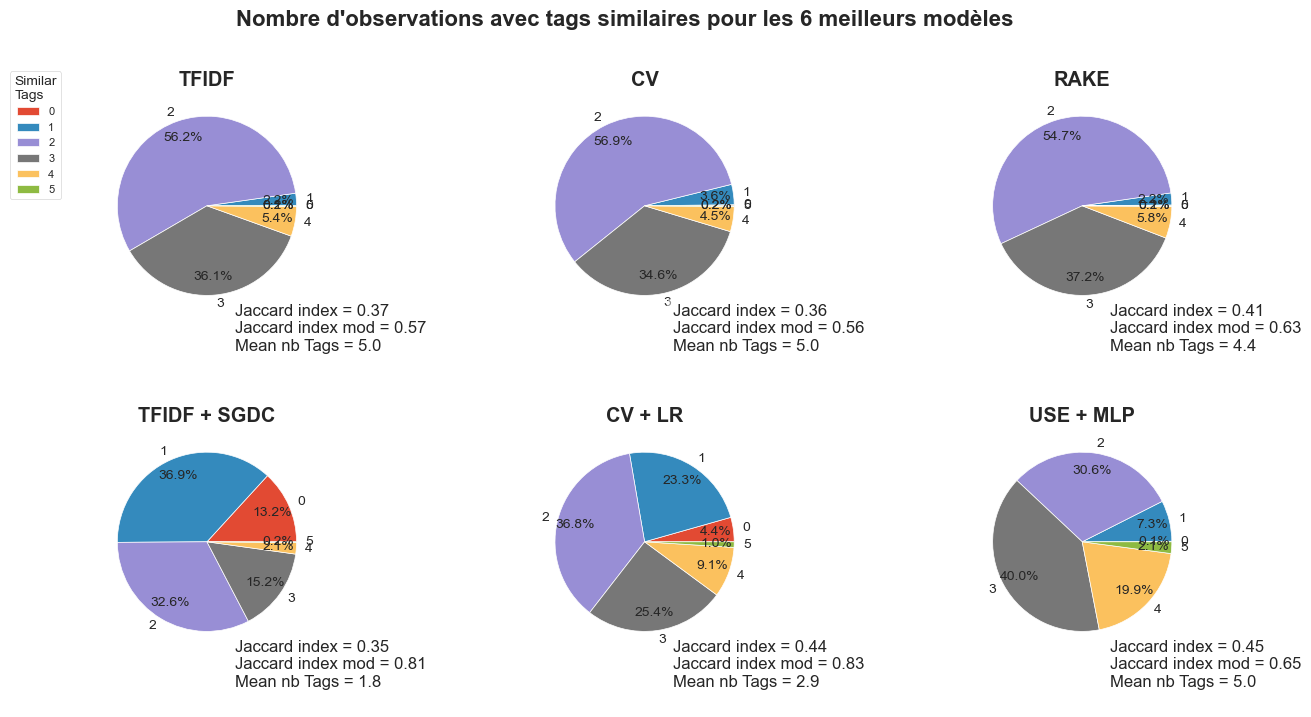

In [206]:
jaccard_scores, jaccard_scores_mod, mean_nb_tags_list = plot_tag_comparison(tags_list_eval,
                                                                            best_models,
                                                                            best_models_names)

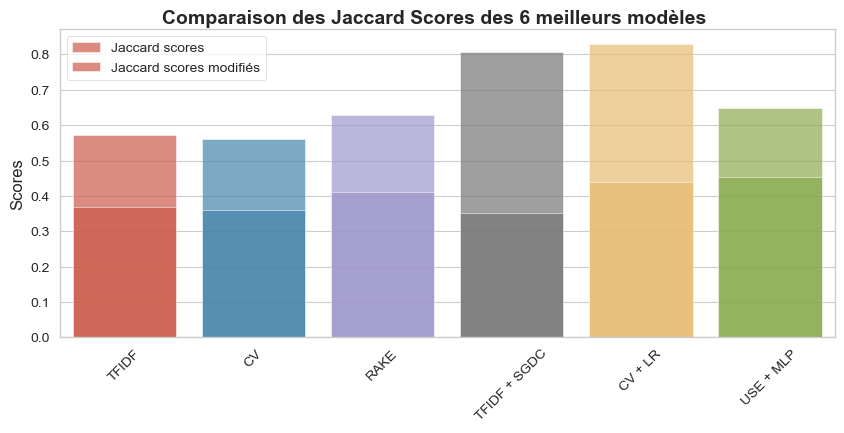

In [207]:
data = {
    'models_names': best_models_names,
    'jaccard_scores': jaccard_scores,
    'jaccard_scores_mod': jaccard_scores_mod,
    'mean_nb_tags': mean_nb_tags_list
}

sns.set_style('whitegrid')
fig = plt.figure(figsize=(10, 4))
fig.suptitle("Comparaison des Jaccard Scores des 6 meilleurs modèles",
             fontsize=14, fontweight='bold', y=0.93)

ax1 = sns.barplot(x='models_names', y='jaccard_scores', data=data, alpha=0.7, label='Jaccard scores', zorder=2)
sns.barplot(x='models_names', y='jaccard_scores_mod', data=data, ax=ax1, alpha=0.7, label='Jaccard scores modifiés', zorder=1)
ax1.set_ylabel('Scores')
ax1.set_xticklabels(best_models_names, rotation=45)

handles, labels = ax1.get_legend_handles_labels()
handles = handles[:len(best_models_names) + 1] + handles[len(best_models_names) + 2:]
ax1.legend(handles, labels)

plt.show()

### Choix du meilleur modèle

Le modèle **Logistic Regression avec CountVectorizer** permet d'obtenir les meilleurs score et génère en moyenne 3 tags.

## <font color="#114b98" id="section_10">10. Préparation de la pipeline de prédiction</font>

In [177]:
import re
import dill
import joblib
import html5lib
from nltk import pos_tag
from bs4 import BeautifulSoup
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

In [178]:
joblib.dump(vectorizer_CV, main_path + 'streamlit-app/ressources/countvectorizer.joblib')
joblib.dump(vectorizer_TFIDF, main_path + 'streamlit-app/ressources/tfidfvectorizer.joblib')
joblib.dump(mlb, main_path + 'streamlit-app/ressources/multilabelbinarizer.joblib')

with open(main_path + 'streamlit-app/ressources/stop_words.pkl', 'rb') as f:
    stop_words = dill.load(f)
    
with open(main_path + 'streamlit-app/ressources/top_500_tags.pkl', 'rb') as f:
    top_500_tags = dill.load(f)

def transform_with_cv_vectorizer(x):
    return vectorizer_CV.transform(x)    

def transform_with_tfidf_vectorizer(x):
    return vectorizer_TFIDF.transform(x)    

preprocessing_pipeline = make_pipeline(
    FunctionTransformer(lambda x: BeautifulSoup(x, 'html5lib').text),
    FunctionTransformer(lambda x: re.sub(r'[^\w\s]', ' ', x)),
    FunctionTransformer(lambda x: word_tokenize(x)),
    FunctionTransformer(lambda x: [word for word in x if word not in stop_words]),
    FunctionTransformer(lambda x: [(word, pos_tag) for word, pos_tag in pos_tag(x)]),
    FunctionTransformer(lambda x: [word for word, pos_tag in x if pos_tag in ['NN', 'NNS', 'NNP', 'NNPS']]),
    FunctionTransformer(lambda x: [WordNetLemmatizer().lemmatize(word) for word in x]),
    FunctionTransformer(lambda x: [word for word in x if word in top_500_tags]),
    FunctionTransformer(lambda x: ' '.join(x)),
    FunctionTransformer(lambda x: [x])
)

cv_vectorizer_pipeline = make_pipeline(
    FunctionTransformer(transform_with_cv_vectorizer)
)

tfidf_vectorizer_pipeline = make_pipeline(
    FunctionTransformer(transform_with_tfidf_vectorizer)
)

### CountVectorizer Model

In [179]:
class TopWordsExtractorCV(BaseEstimator, TransformerMixin):
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        pred_count_eval = []
        for i in range(X.shape[0]):
            dense_bow_matrix = X.toarray()
            top_words_indices = dense_bow_matrix[i].argsort()[-5:][::-1]
            top_words_values = dense_bow_matrix[i][top_words_indices]
            top_words_list = []
            for j in range(len(top_words_indices)):
                top_words_list.append((self.vectorizer.get_feature_names()[top_words_indices[j]], top_words_values[j]))
            pred_count_eval.append(top_words_list)
        return pred_count_eval

pipeline_cv = make_pipeline(
    preprocessing_pipeline,
    cv_vectorizer_pipeline,
    TopWordsExtractorCV(vectorizer_CV)
)

### TFIDFVectorizer Model

In [180]:
class TopWordsExtractorTFIDF(BaseEstimator, TransformerMixin):
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        top_words = []
        feature_names = self.vectorizer.get_feature_names()
        for i in range(X.shape[0]):
            dense_matrix = X.toarray()
            tfidf_scores = dense_matrix[i]
            top_indices = tfidf_scores.argsort()[-5:][::-1]
            top_words.append([(feature_names[idx], tfidf_scores[idx]) for idx in top_indices])
        return top_words


pipeline_tfidf = make_pipeline(
    preprocessing_pipeline,
    tfidf_vectorizer_pipeline,
    TopWordsExtractorTFIDF(vectorizer_TFIDF)
)

### LDA

In [181]:
lda = LatentDirichletAllocation(n_components=best_num_topics['LatentDirichletAllocation + count'][0],
                                max_iter=5,
                                random_state=42).fit(vcv)


class TopWordsExtractorLDA(BaseEstimator, TransformerMixin):
    def __init__(self, model, vectorizer):
        self.model = model
        self.vectorizer = vectorizer
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        pred_lda_eval = []
        for i in range(len(X)):
            sentence_vector = self.vectorizer.transform([X[i]])
            topic_weights = self.model.transform(sentence_vector)
            top_topics = topic_weights.argmax()
            top_words_indices = self.model.components_[top_topics].argsort()[:-6:-1]
            top_words_values = self.model.components_[top_topics][top_words_indices]
            top_words_list = []
            for j in range(len(top_words_indices)):
                top_words_list.append((self.vectorizer.get_feature_names()[top_words_indices[j]], top_words_values[j]))
            pred_lda_eval.append(top_words_list)
        return pred_lda_eval


def join_texts(texts_list):
    return [" ".join(text) for text in texts_list]
    

pipeline_lda = make_pipeline(
    preprocessing_pipeline,
    TopWordsExtractorLDA(lda, vectorizer_CV)
)


with open(main_path + 'streamlit-app/ressources/lda.pkl', 'wb') as file:
    dill.dump(lda, file)

### SGDC Model

In [182]:
pipeline_sgdc = make_pipeline(
    preprocessing_pipeline,
    tfidf_vectorizer_pipeline,
    ovrc_SGDC
)

### LR Model

In [183]:
pipeline_lr = make_pipeline(
    preprocessing_pipeline,
    cv_vectorizer_pipeline,
    ovrc_LR
)

### BERT + MLP Model

In [184]:
def extract_encoded_sentences(texts_list_eval, tokenizer, model):
    encoded_sentences_eval = []
    for sent in texts_list_eval:
        input_ids = tokenizer.encode(sent, add_special_tokens=True)
        input_ids = torch.tensor(input_ids).unsqueeze(0)
        with torch.no_grad():
            encoded_sent = model(input_ids)[0].mean(dim=1).numpy()
        encoded_sentences_eval.append(encoded_sent)
    encoded_sentences_eval = np.array(encoded_sentences_eval)
    return encoded_sentences_eval

def extract_pred_tags_bert(encoded_sentences_eval, bert_nn_model):
    pred_probs_bert_eval = bert_nn_model.predict(encoded_sentences_eval)
    pred_tags_bert_eval = []
    for word_probs in pred_probs_bert_eval:
        top_indexes = word_probs.argsort()[-5:][::-1]
        pred_tags_bert_eval.append([mlb.classes_[i] for i in top_indexes])
    return pred_tags_bert_eval

pipeline_bert = make_pipeline(
    preprocessing_pipeline,
    FunctionTransformer(extract_encoded_sentences, kw_args={'tokenizer': tokenizer, 'model': model}),
    FunctionTransformer(extract_pred_tags_bert, kw_args={'bert_nn_model': bert_nn_model})
)

### USE + MPL Model

In [185]:
def join_texts(texts_list):
    return [" ".join(text) for text in texts_list]

def use_encode(texts, max_len=40):
    module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/4"
    use_layer = hub.KerasLayer(module_url)
    embeddings = use_layer(texts)['outputs']
    return embeddings.numpy()

class TagPredictor(BaseEstimator, TransformerMixin):
    def __init__(self, mlb):
        self.mlb = mlb
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        pred_probs = X
        pred_tags = []
        for word_probs in pred_probs:
            # Convert EagerTensor to NumPy array first
            word_probs_np = np.array(word_probs)
            top_indexes = word_probs_np.argsort()[-5:][::-1]
            pred_tags.append([self.mlb.classes_[i] for i in top_indexes])
        return pred_tags

    
pipeline_use_mlp = make_pipeline(
    preprocessing_pipeline,
    FunctionTransformer(join_texts),
    FunctionTransformer(use_encode),
    FunctionTransformer(use_nn_model),
    TagPredictor(mlb)
)

### USE + CNN Model

In [186]:
pipeline_use_cnn = make_pipeline(
    preprocessing_pipeline,
    FunctionTransformer(join_texts),
    FunctionTransformer(use_encode),
    FunctionTransformer(use_cnn_model),
    TagPredictor(mlb)
)

### Sauvegarde des pipelines

Les modèles avec BERT et USE fonctionnent très bien sur l'application en local.

Je ne peux cependant pas les utiliser avec Streamlit / GitHub au regard de leurs tailles (le modèle BERT fait notamment ~800 MB).

In [187]:
pipelines = {
    "SGDClassifier": pipeline_sgdc,
    "LogisticRegression": pipeline_lr,
    "CountVectorizer": pipeline_cv,
    "TFIDFVectorizer": pipeline_tfidf,
    "LDA": pipeline_lda,
#     "BERT + MLP": pipeline_bert,
#     "USE + MLP": pipeline_use_mlp,
#     "USE + CNN": pipeline_use_cnn,
}

with open(main_path + 'streamlit-app/ressources/pipelines.pkl', 'wb') as file:
    dill.dump(pipelines, file)